
# 회귀

In [ ]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def clear_memory():
    """메모리 정리 유틸리티"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class FeatureOnlyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, s1, s2, s2_mask):
        # s1: (batch, input_dim)
        return self.mlp(s1)

class TextOnlyMLP(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, s1, s2, s2_mask):
        # s2: (batch, seq_len, embedding_dim)
        if s2.dim() == 3:
            s2_mean = s2.mean(dim=1)  # 평균을 seq_len 방향으로
        else:
            s2_mean = s2
        return self.mlp(s2_mean)


class LateFusionEnsembler:
    def __init__(self, alpha_list=None):
        if alpha_list is None:
            alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
        self.alpha_list = alpha_list
        self.results_df = None

    def evaluate(self, preds_s1, preds_s2, y_true):
        results = []
        for alpha in self.alpha_list:
            y_pred_ensemble = alpha * preds_s1 + (1 - alpha) * preds_s2
            y_pred_original = np.expm1(y_pred_ensemble)
            y_true_original = np.expm1(y_true)

            mse_log = mean_squared_error(y_true, y_pred_ensemble)
            mae_log = mean_absolute_error(y_true, y_pred_ensemble)
            rmse_log = np.sqrt(mse_log)
            r2_log = r2_score(y_true, y_pred_ensemble)

            mse_orig = mean_squared_error(y_true_original, y_pred_original)
            mae_orig = mean_absolute_error(y_true_original, y_pred_original)
            rmse_orig = np.sqrt(mse_orig)
            r2_orig = r2_score(y_true_original, y_pred_original)

            results.append({
                'alpha': alpha,
                'mse_log': mse_log,
                'mae_log': mae_log,
                'rmse_log': rmse_log,
                'r2_log': r2_log,
                'mse_orig': mse_orig,
                'mae_orig': mae_orig,
                'rmse_orig': rmse_orig,
                'r2_orig': r2_orig,
            })

        self.results_df = pd.DataFrame(results)
        return self.results_df

    def get_best_result(self):
        if self.results_df is None:
            raise ValueError("You must run evaluate() first before getting the best result.")
        return self.results_df.sort_values(by='r2_orig', ascending=False).iloc[0]

class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i+batch_size]
                    indices_to_update = new_indices[i:i+batch_size]

                    encoded = self.tokenizer(
                        batch_texts, padding='max_length', truncation=True,
                        max_length=self.max_length, return_tensors='pt'
                    )
                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)

class SimpleDataset(Dataset):
    """로그 변환 타겟과 원본 타겟을 모두 담는 데이터셋"""
    def __init__(self, features, texts, log_targets, original_targets):
        self.features = features
        self.texts = texts
        self.log_targets = log_targets
        self.original_targets = original_targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            's1': torch.FloatTensor(self.features[idx]),
            'text': self.texts[idx],
            'log_target': torch.FloatTensor([self.log_targets[idx]]),
            'original_target': torch.FloatTensor([self.original_targets[idx]])
        }
def visualize_late_fusion(preds_s1, preds_s2, y_true_log, alpha):
    """
    preds_s1, preds_s2: 로그 스케일 예측값 (np.ndarray)
    y_true_log: 로그 스케일 실제값 (np.ndarray)
    alpha: Late Fusion 가중치
    """
    # 1. 앙상블 예측 계산
    preds_log = alpha * preds_s1 + (1 - alpha) * preds_s2
    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(y_true_log)

    # 2. 시각화
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    sns.set_style("whitegrid")
    fig.suptitle(f'Late Fusion Prediction Analysis (α={alpha:.2f})', fontsize=24)

    # [0, 0] 로그 스케일 산점도
    sns.scatterplot(x=y_true_log, y=preds_log, alpha=0.5, ax=axes[0, 0])
    p1_log = max(y_true_log.min(), preds_log.min())
    p2_log = min(y_true_log.max(), preds_log.max())
    axes[0, 0].plot([p1_log, p2_log], [p1_log, p2_log], 'r--')
    axes[0, 0].set_title('Scatter Plot (Log Scale)', fontsize=16)
    axes[0, 0].set_xlabel('True Values (Log)', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Values (Log)', fontsize=12)

    # [0, 1] 원본 스케일 산점도
    sns.scatterplot(x=targets_orig, y=preds_orig, alpha=0.5, ax=axes[0, 1])
    p1_orig = max(targets_orig.min(), preds_orig.min())
    p2_orig = min(targets_orig.max(), preds_orig.max())
    axes[0, 1].plot([p1_orig, p2_orig], [p1_orig, p2_orig], 'r--')
    axes[0, 1].set_title('Scatter Plot (Original Scale)', fontsize=16)
    axes[0, 1].set_xlabel('True Values', fontsize=12)
    axes[0, 1].set_ylabel('Predicted Values', fontsize=12)
    xlim_orig = np.percentile(targets_orig, 99)
    ylim_orig = np.percentile(preds_orig, 99)
    axes[0, 1].set_xlim(0, xlim_orig)
    axes[0, 1].set_ylim(0, ylim_orig)

    # [1, 0] 로그 스케일 예측 히스토그램
    sns.histplot(preds_log, kde=True, ax=axes[1, 0], bins=50)
    axes[1, 0].set_title('Prediction Distribution (Log Scale)', fontsize=16)
    axes[1, 0].set_xlabel('Predicted Values (Log)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)

    # [1, 1] 원본 스케일 예측 히스토그램
    sns.histplot(preds_orig, kde=True, ax=axes[1, 1], bins=50)
    axes[1, 1].set_title('Prediction Distribution (Original Scale)', fontsize=16)
    axes[1, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_xlim(0, xlim_orig)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def visualize_results(model, test_loader, device):
    """
    최종 모델의 예측 결과를 산점도와 히스토그램으로 시각화합니다.
    (로그 스케일 & 원본 스케일)
    """
    model.eval()
    all_preds_orig, all_targets_orig = [], []
    all_preds_log, all_targets_log = [], []

    print("\n" + "="*60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "="*60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            with torch.amp.autocast(device_type="cuda"): # 사용자 환경에 맞춰 그대로 둠
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])
                original_scale_preds = torch.expm1(log_preds)

                all_preds_orig.append(original_scale_preds.cpu().numpy())
                all_targets_orig.append(batch['original_target'].cpu().numpy())
                all_preds_log.append(log_preds.cpu().numpy())
                all_targets_log.append(batch['log_target'].cpu().numpy())

    preds_orig = np.concatenate(all_preds_orig).flatten()
    targets_orig = np.concatenate(all_targets_orig).flatten()
    preds_log = np.concatenate(all_preds_log).flatten()
    targets_log = np.concatenate(all_targets_log).flatten()

    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    sns.set_style("whitegrid")
    fig.suptitle('Model Prediction Analysis', fontsize=24)

    # --- 1. [0, 0] 로그 스케일 산점도 ---
    sns.scatterplot(x=targets_log, y=preds_log, alpha=0.5, ax=axes[0, 0])
    p1_log = max(targets_log.min(), preds_log.min())
    p2_log = min(targets_log.max(), preds_log.max())
    axes[0, 0].plot([p1_log, p2_log], [p1_log, p2_log], 'r--')
    axes[0, 0].set_title('Scatter Plot (Log Scale)', fontsize=16)
    axes[0, 0].set_xlabel('True Values (Log)', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Values (Log)', fontsize=12)

    # --- 2. [0, 1] 원본 스케일 산점도 ---
    sns.scatterplot(x=targets_orig, y=preds_orig, alpha=0.5, ax=axes[0, 1])
    p1_orig = max(targets_orig.min(), preds_orig.min())
    p2_orig = min(targets_orig.max(), preds_orig.max())
    axes[0, 1].plot([p1_orig, p2_orig], [p1_orig, p2_orig], 'r--')
    axes[0, 1].set_title('Scatter Plot (Original Scale)', fontsize=16)
    axes[0, 1].set_xlabel('True Values', fontsize=12)
    axes[0, 1].set_ylabel('Predicted Values', fontsize=12)
    xlim_orig = np.percentile(targets_orig, 99)
    ylim_orig = np.percentile(preds_orig, 99)
    axes[0, 1].set_xlim(0, xlim_orig)
    axes[0, 1].set_ylim(0, ylim_orig)

    # --- 3. [1, 0] 로그 스케일 예측값 히스토그램 ---
    sns.histplot(preds_log, kde=True, ax=axes[1, 0], bins=50)
    axes[1, 0].set_title('Prediction Distribution (Log Scale)', fontsize=16)
    axes[1, 0].set_xlabel('Predicted Values (Log)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)

    # --- 4. [1, 1] 원본 스케일 예측값 히스토그램 ---
    sns.histplot(preds_orig, kde=True, ax=axes[1, 1], bins=50)
    axes[1, 1].set_title('Prediction Distribution (Original Scale)', fontsize=16)
    axes[1, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_xlim(0, xlim_orig)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def main_training_pipeline(
    csv_path, text_column, target_column, feature_columns,
    model_type='late_fusion',
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000,
    alpha=0.5,
):

    print("="*60 + f"\nModel Type: '{model_type.upper()}' 모델 학습 파이프라인\n" + "="*60)

    # 1. 전체 데이터 로드
    print("\n1. 전체 데이터 로드 중...")
    all_features = np.vstack([chunk[feature_columns].values for chunk in pd.read_csv(csv_path, chunksize=csv_chunksize, usecols=feature_columns)])
    all_texts = pd.read_csv(csv_path, usecols=[text_column])[text_column].fillna('').tolist()
    all_targets = pd.read_csv(csv_path, usecols=[target_column])[target_column].values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 1:1 비율로 데이터 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    indices = np.arange(len(all_targets))
    zero_indices = indices[all_targets == 0]
    non_zero_indices = indices[all_targets != 0]
    n_samples = len(non_zero_indices)
    sampled_zero_indices = np.random.choice(zero_indices, size=n_samples, replace=False)
    balanced_indices = np.concatenate([non_zero_indices, sampled_zero_indices])
    np.random.shuffle(balanced_indices)

    features_balanced = all_features[balanced_indices]
    texts_balanced = [all_texts[i] for i in balanced_indices]
    targets_balanced_original = all_targets[balanced_indices]
    print(f"샘플링 완료: {len(targets_balanced_original):,}개 샘플 (Zero: {n_samples}, Non-Zero: {n_samples})")

    # 균형잡힌 타겟에 log(y+1) 변환 적용
    targets_balanced_log = np.log1p(targets_balanced_original)

    # 3. 데이터 분할 및 정규화
    print("\n3. 데이터 분할 및 정규화 중...")
    train_features, test_features, train_texts, test_texts, train_targets_log, test_targets_log, train_targets_original, test_targets_original = train_test_split(
        features_balanced, texts_balanced, targets_balanced_log, targets_balanced_original,
        test_size=0.2, random_state=42
    )
    val_features, test_features, val_texts, test_texts, val_targets_log, test_targets_log, val_targets_original, test_targets_original = train_test_split(
        test_features, test_texts, test_targets_log, test_targets_original,
        test_size=0.5, random_state=42
    )

    # ★★★ NameError 수정 부분 ★★★
    # 분할된 데이터에 직접 스케일러 적용
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    del all_features, all_texts, all_targets
    clear_memory()

    # 4. 임베더 및 데이터 로더 준비
    print("\n4. 임베더 및 데이터 로더 준비 중...")
    embedder = TextEmbedder(cache_size=embedding_cache_size)

    train_dataset = SimpleDataset(train_features, train_texts, train_targets_log, train_targets_original)
    val_dataset = SimpleDataset(val_features, val_texts, val_targets_log, val_targets_original)
    test_dataset = SimpleDataset(test_features, test_texts, test_targets_log, test_targets_original)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        log_targets = torch.stack([item['log_target'] for item in batch])
        original_targets = torch.stack([item['original_target'] for item in batch])
        s2_embeddings, s2_masks = embedder.get_batch_embeddings(texts)
        return {
            's1': s1.to(device, non_blocking=True),
            's2': s2_embeddings.to(device, non_blocking=True),
            's2_mask': s2_masks.to(device, non_blocking=True),
            'log_target': log_targets.to(device, non_blocking=True),
            'original_target': original_targets.to(device, non_blocking=True)
        }

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

    # 5. 모델 생성 및 학습
    print("\n5. 모델 생성 및 학습 시작...")
    embedding_dim = 768

    if model_type == 'attention':
        # 기존 attention model logic
        attention_type = 'co-attention' # 기본값, 필요시 외부에서 조정
        if attention_type == 'co-attention':
          attention_module = CoAttention(embedding_dim).to(device)
        elif attention_type == 's1_to_s2':
          attention_module = UnidirectionalAttention_S1_to_S2(embedding_dim).to(device)
        elif attention_type == 's2_to_s1':
          attention_module = UnidirectionalAttention_S2_to_S1(embedding_dim).to(device)
          model = AttentionModel(len(feature_columns), embedding_dim, attention_module, feature_names=feature_columns).to(device)
    elif model_type == 'feature_mlp':
        model = FeatureOnlyMLP(input_dim=len(feature_columns)).to(device)
    elif model_type == 'text_mlp':
        model = TextOnlyMLP(embedding_dim=768).to(device)
    elif model_type == 's1_self_attention':
        model = S1_SelfAttention_Model(len(feature_columns), embedding_dim, feature_names=feature_columns).to(device)
    elif model_type == 's2_self_attention':
        model = S2_SelfAttention_Model(embedding_dim).to(device)
    else:
        raise ValueError("model_type이 올바르지 않습니다.")


    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    grad_scaler = GradScaler()
    criterion = nn.MSELoss()
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    best_val_loss = float('inf')
    best_val_mae = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [T]")
        for batch in pbar:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])
                loss = criterion(log_preds, batch['log_target'])

            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'cache': len(embedder.cache)})

        print(f"Epoch {epoch} Train Loss (MSE on Log): {epoch_loss / len(train_loader):.4f}")

        # Validation
        model.eval()
        # ★★★ RMSE 항목을 초기 딕셔너리에서 제거 ★★★
        val_metrics = {'loss_log': 0, 'mae_log': 0, 'mse_orig': 0, 'mae_orig': 0}
        all_val_preds_orig, all_val_targets_orig = [], []
        all_val_preds_log, all_val_targets_log = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [V]"):
                with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
                    log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])

                    # --- 로그 스케일 지표 (MSE, MAE만 누적) ---
                    loss_log = criterion(log_preds, batch['log_target'])
                    val_metrics['loss_log'] += loss_log.item()
                    val_metrics['mae_log'] += F.l1_loss(log_preds, batch['log_target']).item()

                    # --- 원본 스케일 지표 (MSE, MAE만 누적) ---
                    original_scale_preds = torch.expm1(log_preds)
                    val_metrics['mse_orig'] += F.mse_loss(original_scale_preds, batch['original_target']).item()
                    val_metrics['mae_orig'] += F.l1_loss(original_scale_preds, batch['original_target']).item()

                    # --- R² 계산을 위한 값 저장 ---
                    all_val_preds_orig.append(original_scale_preds.cpu().numpy())
                    all_val_targets_orig.append(batch['original_target'].cpu().numpy())
                    all_val_preds_log.append(log_preds.cpu().numpy())
                    all_val_targets_log.append(batch['log_target'].cpu().numpy())

        # 1. MSE와 MAE의 평균을 먼저 계산
        avg_val_metrics = {k: v / len(val_loader) for k, v in val_metrics.items()}

        # 2. ★★★ 평균 MSE로부터 최종 RMSE를 올바르게 계산 ★★★
        val_rmse_log = np.sqrt(avg_val_metrics['loss_log'])
        val_rmse_orig = np.sqrt(avg_val_metrics['mse_orig'])

        # 3. R² 계산
        val_r2_orig = r2_score(np.concatenate(all_val_targets_orig), np.concatenate(all_val_preds_orig))
        val_r2_log = r2_score(np.concatenate(all_val_targets_log), np.concatenate(all_val_preds_log))

        # 4. 올바르게 계산된 값들로 결과 출력
        print(f"Epoch {epoch} Validation Results:")
        print(f"  - Log Scale   -> MSE: {avg_val_metrics['loss_log']:.4f}, MAE: {avg_val_metrics['mae_log']:.4f}, RMSE: {val_rmse_log:.4f}, R²: {val_r2_log:.4f}")
        print(f"  - Original Scale -> MSE: {avg_val_metrics['mse_orig']:.4f}, MAE: {avg_val_metrics['mae_orig']:.4f}, RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

        # Best model 저장 로직은 그대로 유지
        if avg_val_metrics['mae_orig'] < best_val_mae:
            best_val_mae = avg_val_metrics['mae_orig']
            best_model_state = model.state_dict().copy()
            print(f"✓ Best model updated (Val MAE: {best_val_mae:.4f})")


    # 6. 최종 테스트 성능 평가
    print("\n" + "="*60 + "\n6. 최종 테스트 성능 평가 시작\n" + "="*60)

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("최고 성능 모델을 불러왔습니다.")
    else:
        print("경고: 저장된 최고 성능 모델이 없습니다. 마지막 에포크 모델로 평가합니다.")
    model.eval()
    # ★★★ RMSE 계산을 위해 metrics 딕셔너리 간소화 ★★★
    test_metrics = {'mse_log': 0, 'mae_log': 0, 'mse_orig': 0, 'mae_orig': 0}
    all_test_preds_orig, all_test_targets_orig = [], []
    all_test_preds_log, all_test_targets_log = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final Test"):
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
                log_preds = model(batch['s1'], batch['s2'], batch['s2_mask'])

                test_metrics['mse_log'] += criterion(log_preds, batch['log_target']).item()
                test_metrics['mae_log'] += F.l1_loss(log_preds, batch['log_target']).item()

                original_scale_preds = torch.expm1(log_preds)
                test_metrics['mse_orig'] += F.mse_loss(original_scale_preds, batch['original_target']).item()
                test_metrics['mae_orig'] += F.l1_loss(original_scale_preds, batch['original_target']).item()

                all_test_preds_orig.append(original_scale_preds.cpu().numpy())
                all_test_targets_orig.append(batch['original_target'].cpu().numpy())
                all_test_preds_log.append(log_preds.cpu().numpy())
                all_test_targets_log.append(batch['log_target'].cpu().numpy())

    # 평균값 계산
    avg_test_metrics = {k: v / len(test_loader) for k, v in test_metrics.items()}

    # RMSE 계산
    test_rmse_log = np.sqrt(avg_test_metrics['mse_log'])
    test_rmse_orig = np.sqrt(avg_test_metrics['mse_orig'])

    # R² 계산
    test_r2_orig = r2_score(np.concatenate(all_test_targets_orig), np.concatenate(all_test_preds_orig))
    test_r2_log = r2_score(np.concatenate(all_test_targets_log), np.concatenate(all_test_preds_log))

    print("\n--- 📝 최종 성능 평가 결과 ---")
    print(f"  [Log Scale]      -> MSE: {avg_test_metrics['mse_log']:.4f}, MAE: {avg_test_metrics['mae_log']:.4f}, RMSE: {test_rmse_log:.4f}, R²: {test_r2_log:.4f}")
    print(f"  [Original Scale] -> MSE: {avg_test_metrics['mse_orig']:.4f}, MAE: {avg_test_metrics['mae_orig']:.4f}, RMSE: {test_rmse_orig:.4f}, R²: {test_r2_orig:.4f}")
    print("-----------------------------\n")

    visualize_results(model, test_loader, device)

    # 📌 예측값 및 정답값 추출 (Late Fusion용)
    preds_log = np.concatenate(all_test_preds_log).flatten()
    y_true_log = np.concatenate(all_test_targets_log).flatten()

    # 📌 성능 지표 딕셔너리
    metrics_dict = {
        'mse_log': avg_test_metrics['mse_log'],
        'mae_log': avg_test_metrics['mae_log'],
        'rmse_log': test_rmse_log,
        'r2_log': test_r2_log,
        'mse_orig': avg_test_metrics['mse_orig'],
        'mae_orig': avg_test_metrics['mae_orig'],
        'rmse_orig': test_rmse_orig,
        'r2_orig': test_r2_orig
    }

    # 📌 모델 유형에 따라 분기하여 예측값 구분 반환
    if model_type == "feature_mlp":
        return model, embedder, scaler, preds_log, None, y_true_log, metrics_dict
    elif model_type == "text_mlp":
        return model, embedder, scaler, None, preds_log, y_true_log, metrics_dict
    else:
        return model, embedder, scaler, None, None, None, metrics_dict

In [ ]:
import torch
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
print("사용 중인 디바이스:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA 사용 가능 여부: True
사용 중인 디바이스: NVIDIA A100-SXM4-40GB


## audible

Model Type: 'FEATURE_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 92,989개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 13,632개 샘플 (Zero: 6816, Non-Zero: 6816)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 20,097


Epoch 1/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.8159


Epoch 1/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.6380, MAE: 0.5469, RMSE: 0.7988, R²: 0.0627
  - Original Scale -> MSE: 233.3376, MAE: 2.8726, RMSE: 15.2754, R²: -0.0127
✓ Best model updated (Val MAE: 2.8726)


Epoch 2/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.6321


Epoch 2/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.6047, MAE: 0.5364, RMSE: 0.7776, R²: 0.1117
  - Original Scale -> MSE: 230.1012, MAE: 2.8563, RMSE: 15.1691, R²: 0.0014
✓ Best model updated (Val MAE: 2.8563)


Epoch 3/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.6181


Epoch 3/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.5922, MAE: 0.5263, RMSE: 0.7696, R²: 0.1308
  - Original Scale -> MSE: 229.1439, MAE: 2.8305, RMSE: 15.1375, R²: 0.0056
✓ Best model updated (Val MAE: 2.8305)


Epoch 4/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.6069


Epoch 4/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.5837, MAE: 0.5265, RMSE: 0.7640, R²: 0.1434
  - Original Scale -> MSE: 227.9475, MAE: 2.8331, RMSE: 15.0979, R²: 0.0108


Epoch 5/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.6010


Epoch 5/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.5777, MAE: 0.5247, RMSE: 0.7601, R²: 0.1523
  - Original Scale -> MSE: 227.2524, MAE: 2.8263, RMSE: 15.0749, R²: 0.0138
✓ Best model updated (Val MAE: 2.8263)

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/22 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.5974, MAE: 0.5123, RMSE: 0.7729, R²: 0.1499
  [Original Scale] -> MSE: 260.0148, MAE: 2.9829, RMSE: 16.1250, R²: 0.0065
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/22 [00:00<?, ?it/s]

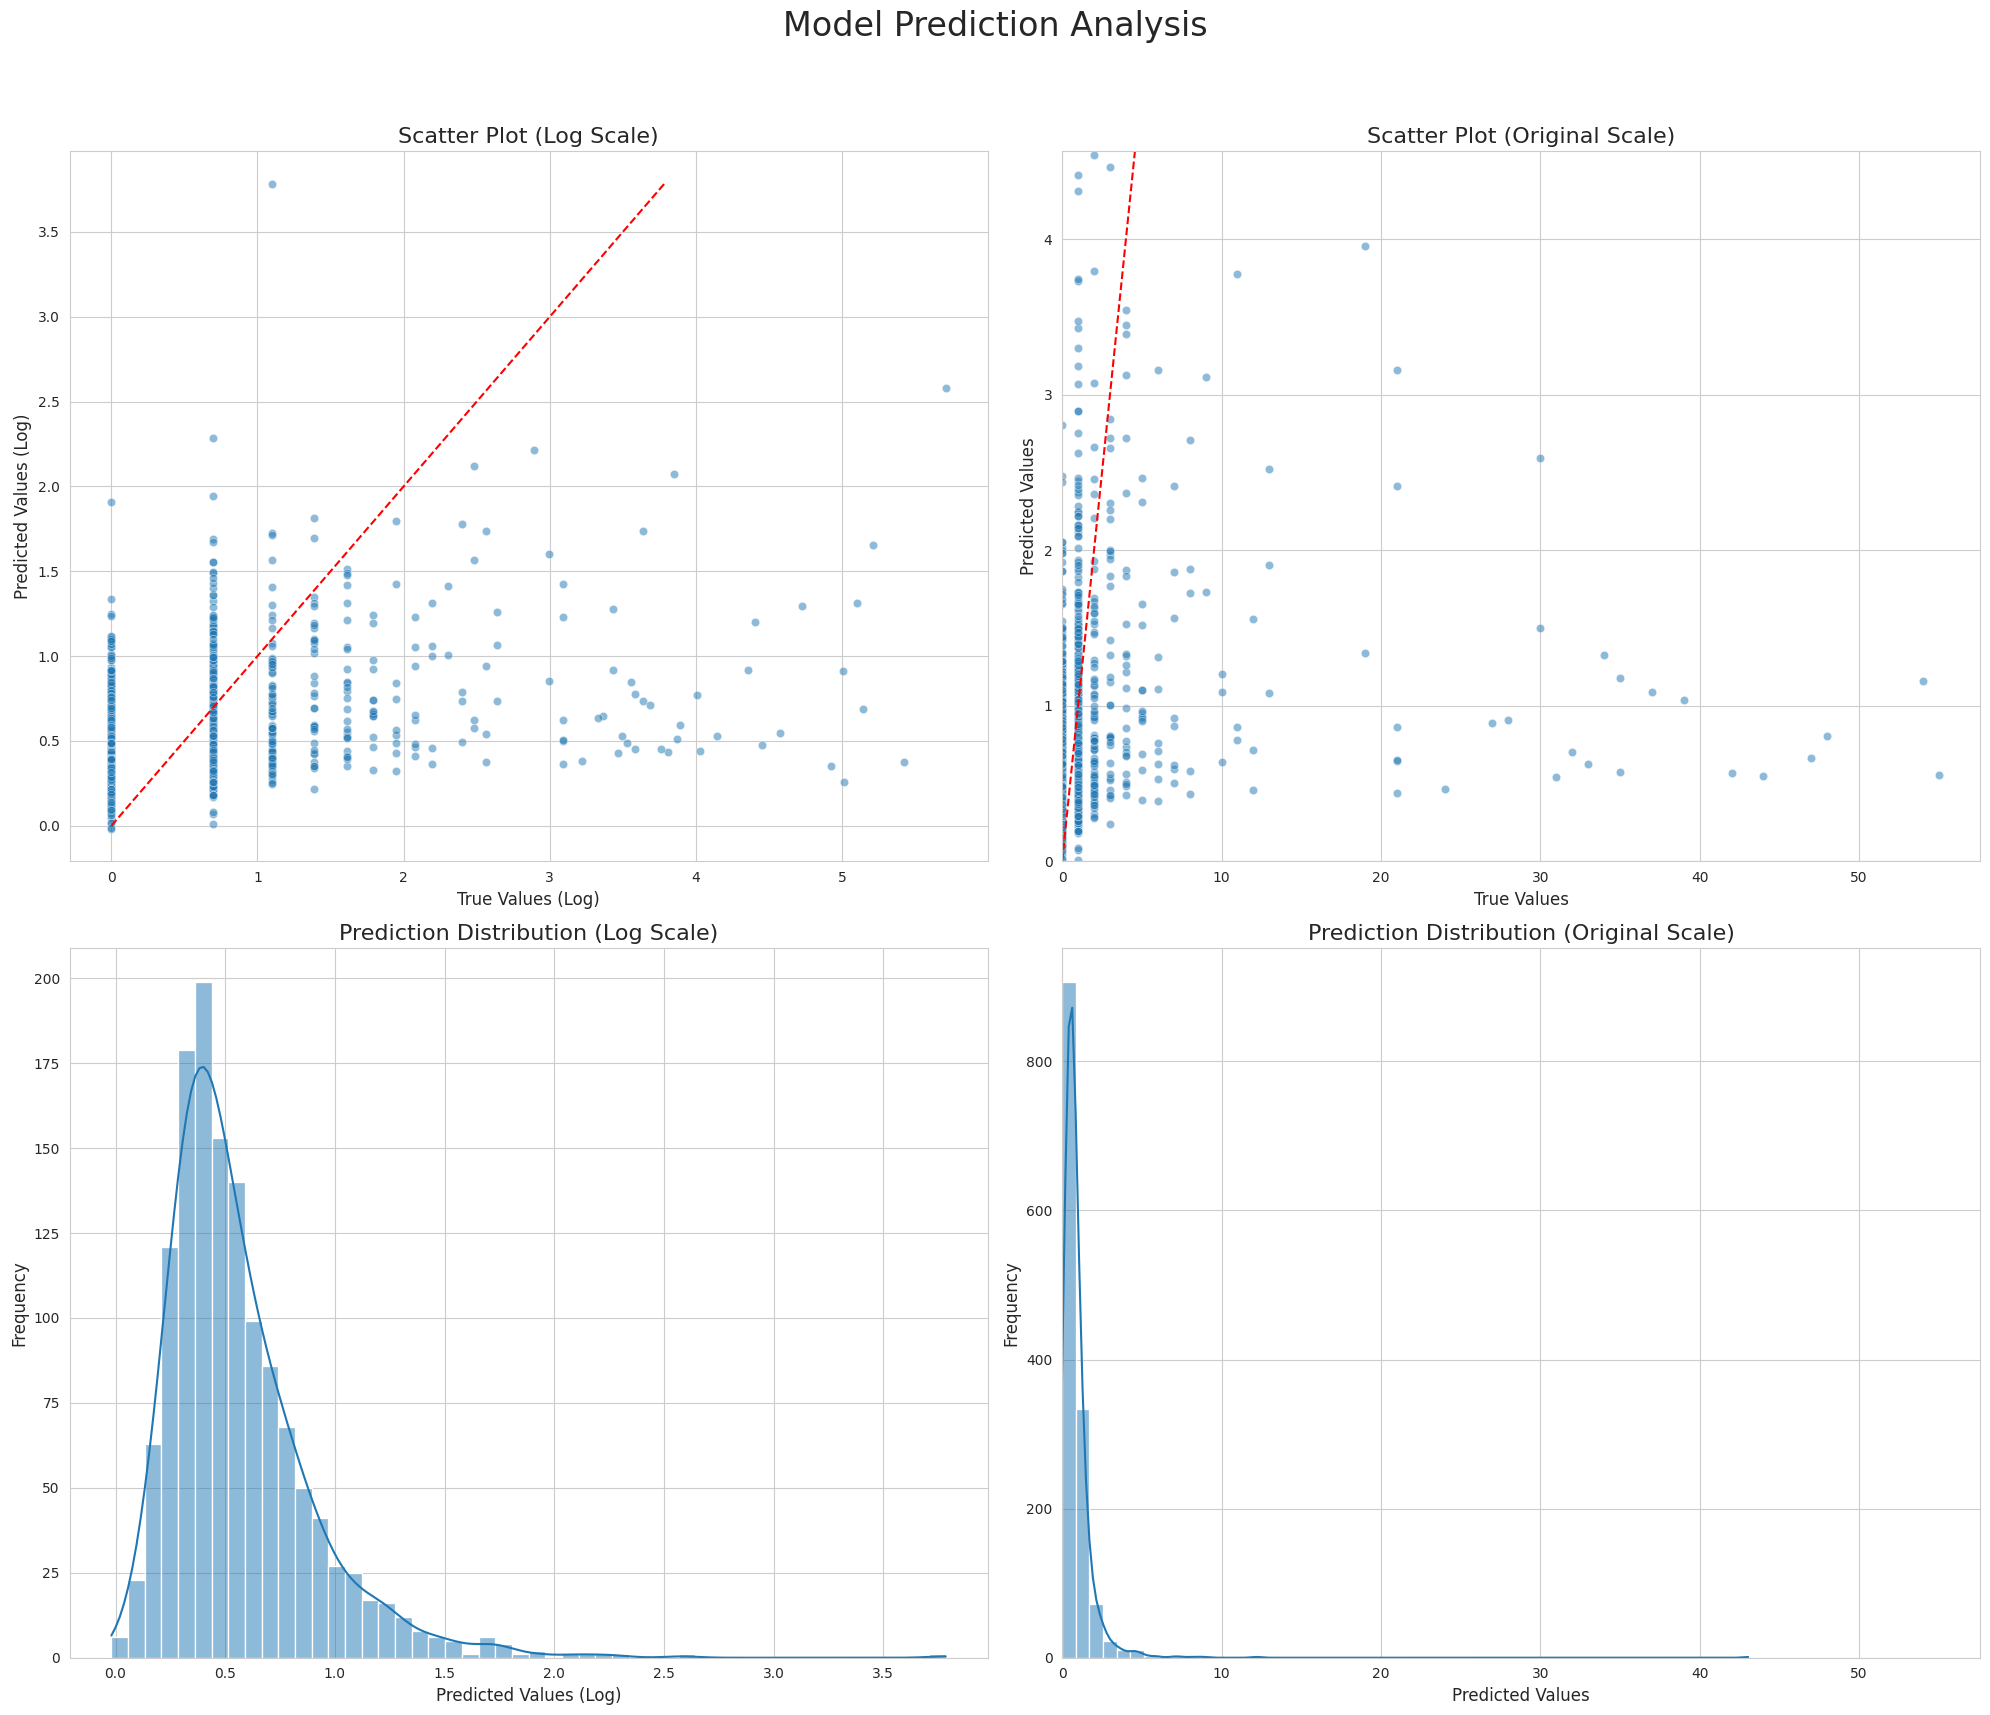

✅ 예측값 및 모델 저장 완료
Model Type: 'TEXT_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 92,989개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 13,632개 샘플 (Zero: 6816, Non-Zero: 6816)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 213,377


Epoch 1/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.7165


Epoch 1/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.6524, MAE: 0.5774, RMSE: 0.8077, R²: 0.0822
  - Original Scale -> MSE: 156.7070, MAE: 2.8009, RMSE: 12.5183, R²: -0.0145
✓ Best model updated (Val MAE: 2.8009)


Epoch 2/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.6418


Epoch 2/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.6411, MAE: 0.5587, RMSE: 0.8007, R²: 0.0970
  - Original Scale -> MSE: 156.7892, MAE: 2.7687, RMSE: 12.5215, R²: -0.0151
✓ Best model updated (Val MAE: 2.7687)


Epoch 3/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.6309


Epoch 3/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.6405, MAE: 0.5503, RMSE: 0.8003, R²: 0.0978
  - Original Scale -> MSE: 157.0191, MAE: 2.7542, RMSE: 12.5307, R²: -0.0165
✓ Best model updated (Val MAE: 2.7542)


Epoch 4/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.6251


Epoch 4/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.6245, MAE: 0.5590, RMSE: 0.7902, R²: 0.1200
  - Original Scale -> MSE: 155.7374, MAE: 2.7709, RMSE: 12.4795, R²: -0.0083


Epoch 5/5 [T]:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.6247


Epoch 5/5 [V]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.6248, MAE: 0.5526, RMSE: 0.7904, R²: 0.1200
  - Original Scale -> MSE: 156.2049, MAE: 2.7575, RMSE: 12.4982, R²: -0.0113

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/22 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.6298, MAE: 0.5385, RMSE: 0.7936, R²: 0.1001
  [Original Scale] -> MSE: 707.9207, MAE: 3.5441, RMSE: 26.6068, R²: -0.0058
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/22 [00:00<?, ?it/s]

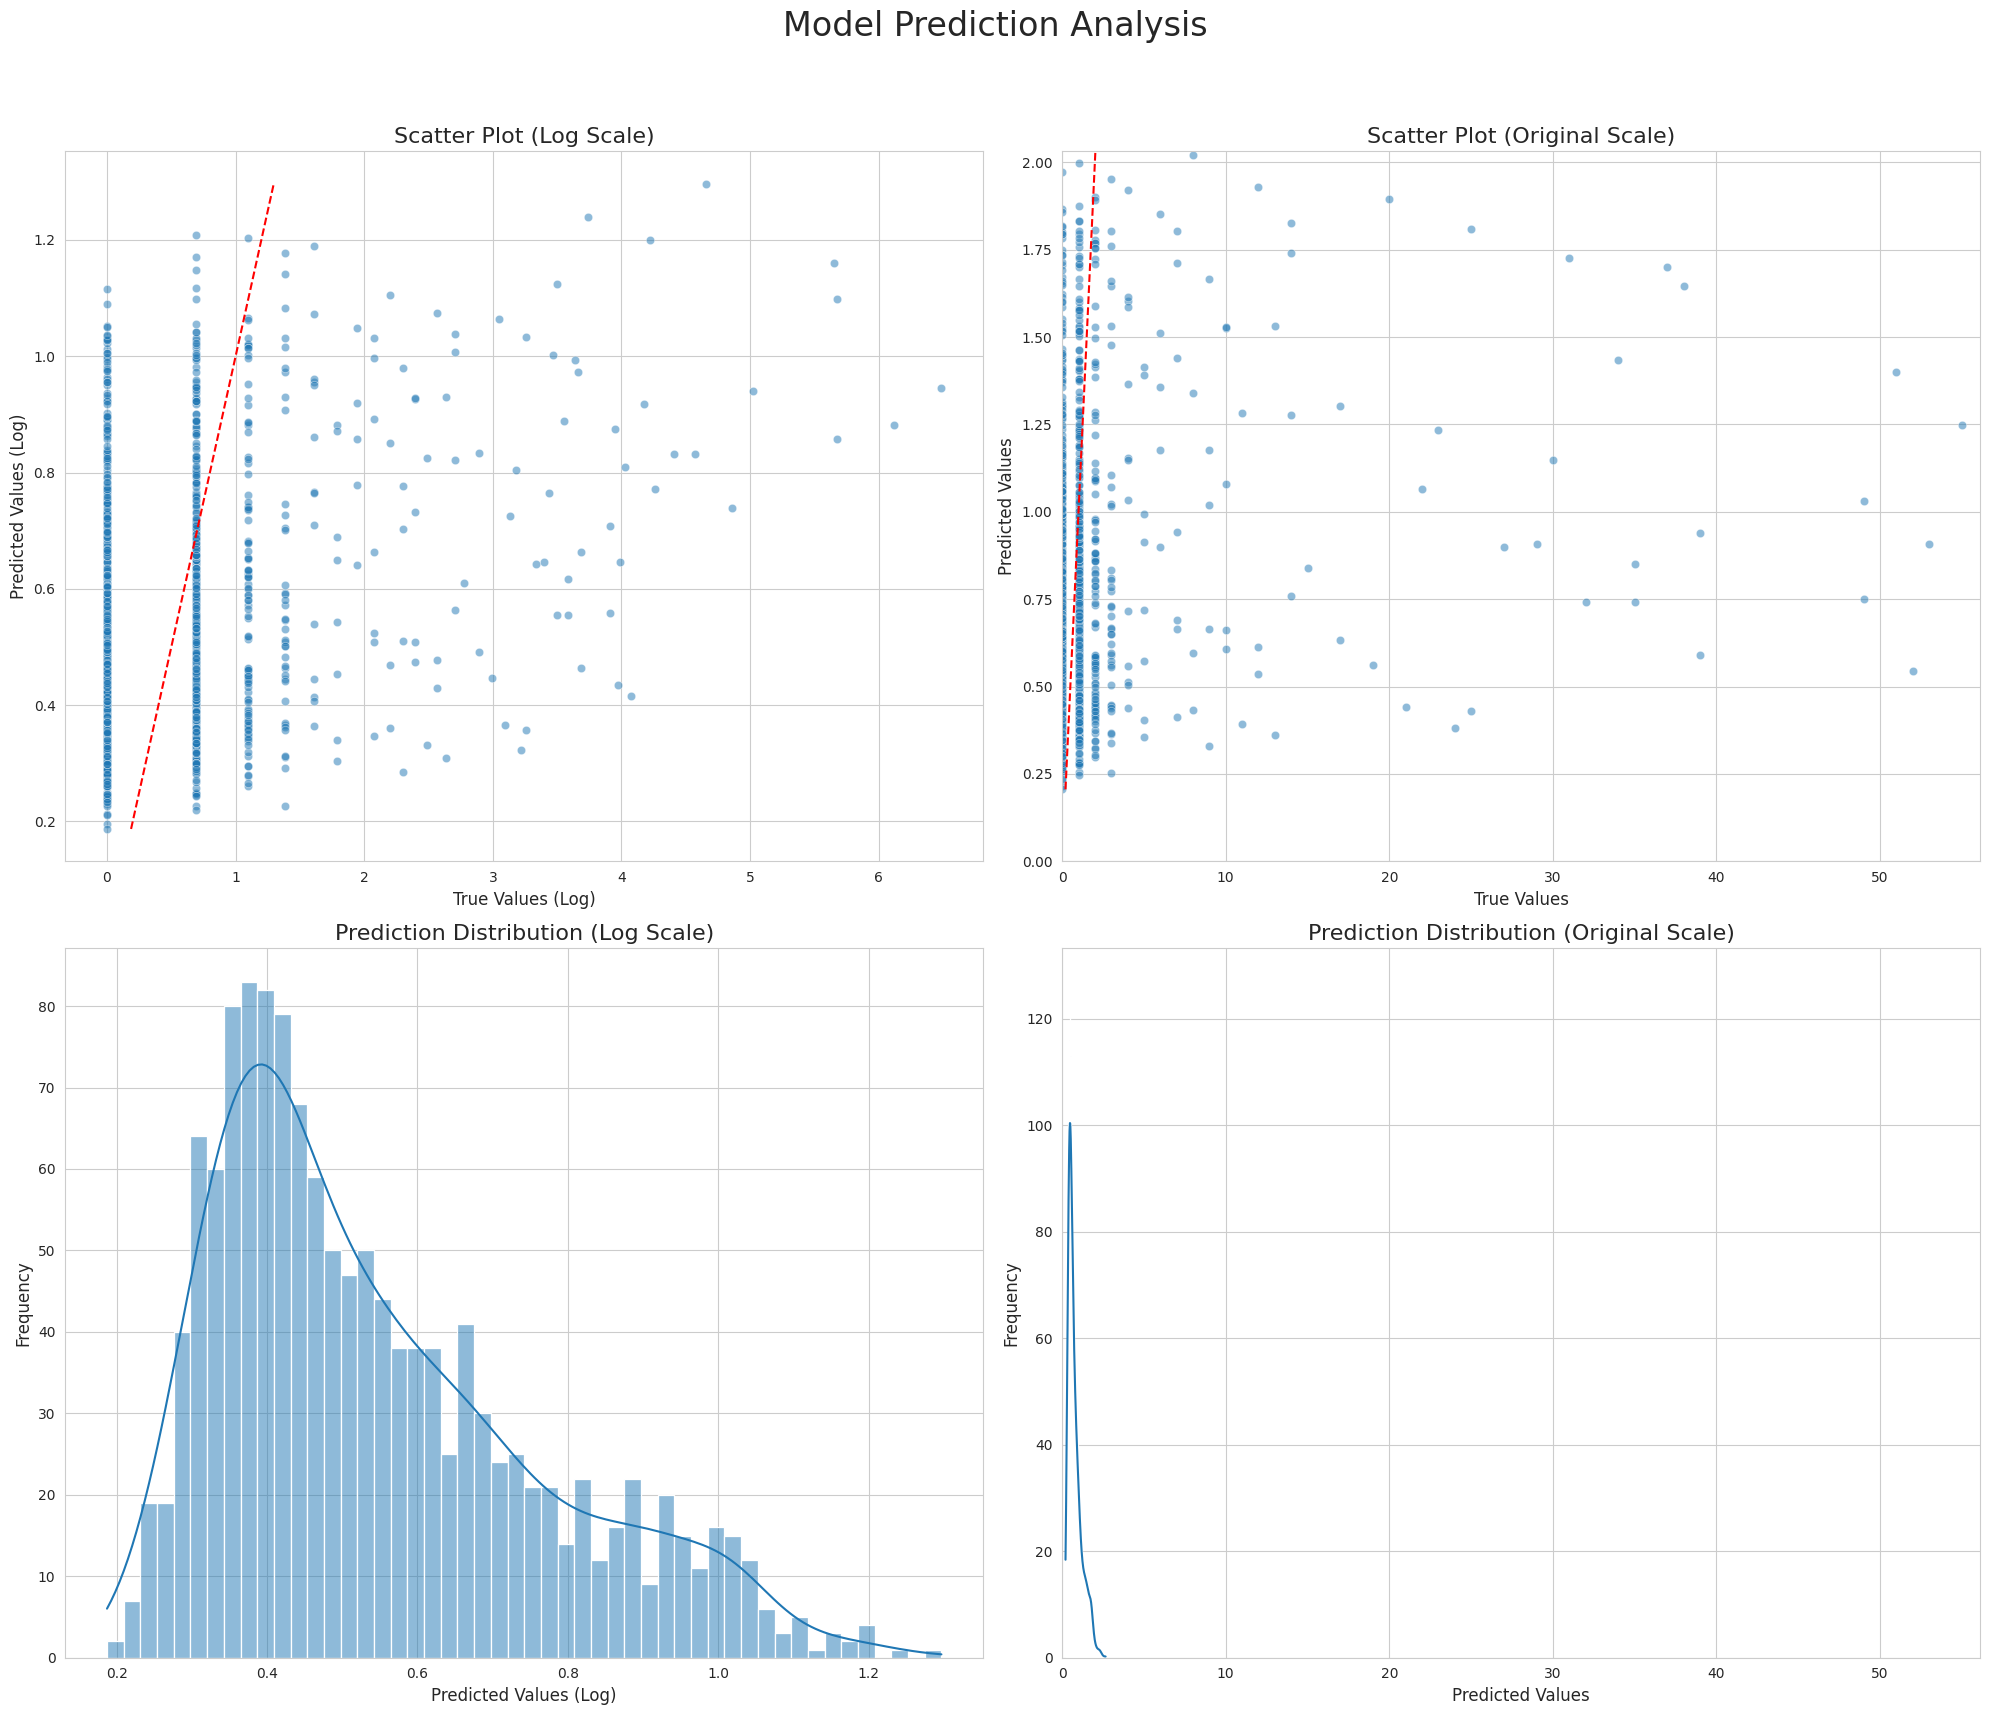


📊 Alpha별 성능 비교:
   alpha   mse_log   mae_log  rmse_log    r2_log    mse_orig  mae_orig  \
0   0.00  0.644404  0.544522  0.802748  0.100082  730.737976  3.639570   
1   0.25  0.658732  0.548176  0.811623  0.080073  731.925293  3.645092   
2   0.50  0.692787  0.562794  0.832338  0.032515  732.980408  3.679309   
3   0.75  0.746589  0.586749  0.864054 -0.042620  734.098267  3.743877   
4   1.00  0.820121  0.616045  0.905605 -0.145308  735.992920  3.840450   

   rmse_orig   r2_orig  
0  27.032166 -0.005764  
1  27.054118 -0.007398  
2  27.073611 -0.008850  
3  27.094248 -0.010389  
4  27.129189 -0.012997  

⭐️ Best Alpha Based on Original Scale R²:
alpha          0.000000
mse_log        0.644404
mae_log        0.544522
rmse_log       0.802748
r2_log         0.100082
mse_orig     730.737976
mae_orig       3.639570
rmse_orig     27.032166
r2_orig       -0.005764


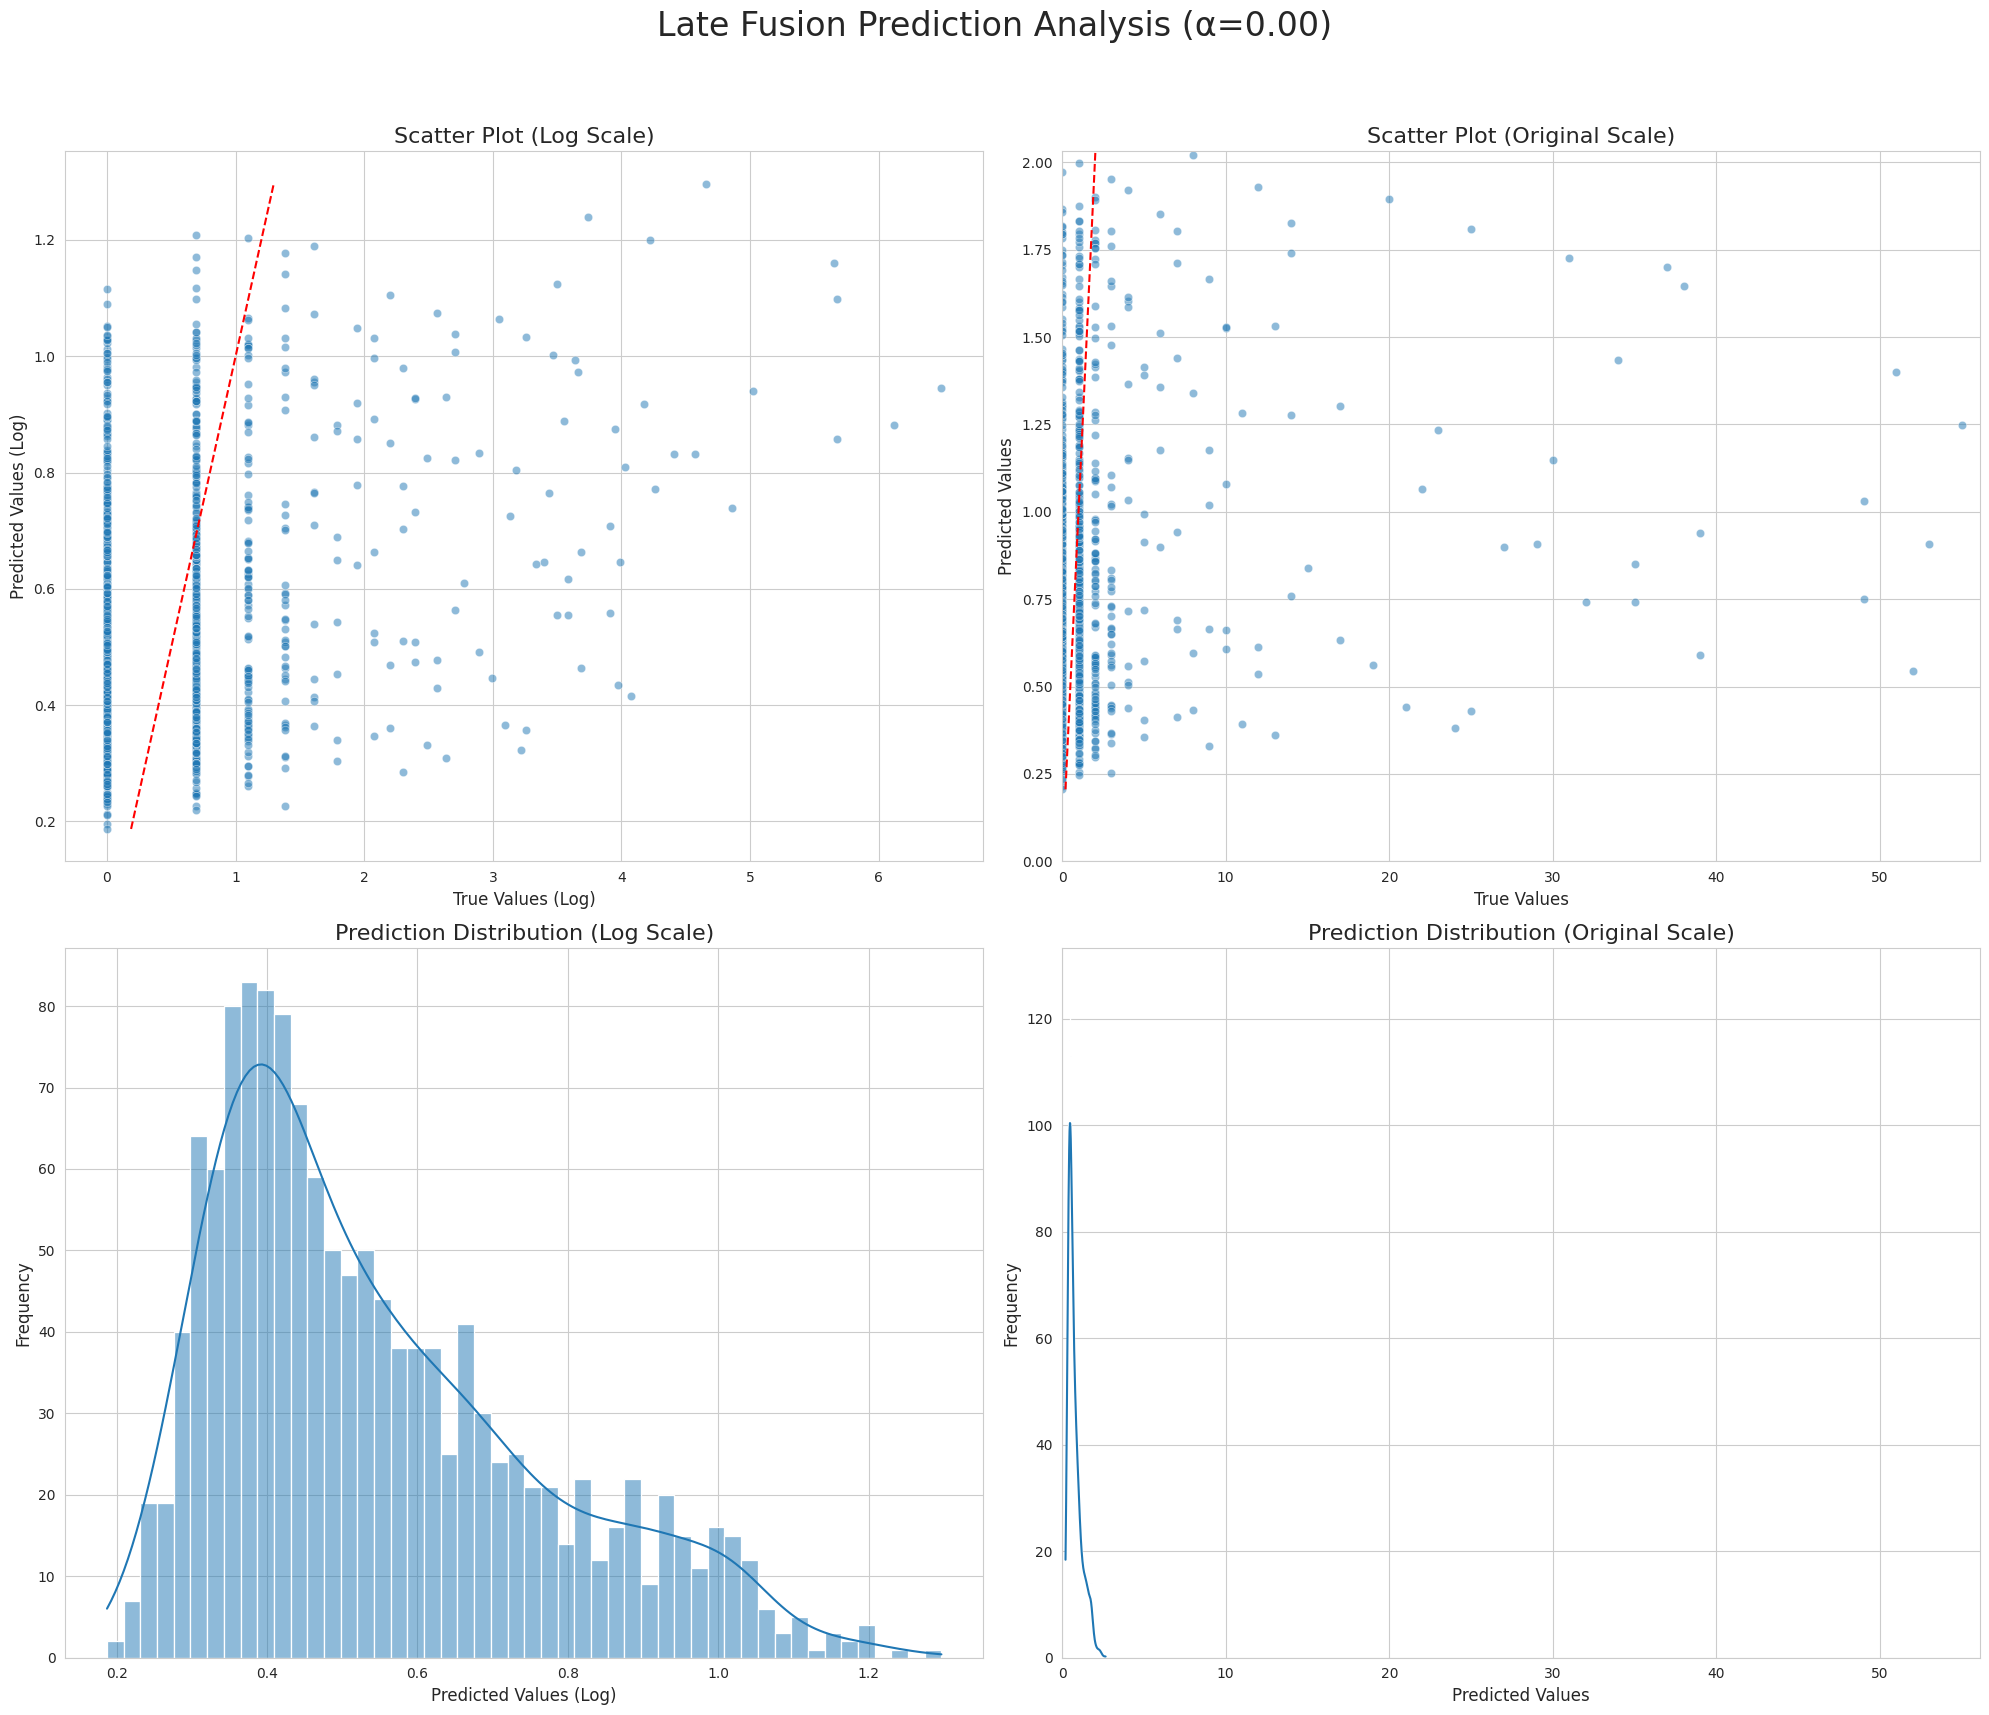

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/audible.csv"
    FEATURE_COLS = ['Rating', 'Average_Rating','Num_of_Ratings',
       'Title_Length', 'Text_Length', 'Time_Lapsed',
       'Deviation_Of_Star_Ratings', 'FOG_Index', 'Flesch_Reading_Ease',
       'Depth', 'Breadth', 'Valence', 'Arousal']

try:
    # 🔹 System 1 (Structured Features) 학습 및 저장
    model_s1, embedder, scaler, preds_s1, _, y_true, s1_metrics = main_training_pipeline(
        csv_path=CSV_FILE_PATH,
        text_column="Review_Text",
        target_column="Helpfulness",
        feature_columns=FEATURE_COLS,
        batch_size=64,
        epochs=5,
        learning_rate=5e-5,
        model_type="feature_mlp",

    )
    # 예측값 저장
    if preds_s1 is not None:
        np.save("audible_preds_s1.npy", preds_s1)
        np.save("audible_y_true.npy", y_true)
        torch.save(model_s1.state_dict(), "audible_best_model_FEATURE_MLP.pt")
        print("✅ 예측값 및 모델 저장 완료")

    # 🔹 System 2 (Text Embedding) 학습 및 저장
    model_s2, embedder_s2, scaler_s2, _, preds_s2, y_true, s2_metrics= main_training_pipeline(
      csv_path=CSV_FILE_PATH,
      text_column="Review_Text",
      target_column="Helpfulness",
      feature_columns=FEATURE_COLS,
      batch_size=64,
      epochs=5,
      learning_rate=5e-5,
      model_type="text_mlp",

    )
    if preds_s2 is not None:
      np.save("audible_preds_s2.npy", preds_s2)


    # 🔹 Late Fusion 평가
    ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
    results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
    print("\n📊 Alpha별 성능 비교:")
    print(results_df)

    best_result = ensembler.get_best_result()
    best_alpha = best_result['alpha']

    print("\n⭐️ Best Alpha Based on Original Scale R²:")
    print(best_result.to_string(index=True))

    # 🔸 Late Fusion 시각화 (log scale 기준 예측값 사용)
    visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha)

except FileNotFoundError:
    print("\n" + "=" * 60)
    print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
    print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
    print("=" * 60)

## amazon

Model Type: 'FEATURE_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 89,927개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 17,690개 샘플 (Zero: 8845, Non-Zero: 8845)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


5. 모델 생성 및 학습 시작...
모델 파라미터 수: 20,353


Epoch 1/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.3460


Epoch 1/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.2837, MAE: 0.3837, RMSE: 0.5326, R²: 0.1790
  - Original Scale -> MSE: 36.6566, MAE: 1.0968, RMSE: 6.0545, R²: 0.0028
✓ Best model updated (Val MAE: 1.0968)


Epoch 2/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.2439


Epoch 2/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.2683, MAE: 0.3645, RMSE: 0.5180, R²: 0.2223
  - Original Scale -> MSE: 36.4955, MAE: 1.0757, RMSE: 6.0411, R²: 0.0070
✓ Best model updated (Val MAE: 1.0757)


Epoch 3/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.2344


Epoch 3/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.2620, MAE: 0.3564, RMSE: 0.5119, R²: 0.2404
  - Original Scale -> MSE: 36.4034, MAE: 1.0599, RMSE: 6.0335, R²: 0.0095
✓ Best model updated (Val MAE: 1.0599)


Epoch 4/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.2289


Epoch 4/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.2550, MAE: 0.3588, RMSE: 0.5050, R²: 0.2607
  - Original Scale -> MSE: 36.2583, MAE: 1.0600, RMSE: 6.0215, R²: 0.0134


Epoch 5/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.2257


Epoch 5/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.2511, MAE: 0.3558, RMSE: 0.5011, R²: 0.2720
  - Original Scale -> MSE: 36.1391, MAE: 1.0533, RMSE: 6.0116, R²: 0.0166
✓ Best model updated (Val MAE: 1.0533)

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/28 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.2312, MAE: 0.3489, RMSE: 0.4808, R²: 0.3274
  [Original Scale] -> MSE: 231.0512, MAE: 1.2936, RMSE: 15.2004, R²: 0.0313
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/28 [00:00<?, ?it/s]

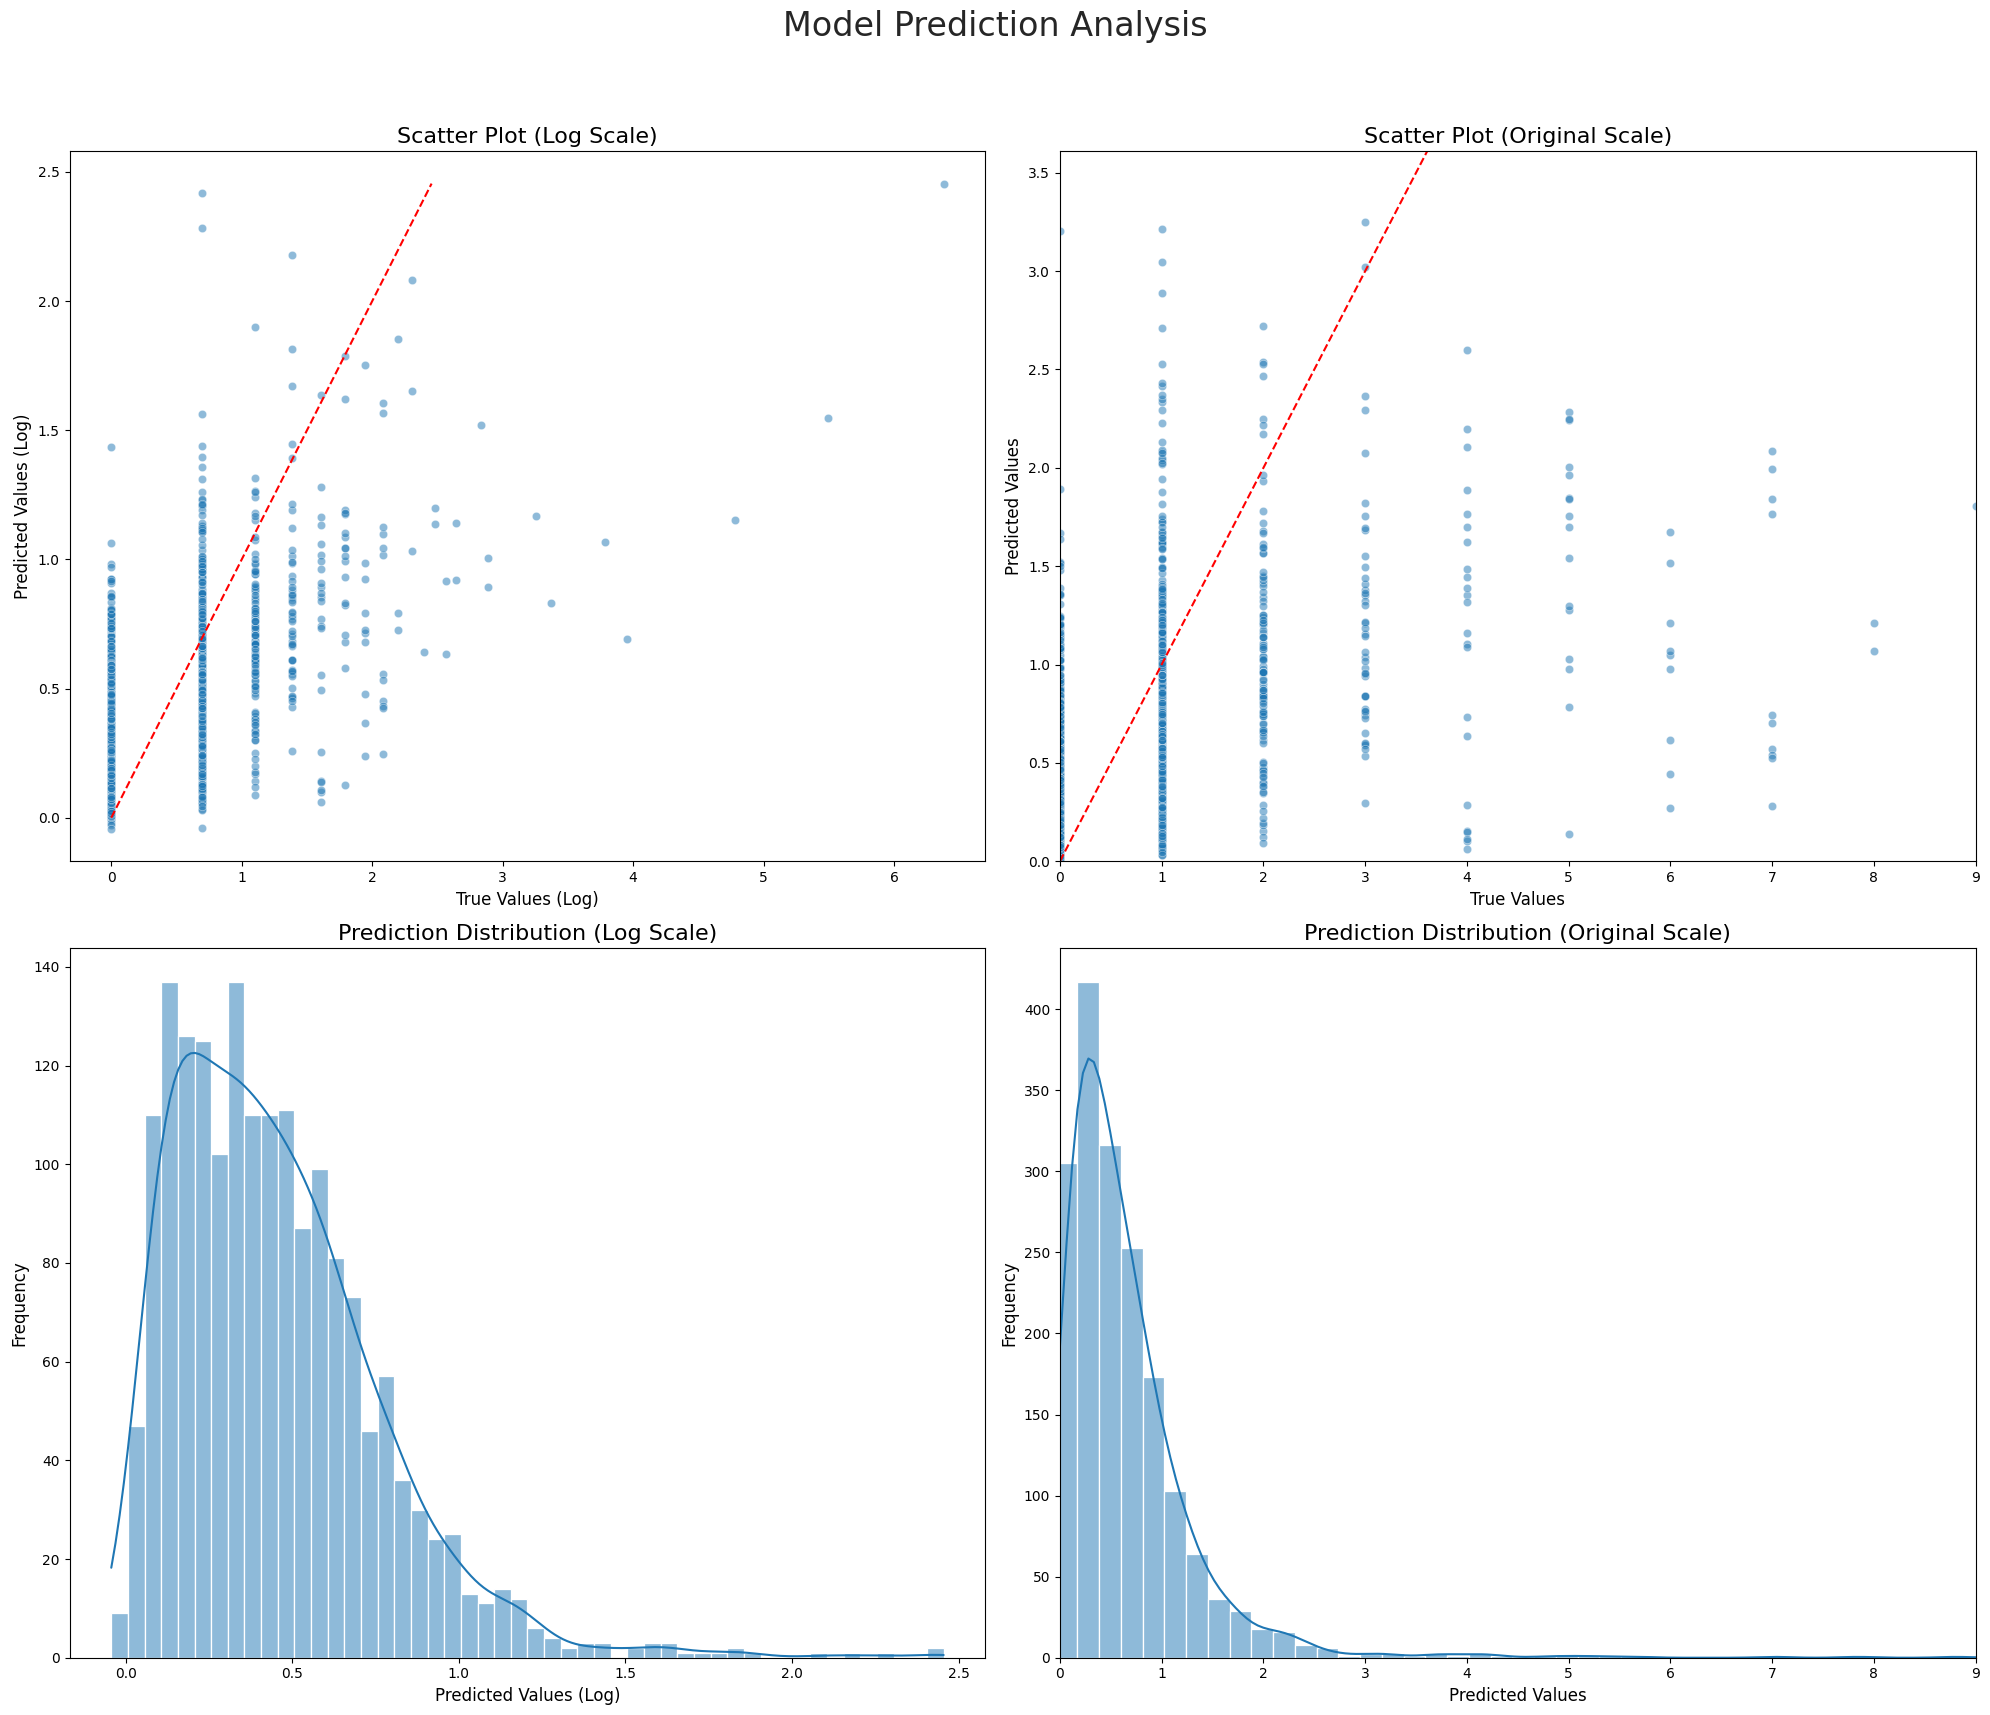

✅ 예측값 및 모델 저장 완료
Model Type: 'TEXT_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 89,927개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 17,690개 샘플 (Zero: 8845, Non-Zero: 8845)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 213,377


Epoch 1/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.2891


Epoch 1/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.2574, MAE: 0.3782, RMSE: 0.5073, R²: 0.2377
  - Original Scale -> MSE: 29.4578, MAE: 1.0333, RMSE: 5.4275, R²: 0.0224
✓ Best model updated (Val MAE: 1.0333)


Epoch 2/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.2383


Epoch 2/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.2518, MAE: 0.3828, RMSE: 0.5018, R²: 0.2546
  - Original Scale -> MSE: 29.3578, MAE: 1.0370, RMSE: 5.4183, R²: 0.0258


Epoch 3/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.2362


Epoch 3/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.2490, MAE: 0.3705, RMSE: 0.4990, R²: 0.2630
  - Original Scale -> MSE: 29.3511, MAE: 1.0212, RMSE: 5.4177, R²: 0.0260
✓ Best model updated (Val MAE: 1.0212)


Epoch 4/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.2302


Epoch 4/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.2477, MAE: 0.3767, RMSE: 0.4977, R²: 0.2669
  - Original Scale -> MSE: 29.2721, MAE: 1.0289, RMSE: 5.4104, R²: 0.0286


Epoch 5/5 [T]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.2280


Epoch 5/5 [V]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.2479, MAE: 0.3741, RMSE: 0.4979, R²: 0.2662
  - Original Scale -> MSE: 29.3889, MAE: 1.0233, RMSE: 5.4212, R²: 0.0247

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/28 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.2462, MAE: 0.3676, RMSE: 0.4962, R²: 0.2760
  [Original Scale] -> MSE: 33.9025, MAE: 1.0359, RMSE: 5.8226, R²: 0.0228
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/28 [00:00<?, ?it/s]

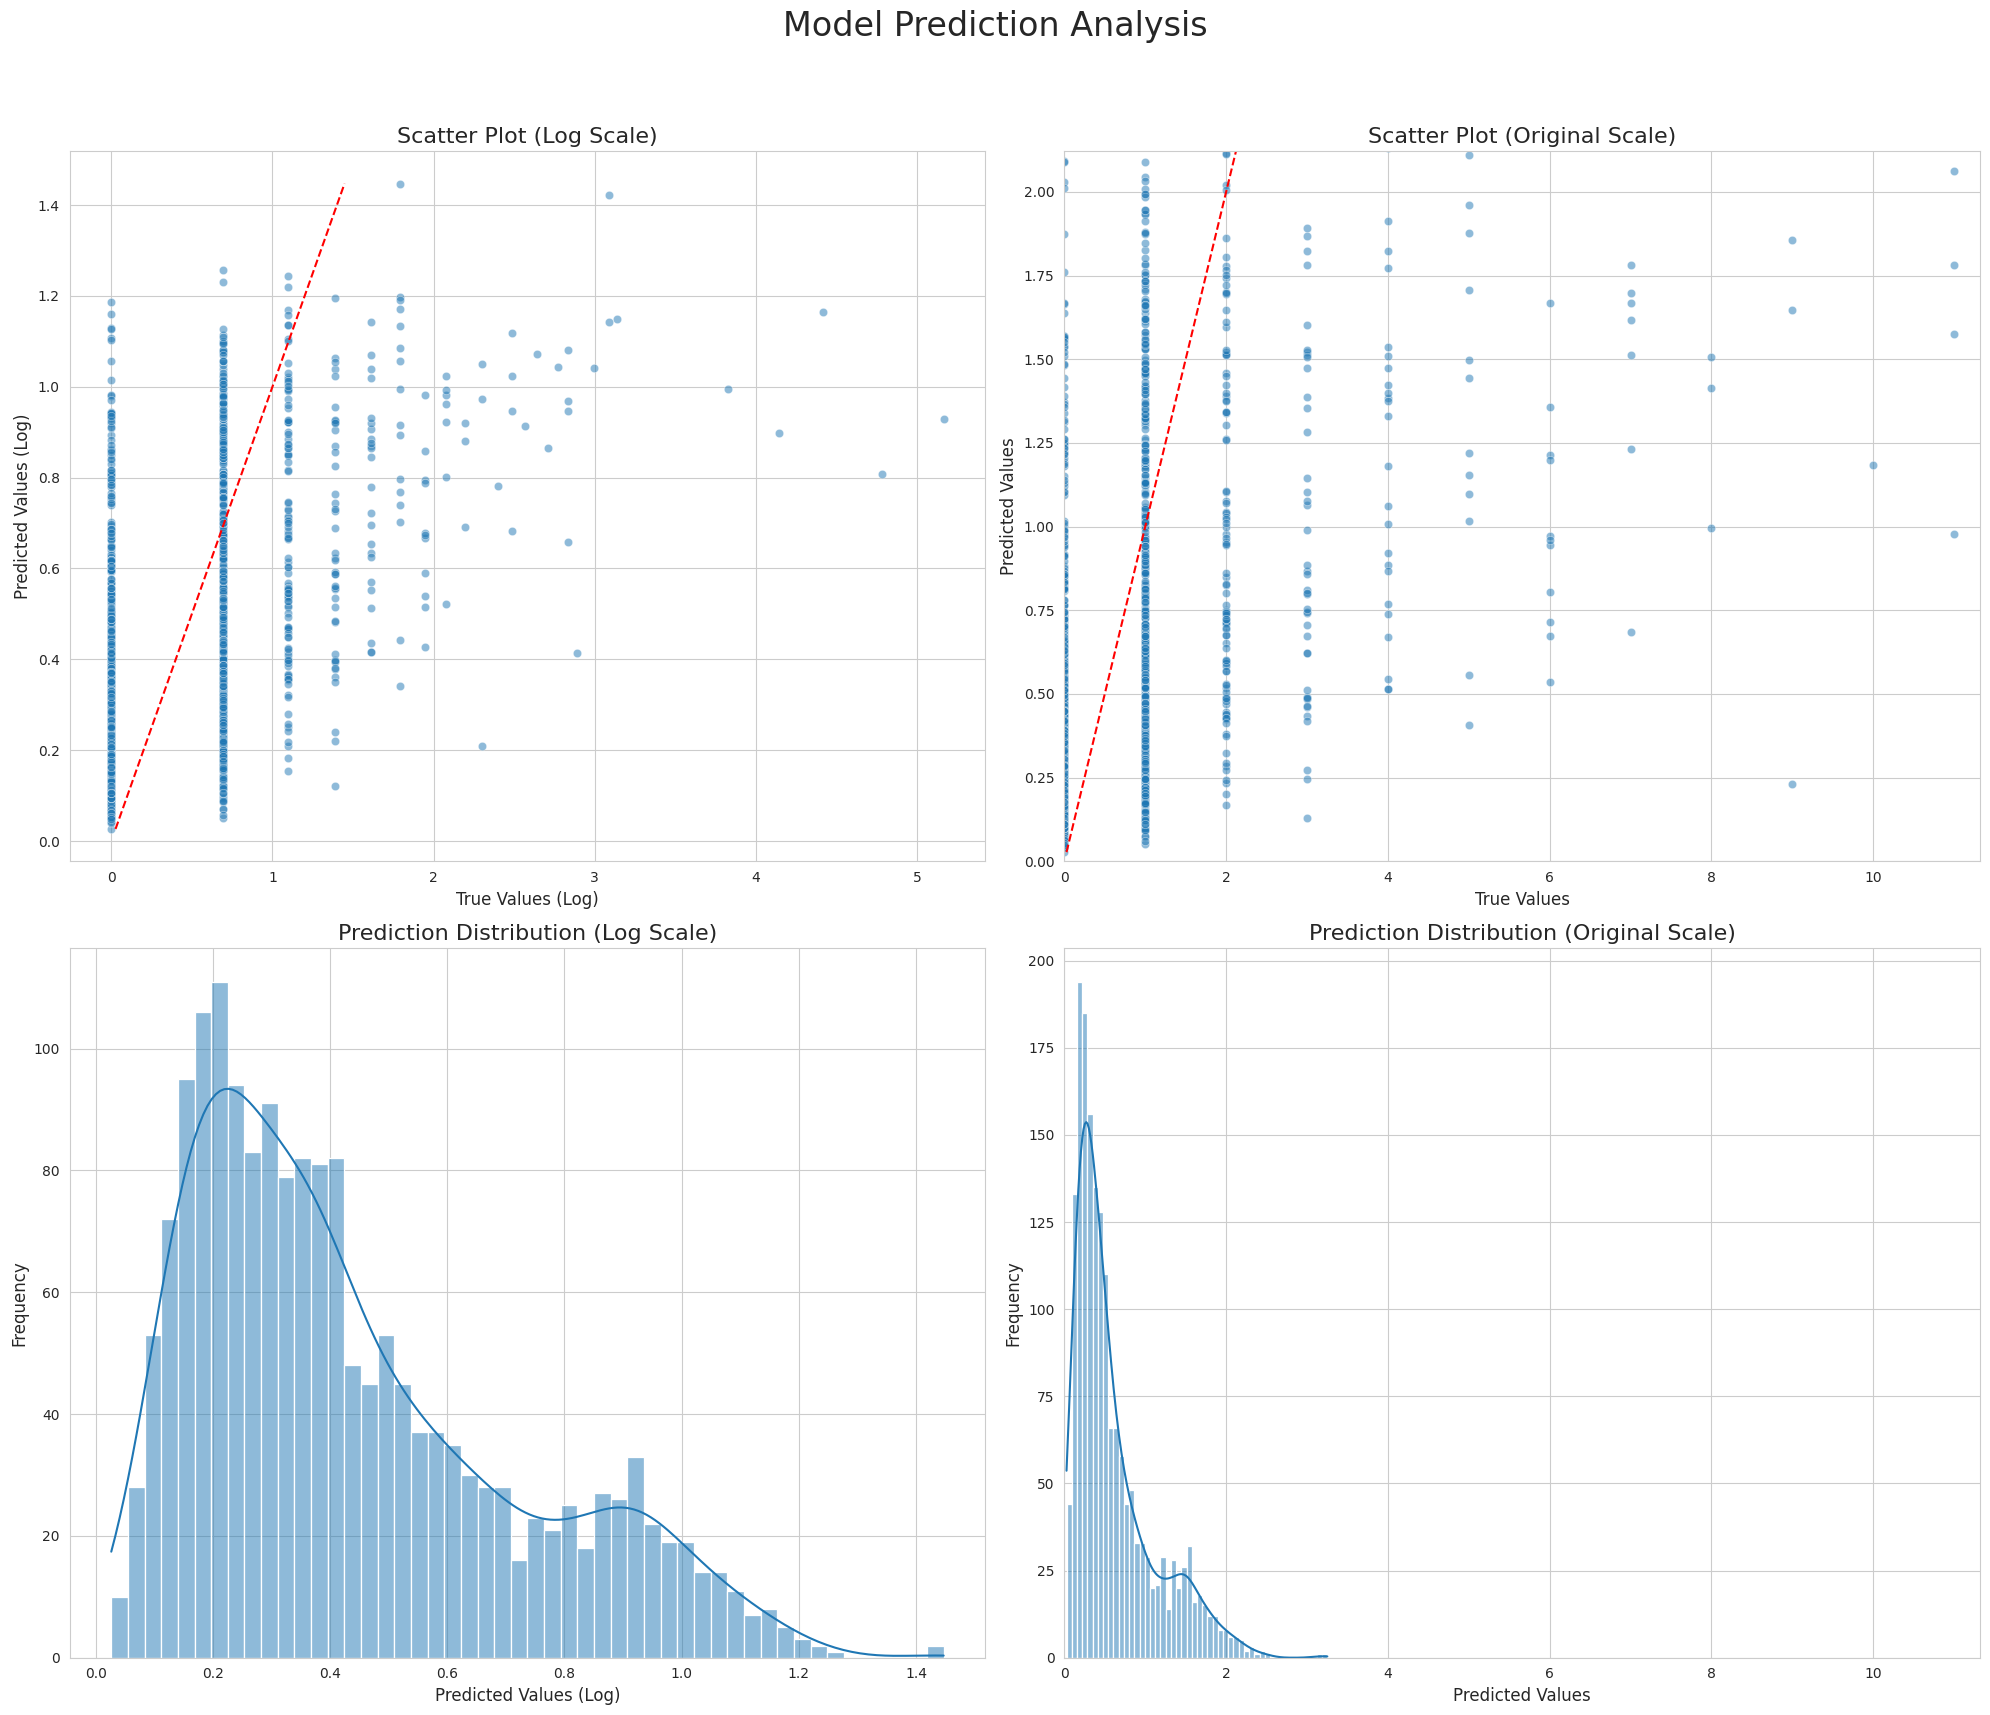


📊 Alpha별 성능 비교:
   alpha   mse_log   mae_log  rmse_log    r2_log   mse_orig  mae_orig  \
0   0.00  0.247338  0.368298  0.497331  0.275993  34.320267  1.040471   
1   0.25  0.260900  0.383254  0.510783  0.236297  34.590622  1.058752   
2   0.50  0.296641  0.410505  0.544648  0.131676  34.899426  1.105457   
3   0.75  0.354547  0.448476  0.595438 -0.037826  35.282475  1.177894   
4   1.00  0.434632  0.492840  0.659266 -0.272251  35.848560  1.272764   

   rmse_orig   r2_orig  
0   5.858350  0.022810  
1   5.881379  0.015112  
2   5.907574  0.006319  
3   5.939905 -0.004587  
4   5.987367 -0.020705  

⭐️ Best Alpha Based on Original Scale R²:
alpha         0.000000
mse_log       0.247338
mae_log       0.368298
rmse_log      0.497331
r2_log        0.275993
mse_orig     34.320267
mae_orig      1.040471
rmse_orig     5.858350
r2_orig       0.022810


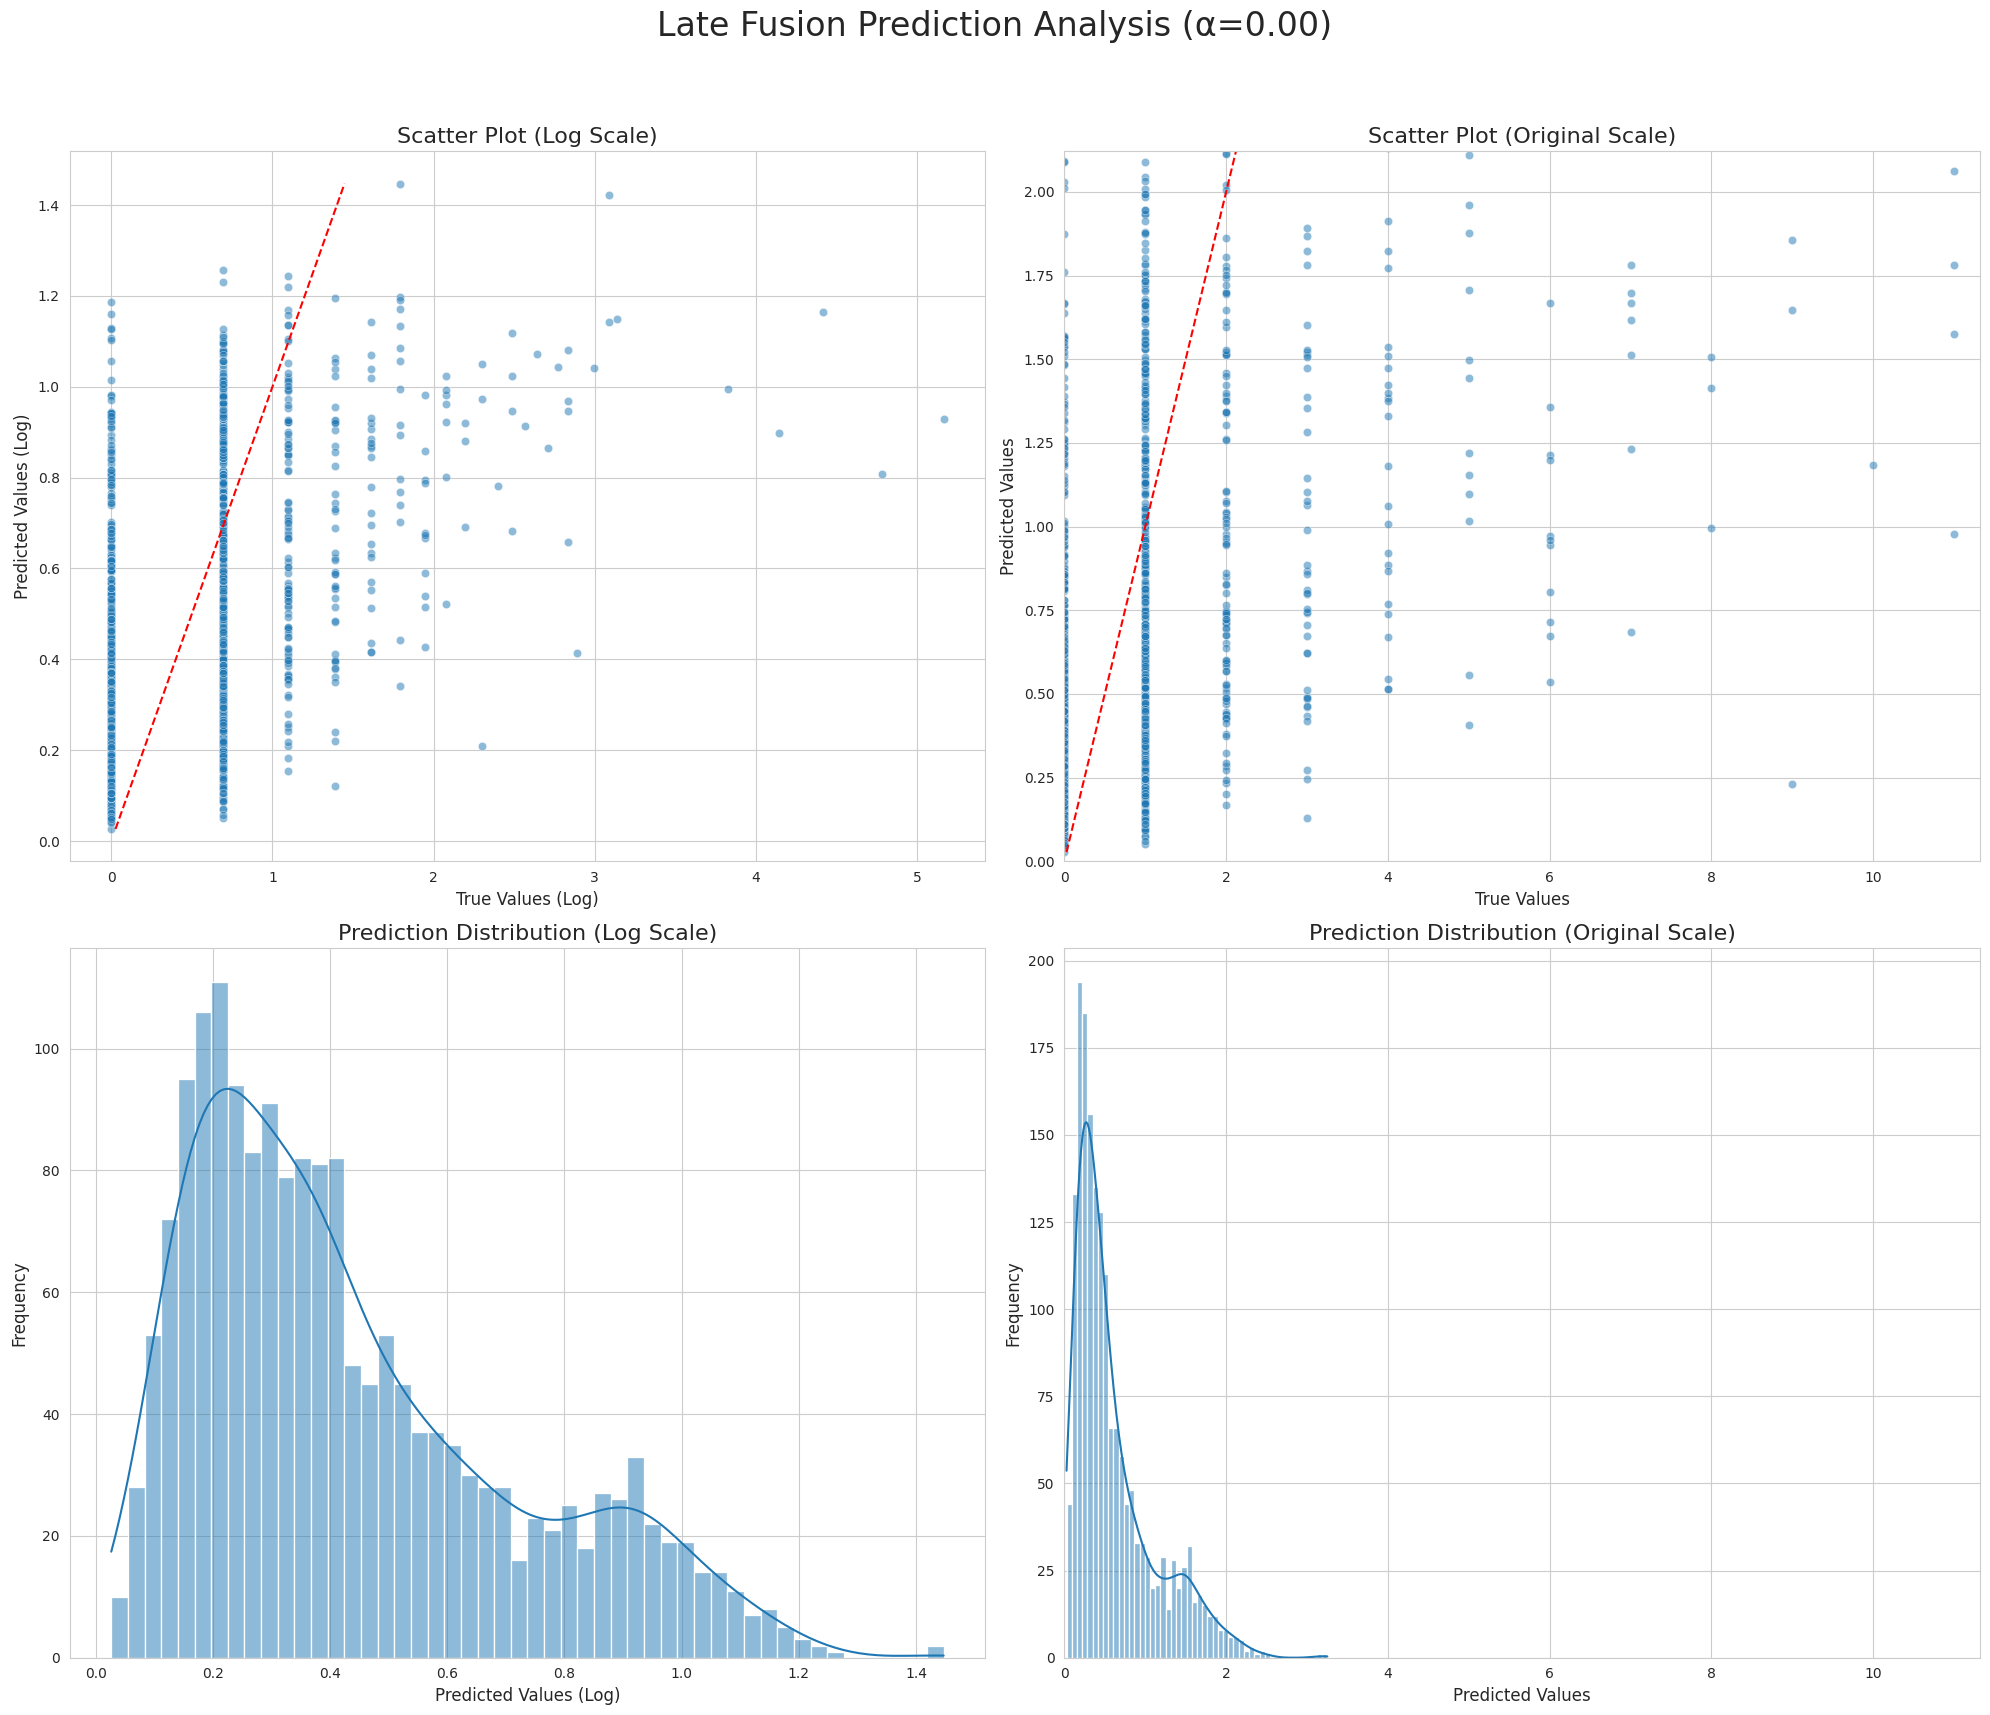

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/amazon.csv"
    FEATURE_COLS = ['Num_of_Ratings', 'Rating',
        'Is_Photo', 'Price', 'Time_Lapsed',
       'Average_Rating', 'Title_Length', 'Text_Length',
       'Deviation_Of_Star_Ratings', 'Flesch_Reading_Ease',
       'Depth', 'Breadth', 'Valence', 'Arousal']

try:
    # 🔹 System 1 (Structured Features) 학습 및 저장
    model_s1, embedder, scaler, preds_s1, _, y_true, s1_metrics = main_training_pipeline(
        csv_path=CSV_FILE_PATH,
        text_column="Review_Text",
        target_column="Helpfulness",
        feature_columns=FEATURE_COLS,
        batch_size=64,
        epochs=5,
        learning_rate=5e-5,
        model_type="feature_mlp",

    )
    # 예측값 저장
    if preds_s1 is not None:
        np.save("amazon_preds_s1.npy", preds_s1)
        np.save("amazon_y_true.npy", y_true)
        torch.save(model_s1.state_dict(), "amazon_best_model_FEATURE_MLP.pt")
        print("✅ 예측값 및 모델 저장 완료")

    # 🔹 System 2 (Text Embedding) 학습 및 저장
    model_s2, embedder_s2, scaler_s2, _, preds_s2, y_true, s2_metrics= main_training_pipeline(
      csv_path=CSV_FILE_PATH,
      text_column="Review_Text",
      target_column="Helpfulness",
      feature_columns=FEATURE_COLS,
      batch_size=64,
      epochs=5,
      learning_rate=5e-5,
      model_type="text_mlp",

    )
    if preds_s2 is not None:
      np.save("amazon_preds_s2.npy", preds_s2)


    # 🔹 Late Fusion 평가
    ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
    results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
    print("\n📊 Alpha별 성능 비교:")
    print(results_df)

    best_result = ensembler.get_best_result()
    best_alpha = best_result['alpha']

    print("\n⭐️ Best Alpha Based on Original Scale R²:")
    print(best_result.to_string(index=True))

    # 🔸 Late Fusion 시각화 (log scale 기준 예측값 사용)
    visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha)

except FileNotFoundError:
    print("\n" + "=" * 60)
    print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
    print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
    print("=" * 60)

## hotel

Model Type: 'FEATURE_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 89,505개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 16,466개 샘플 (Zero: 8233, Non-Zero: 8233)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 22,145


Epoch 1/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.1614


Epoch 1/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.1528, MAE: 0.3608, RMSE: 0.3909, R²: 0.0597
  - Original Scale -> MSE: 0.4809, MAE: 0.5688, RMSE: 0.6935, R²: 0.0399
✓ Best model updated (Val MAE: 0.5688)


Epoch 2/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.1458


Epoch 2/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.1504, MAE: 0.3554, RMSE: 0.3878, R²: 0.0750
  - Original Scale -> MSE: 0.4788, MAE: 0.5617, RMSE: 0.6919, R²: 0.0444
✓ Best model updated (Val MAE: 0.5617)


Epoch 3/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.1430


Epoch 3/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.1474, MAE: 0.3526, RMSE: 0.3839, R²: 0.0932
  - Original Scale -> MSE: 0.4662, MAE: 0.5572, RMSE: 0.6828, R²: 0.0692
✓ Best model updated (Val MAE: 0.5572)


Epoch 4/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.1412


Epoch 4/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.1453, MAE: 0.3493, RMSE: 0.3812, R²: 0.1058
  - Original Scale -> MSE: 0.4538, MAE: 0.5519, RMSE: 0.6736, R²: 0.0936
✓ Best model updated (Val MAE: 0.5519)


Epoch 5/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.1398


Epoch 5/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.1447, MAE: 0.3482, RMSE: 0.3804, R²: 0.1091
  - Original Scale -> MSE: 0.4550, MAE: 0.5506, RMSE: 0.6746, R²: 0.0906
✓ Best model updated (Val MAE: 0.5506)

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/26 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.1422, MAE: 0.3455, RMSE: 0.3772, R²: 0.1043
  [Original Scale] -> MSE: 0.4342, MAE: 0.5340, RMSE: 0.6589, R²: 0.0908
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/26 [00:00<?, ?it/s]

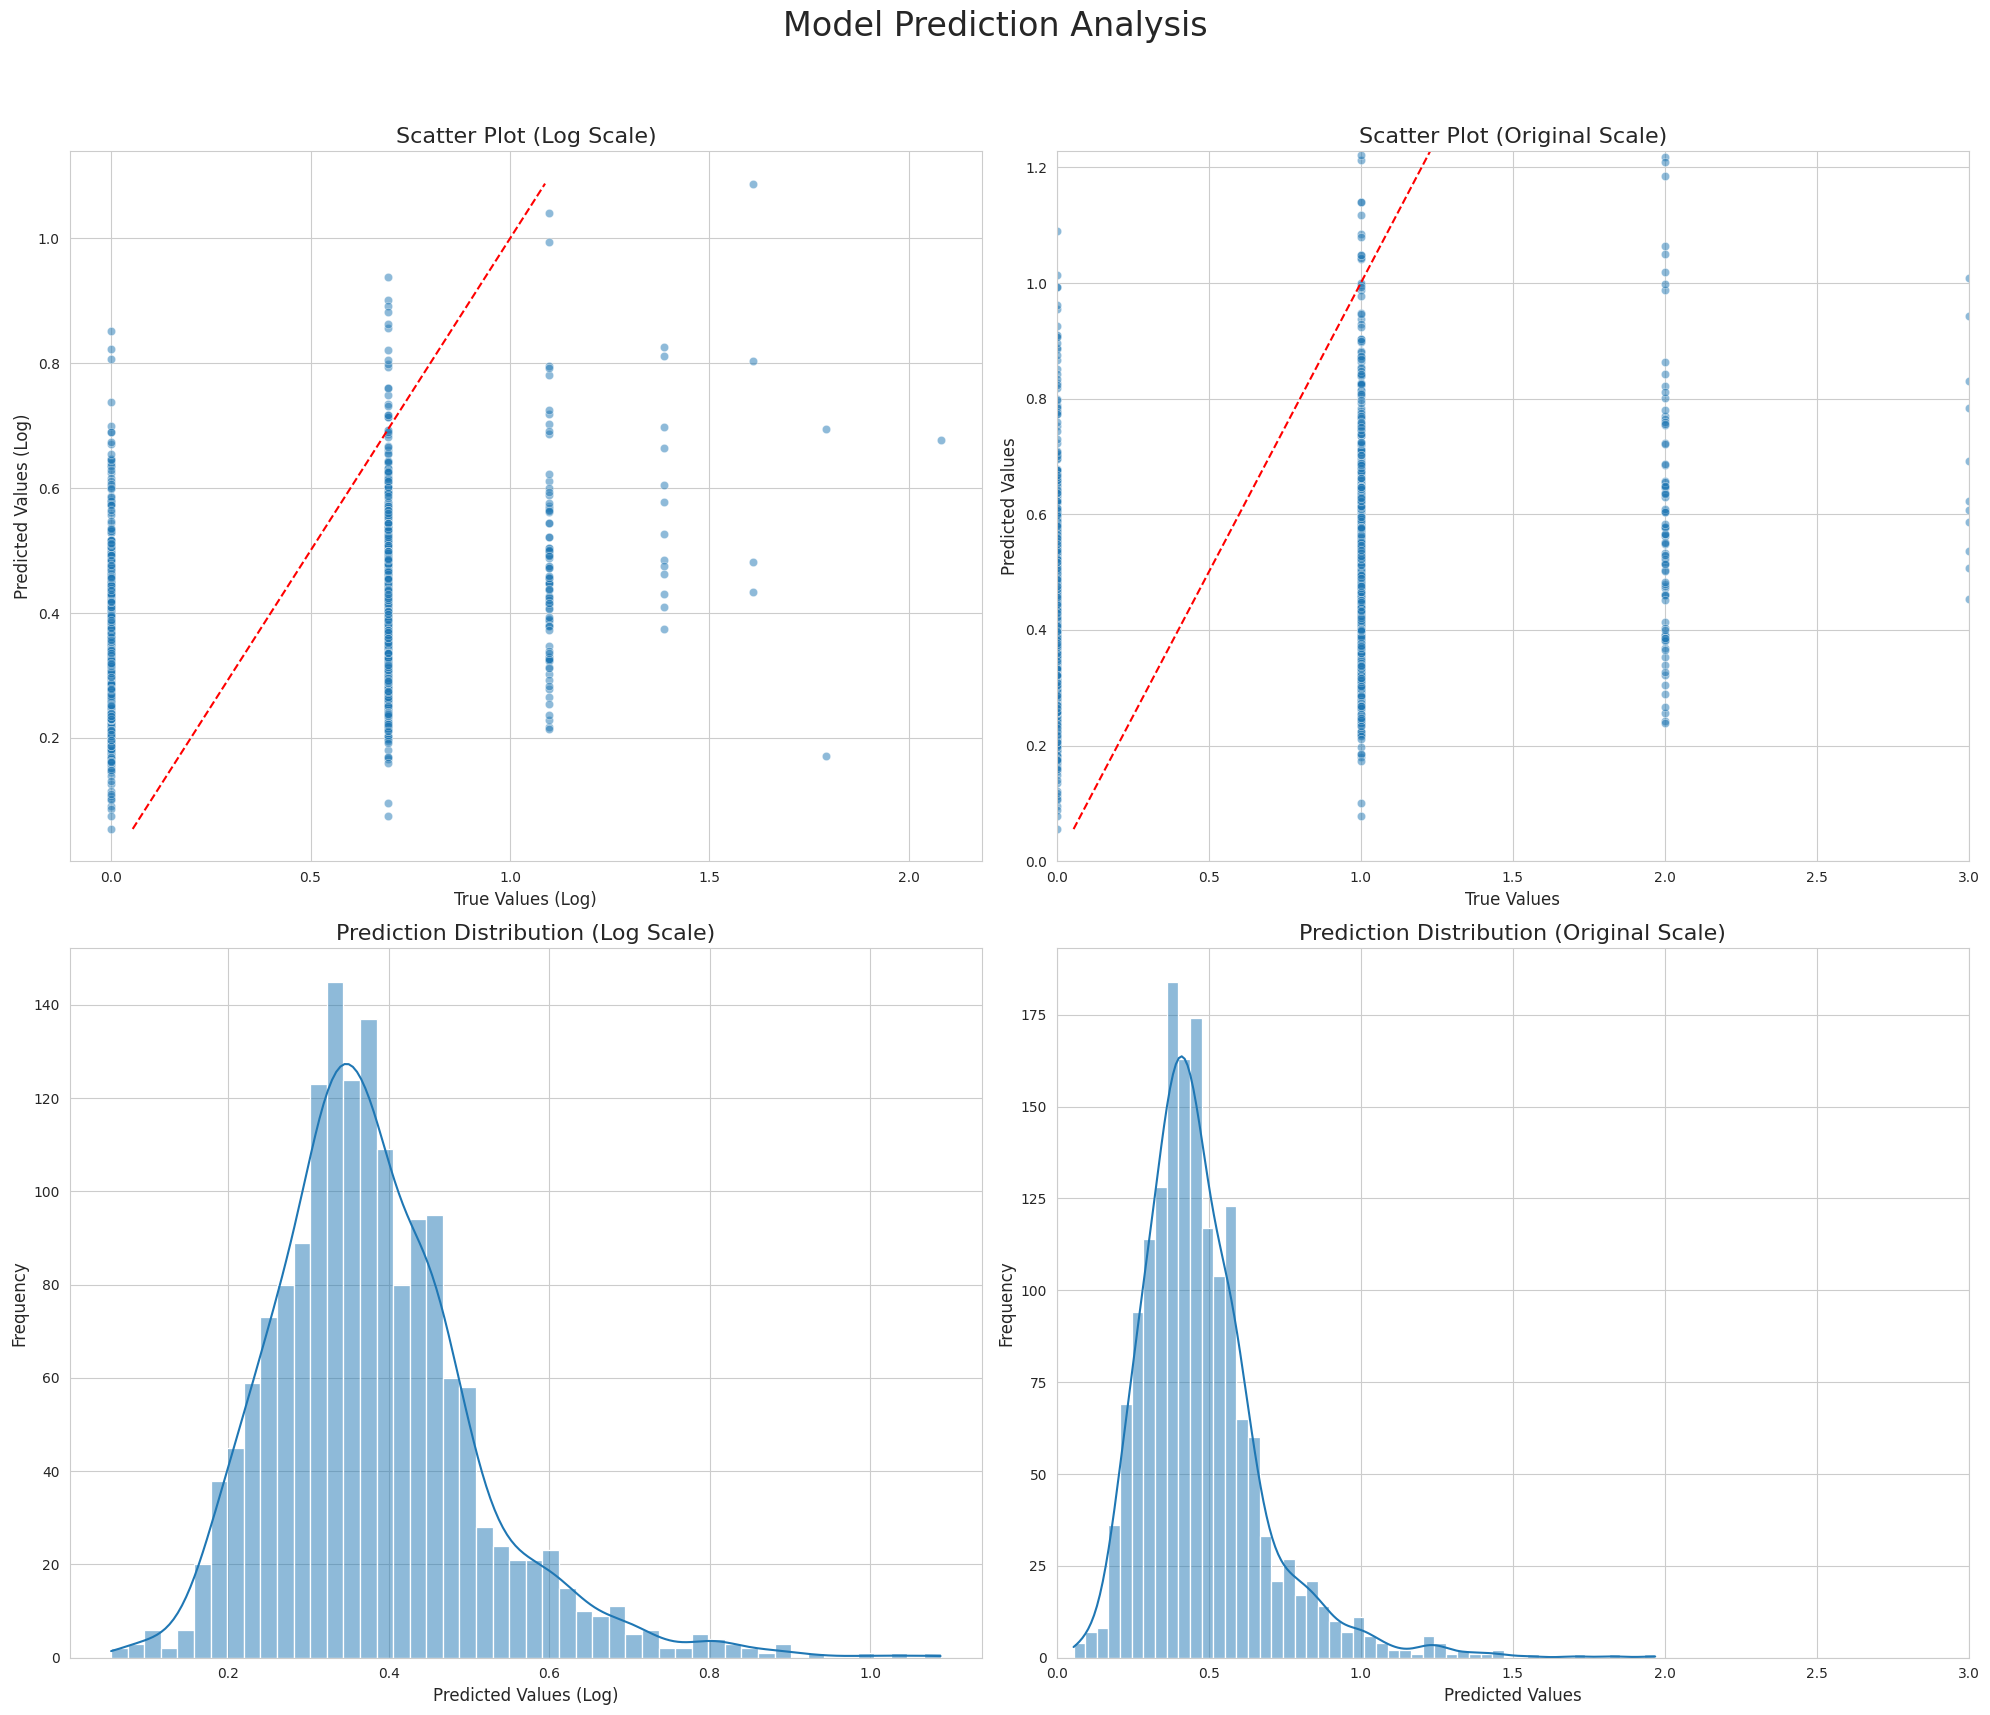

✅ 예측값 및 모델 저장 완료
Model Type: 'TEXT_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 89,505개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 16,466개 샘플 (Zero: 8233, Non-Zero: 8233)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 213,377


Epoch 1/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.1568


Epoch 1/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.1597, MAE: 0.3683, RMSE: 0.3996, R²: 0.0500
  - Original Scale -> MSE: 0.5800, MAE: 0.5825, RMSE: 0.7616, R²: 0.0166
✓ Best model updated (Val MAE: 0.5825)


Epoch 2/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.1488


Epoch 2/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.1590, MAE: 0.3684, RMSE: 0.3987, R²: 0.0541
  - Original Scale -> MSE: 0.5785, MAE: 0.5829, RMSE: 0.7606, R²: 0.0193


Epoch 3/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.1475


Epoch 3/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.1585, MAE: 0.3663, RMSE: 0.3981, R²: 0.0572
  - Original Scale -> MSE: 0.5692, MAE: 0.5792, RMSE: 0.7544, R²: 0.0352
✓ Best model updated (Val MAE: 0.5792)


Epoch 4/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.1467


Epoch 4/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.1587, MAE: 0.3622, RMSE: 0.3984, R²: 0.0556
  - Original Scale -> MSE: 0.5709, MAE: 0.5734, RMSE: 0.7556, R²: 0.0323
✓ Best model updated (Val MAE: 0.5734)


Epoch 5/5 [T]:   0%|          | 0/206 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.1459


Epoch 5/5 [V]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.1577, MAE: 0.3648, RMSE: 0.3971, R²: 0.0618
  - Original Scale -> MSE: 0.5655, MAE: 0.5770, RMSE: 0.7520, R²: 0.0414

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/26 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.1416, MAE: 0.3480, RMSE: 0.3763, R²: 0.0764
  [Original Scale] -> MSE: 0.4097, MAE: 0.5350, RMSE: 0.6401, R²: 0.0601
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/26 [00:00<?, ?it/s]

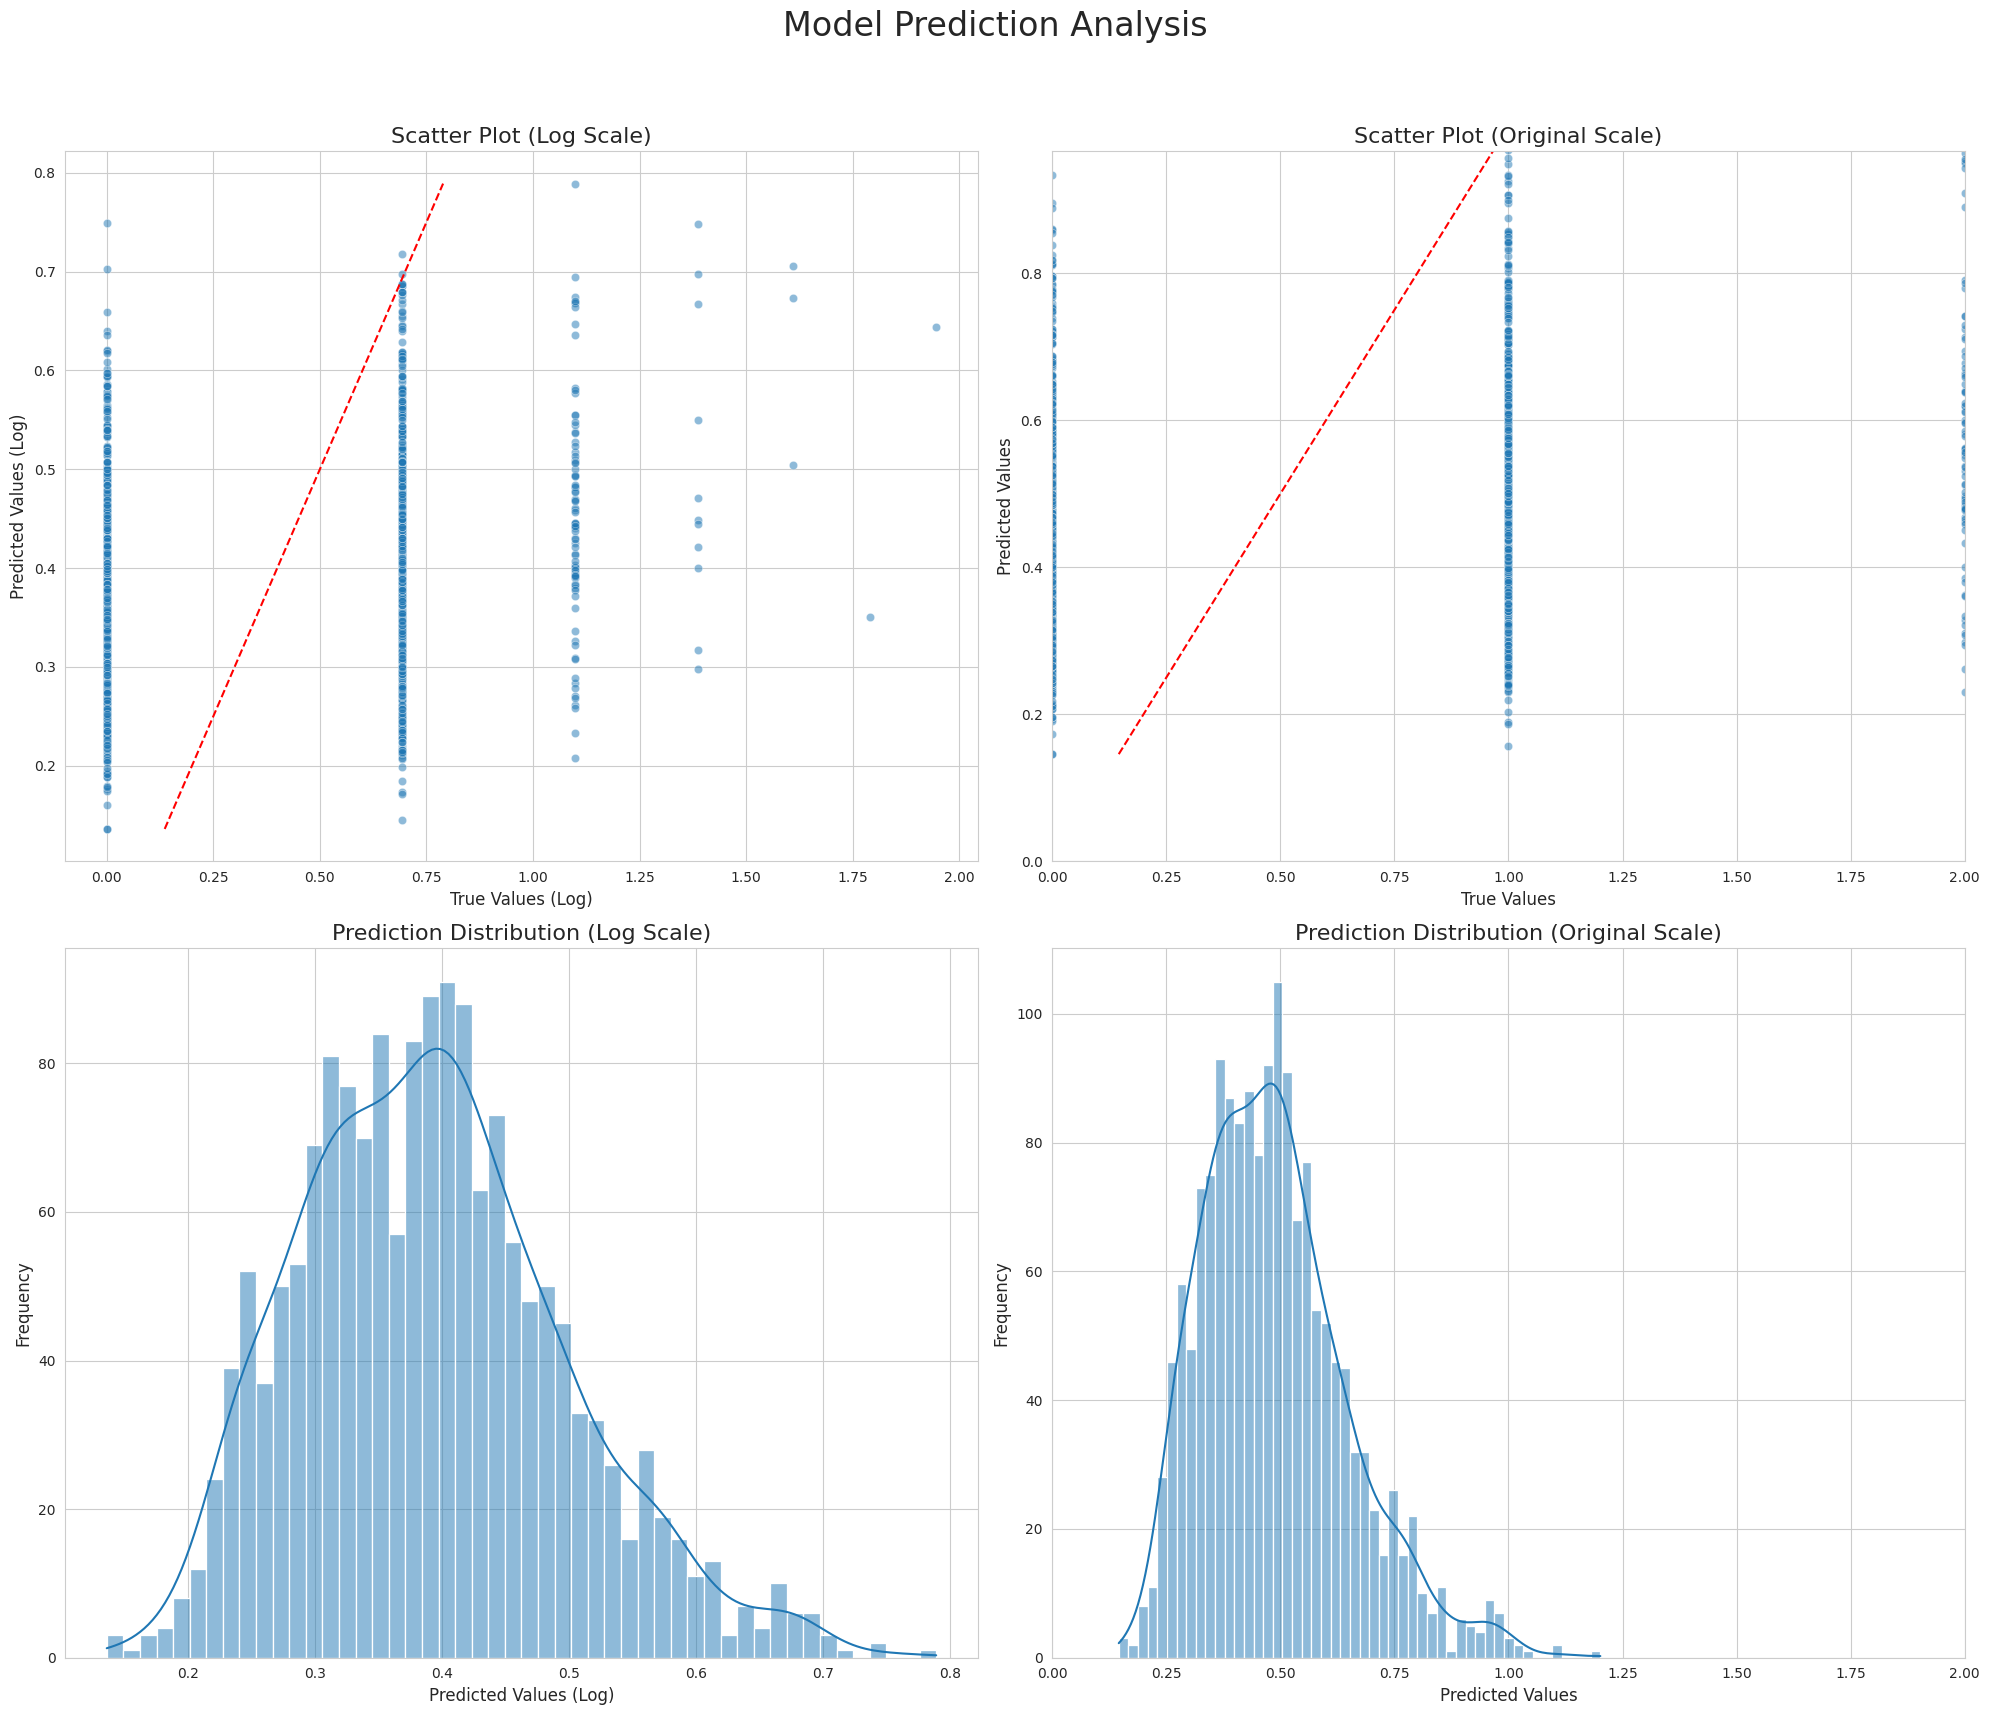


📊 Alpha별 성능 비교:
   alpha   mse_log   mae_log  rmse_log    r2_log  mse_orig  mae_orig  \
0   0.00  0.141748  0.348065  0.376495  0.076424  0.411133  0.535487   
1   0.25  0.143771  0.354837  0.379171  0.063248  0.420114  0.546181   
2   0.50  0.149215  0.361791  0.386283  0.027777  0.436437  0.556911   
3   0.75  0.158084  0.369150  0.397598 -0.030011  0.460328  0.568271   
4   1.00  0.170385  0.377330  0.412777 -0.110159  0.492444  0.581303   

   rmse_orig   r2_orig  
0   0.641196  0.060104  
1   0.648162  0.039573  
2   0.660634  0.002255  
3   0.678475 -0.052361  
4   0.701743 -0.125781  

⭐️ Best Alpha Based on Original Scale R²:
alpha        0.000000
mse_log      0.141748
mae_log      0.348065
rmse_log     0.376495
r2_log       0.076424
mse_orig     0.411133
mae_orig     0.535487
rmse_orig    0.641196
r2_orig      0.060104


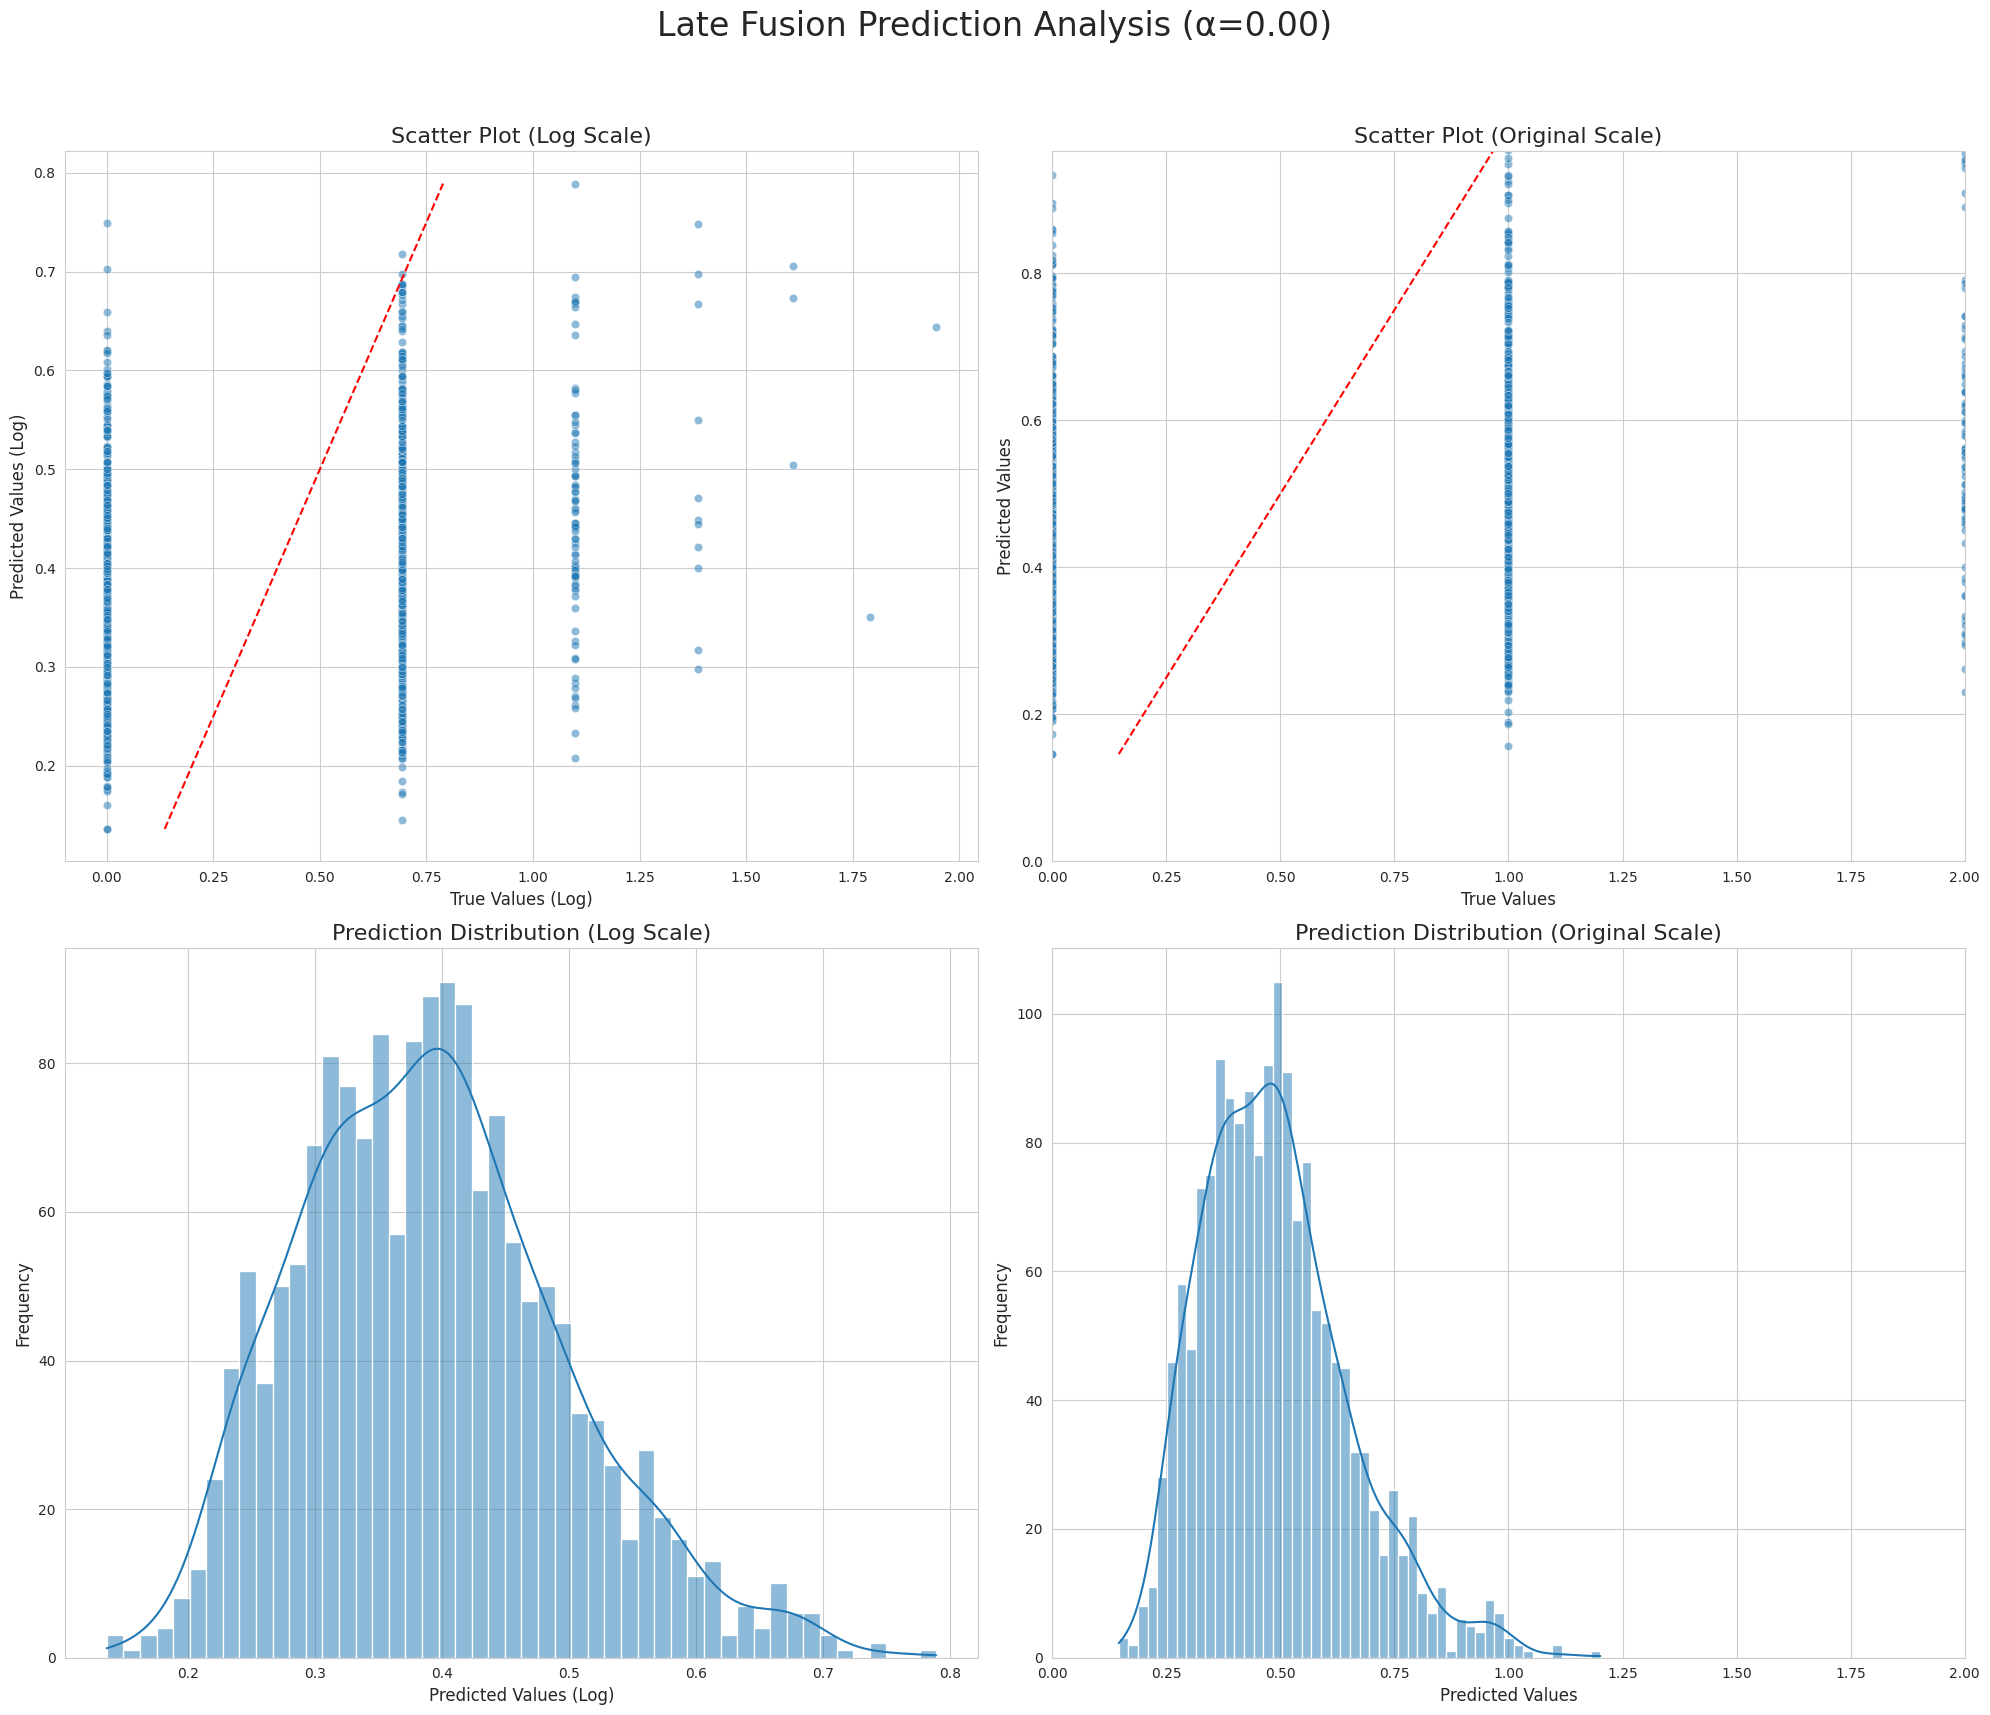

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/hotel.csv"
    FEATURE_COLS = ['Rating', 'Average_Rating',
       'Num_of_Ratings', 'Is_Photo',
       'Hotel_Grade', 'Employee_Friendliness_Score', 'Facility_Score',
       'Cleanliness_Score', 'Comfort_Score', 'Value_For_Money_Score',
       'Location_Score', 'Title_Length', 'Text_Length',
       'Time_Lapsed', 'Deviation_Of_Star_Ratings', 'FOG_Index',
       'Flesch_Reading_Ease', 'Depth', 'Breadth', 'Valence', 'Arousal'
       ]

try:
    # 🔹 System 1 (Structured Features) 학습 및 저장
    model_s1, embedder, scaler, preds_s1, _, y_true, s1_metrics = main_training_pipeline(
        csv_path=CSV_FILE_PATH,
        text_column="Review_Text",
        target_column="Helpfulness",
        feature_columns=FEATURE_COLS,
        batch_size=64,
        epochs=5,
        learning_rate=5e-5,
        model_type="feature_mlp",

    )
    # 예측값 저장
    if preds_s1 is not None:
        np.save("hotel_preds_s1.npy", preds_s1)
        np.save("hotel_y_true.npy", y_true)
        torch.save(model_s1.state_dict(), "hotel_best_model_FEATURE_MLP.pt")
        print("✅ 예측값 및 모델 저장 완료")

    # 🔹 System 2 (Text Embedding) 학습 및 저장
    model_s2, embedder_s2, scaler_s2, _, preds_s2, y_true, s2_metrics= main_training_pipeline(
      csv_path=CSV_FILE_PATH,
      text_column="Review_Text",
      target_column="Helpfulness",
      feature_columns=FEATURE_COLS,
      batch_size=64,
      epochs=5,
      learning_rate=5e-5,
      model_type="text_mlp",

    )
    if preds_s2 is not None:
      np.save("hotel_preds_s2.npy", preds_s2)


    # 🔹 Late Fusion 평가
    ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
    results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
    print("\n📊 Alpha별 성능 비교:")
    print(results_df)

    best_result = ensembler.get_best_result()
    best_alpha = best_result['alpha']

    print("\n⭐️ Best Alpha Based on Original Scale R²:")
    print(best_result.to_string(index=True))

    # 🔸 Late Fusion 시각화 (log scale 기준 예측값 사용)
    visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha)

except FileNotFoundError:
    print("\n" + "=" * 60)
    print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
    print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
    print("=" * 60)

## coursera

Model Type: 'FEATURE_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 121,386개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 10,766개 샘플 (Zero: 5383, Non-Zero: 5383)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 20,097


Epoch 1/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.7058


Epoch 1/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.4813, MAE: 0.4840, RMSE: 0.6938, R²: 0.1287
  - Original Scale -> MSE: 41.5600, MAE: 1.7208, RMSE: 6.4467, R²: -0.0556
✓ Best model updated (Val MAE: 1.7208)


Epoch 2/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.5102


Epoch 2/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.4338, MAE: 0.4483, RMSE: 0.6586, R²: 0.2138
  - Original Scale -> MSE: 76.1280, MAE: 1.8533, RMSE: 8.7251, R²: -0.9372


Epoch 3/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.4783


Epoch 3/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.4243, MAE: 0.4459, RMSE: 0.6514, R²: 0.2308
  - Original Scale -> MSE: 96.5189, MAE: 1.9162, RMSE: 9.8244, R²: -1.4571


Epoch 4/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.4671


Epoch 4/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.4105, MAE: 0.4313, RMSE: 0.6407, R²: 0.2558
  - Original Scale -> MSE: 73.4874, MAE: 1.8330, RMSE: 8.5725, R²: -0.8700


Epoch 5/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.4581


Epoch 5/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.4049, MAE: 0.4350, RMSE: 0.6363, R²: 0.2660
  - Original Scale -> MSE: 65.8771, MAE: 1.8145, RMSE: 8.1165, R²: -0.6761

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/17 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.4673, MAE: 0.4695, RMSE: 0.6836, R²: 0.2732
  [Original Scale] -> MSE: 50.9578, MAE: 1.8599, RMSE: 7.1385, R²: 0.0411
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/17 [00:00<?, ?it/s]

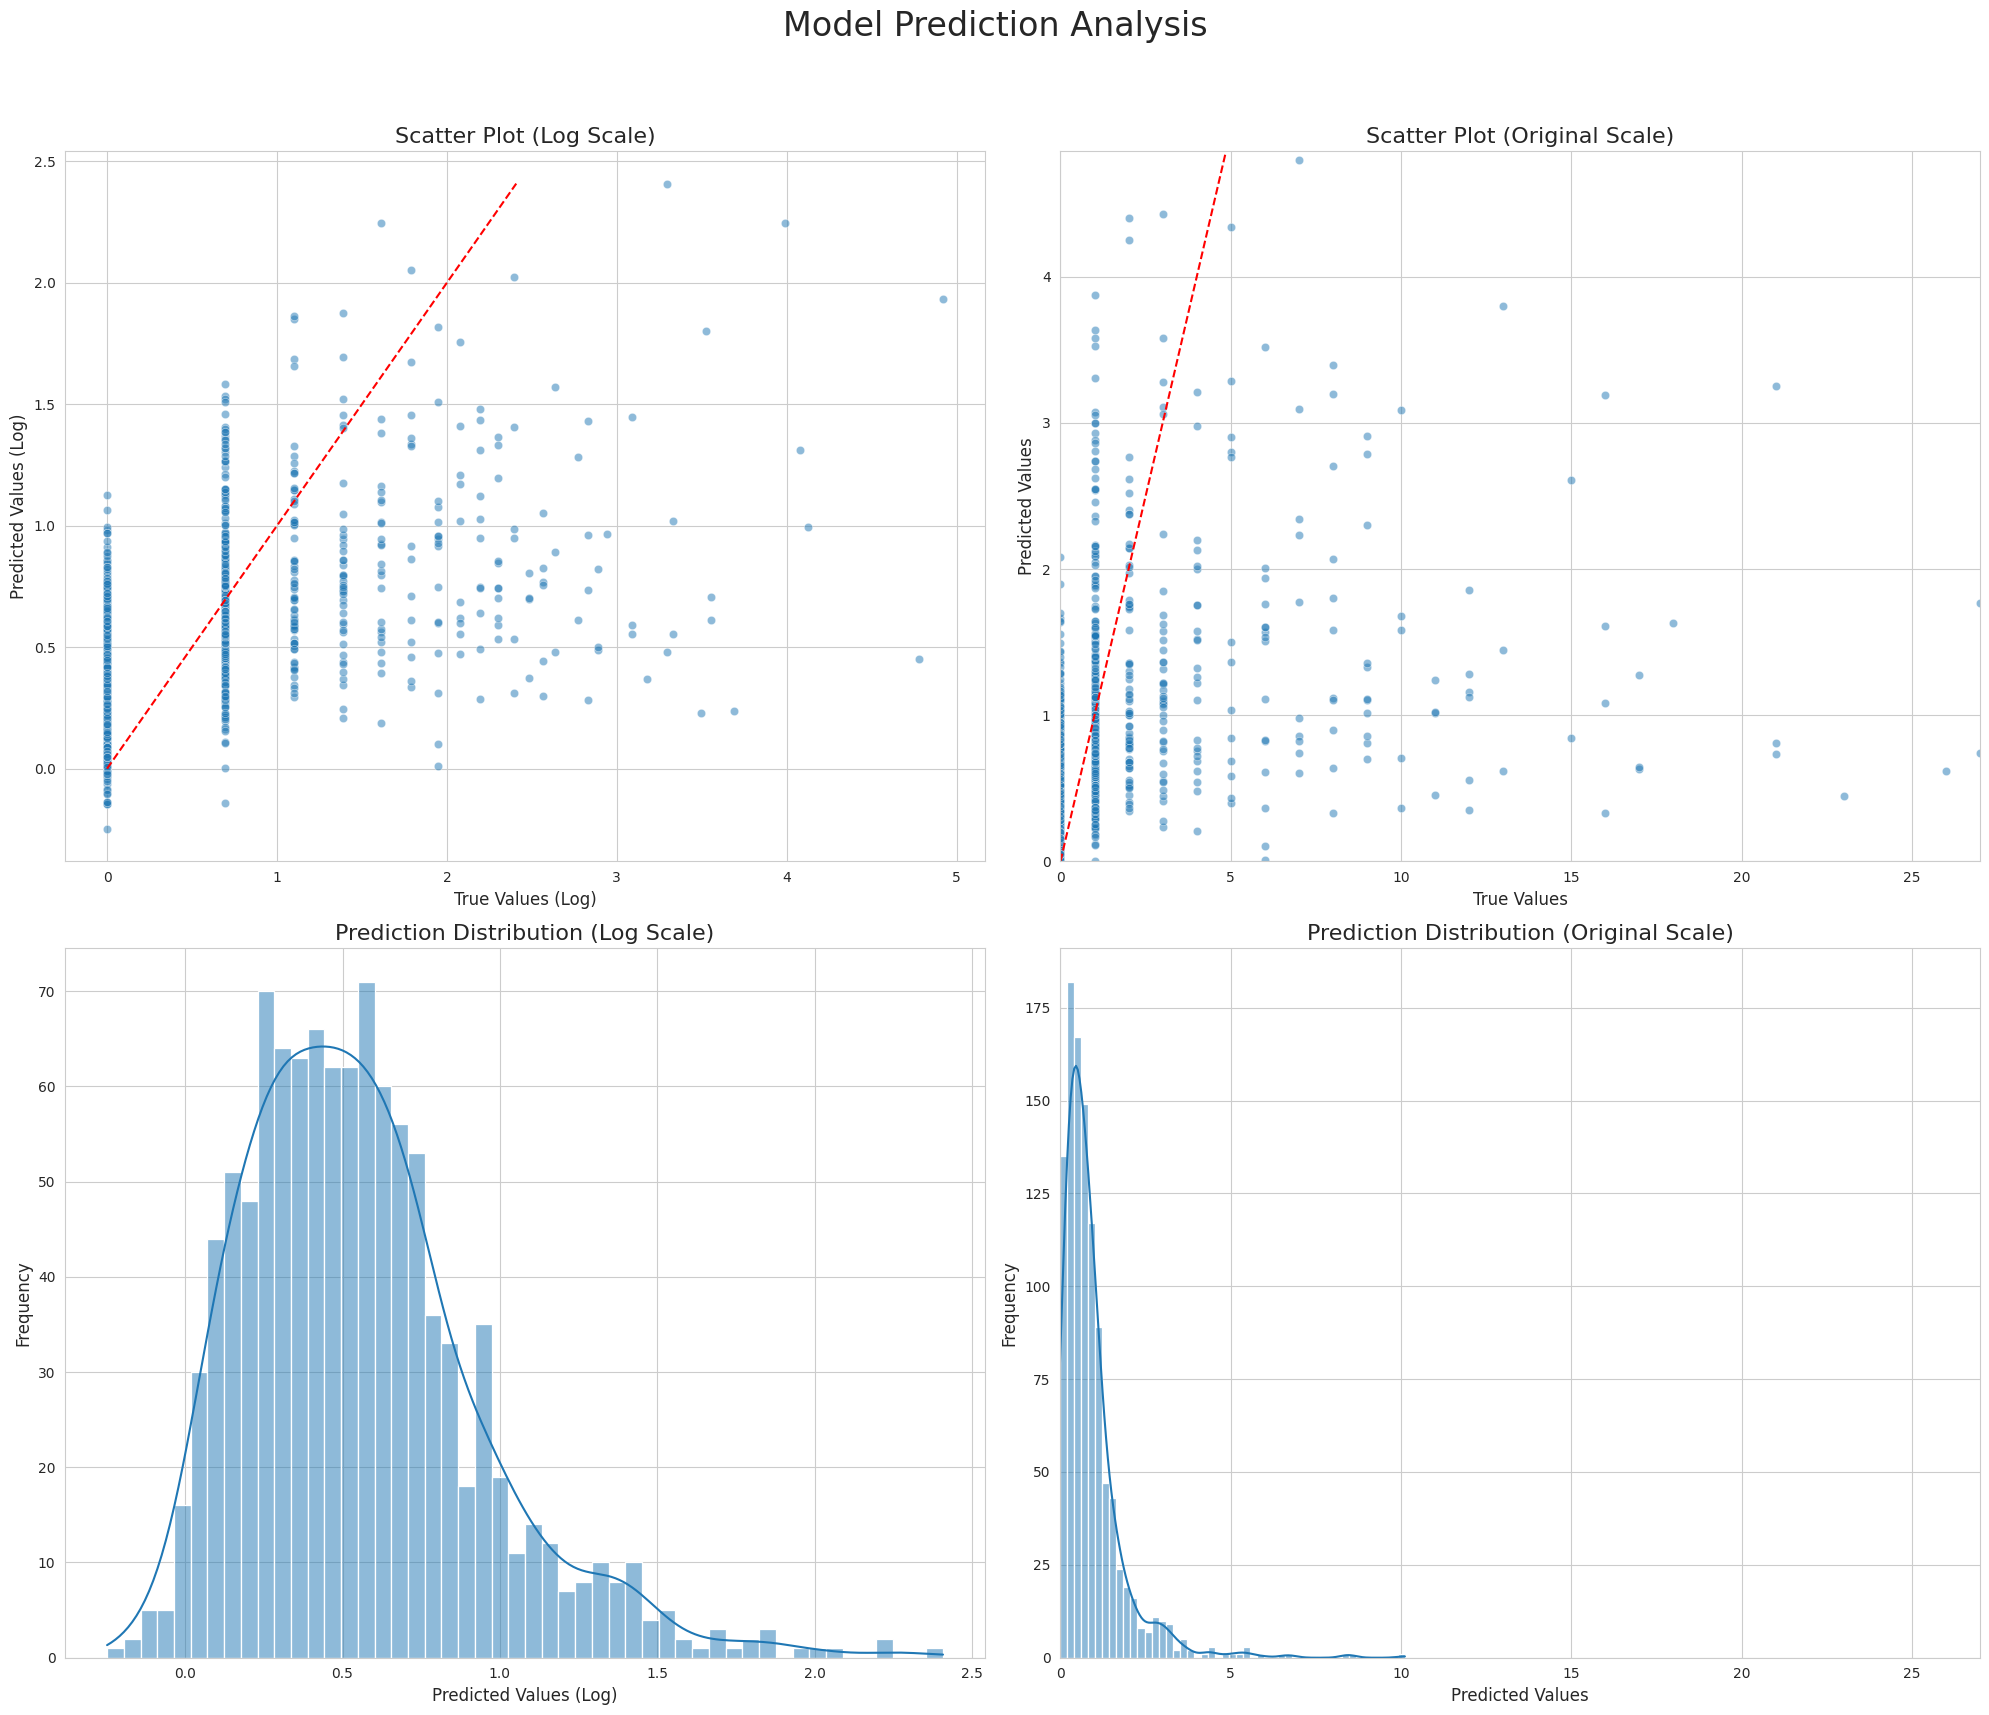

✅ 예측값 및 모델 저장 완료
Model Type: 'TEXT_MLP' 모델 학습 파이프라인

1. 전체 데이터 로드 중...
로드 완료: 121,386개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 10,766개 샘플 (Zero: 5383, Non-Zero: 5383)

3. 데이터 분할 및 정규화 중...

4. 임베더 및 데이터 로더 준비 중...

5. 모델 생성 및 학습 시작...
모델 파라미터 수: 213,377


Epoch 1/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 1 Train Loss (MSE on Log): 0.7257


Epoch 1/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 Validation Results:
  - Log Scale   -> MSE: 0.5560, MAE: 0.5386, RMSE: 0.7456, R²: 0.1444
  - Original Scale -> MSE: 45.8644, MAE: 2.0274, RMSE: 6.7723, R²: -0.0105
✓ Best model updated (Val MAE: 2.0274)


Epoch 2/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 2 Train Loss (MSE on Log): 0.5090


Epoch 2/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 Validation Results:
  - Log Scale   -> MSE: 0.5392, MAE: 0.5118, RMSE: 0.7343, R²: 0.1702
  - Original Scale -> MSE: 45.6809, MAE: 1.9920, RMSE: 6.7588, R²: -0.0065
✓ Best model updated (Val MAE: 1.9920)


Epoch 3/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 3 Train Loss (MSE on Log): 0.4962


Epoch 3/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 Validation Results:
  - Log Scale   -> MSE: 0.5321, MAE: 0.5093, RMSE: 0.7295, R²: 0.1807
  - Original Scale -> MSE: 45.6348, MAE: 1.9866, RMSE: 6.7554, R²: -0.0055
✓ Best model updated (Val MAE: 1.9866)


Epoch 4/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 4 Train Loss (MSE on Log): 0.4885


Epoch 4/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 Validation Results:
  - Log Scale   -> MSE: 0.5241, MAE: 0.5134, RMSE: 0.7239, R²: 0.1932
  - Original Scale -> MSE: 45.2170, MAE: 1.9990, RMSE: 6.7244, R²: 0.0037


Epoch 5/5 [T]:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 5 Train Loss (MSE on Log): 0.4821


Epoch 5/5 [V]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 Validation Results:
  - Log Scale   -> MSE: 0.5210, MAE: 0.5087, RMSE: 0.7218, R²: 0.1979
  - Original Scale -> MSE: 45.0679, MAE: 1.9960, RMSE: 6.7133, R²: 0.0070

6. 최종 테스트 성능 평가 시작
최고 성능 모델을 불러왔습니다.


Final Test:   0%|          | 0/17 [00:00<?, ?it/s]


--- 📝 최종 성능 평가 결과 ---
  [Log Scale]      -> MSE: 0.4053, MAE: 0.4712, RMSE: 0.6366, R²: 0.2215
  [Original Scale] -> MSE: 20.4083, MAE: 1.4728, RMSE: 4.5176, R²: 0.0505
-----------------------------


7. 결과 시각화 데이터 생성 중...


Generating data for visualization:   0%|          | 0/17 [00:00<?, ?it/s]

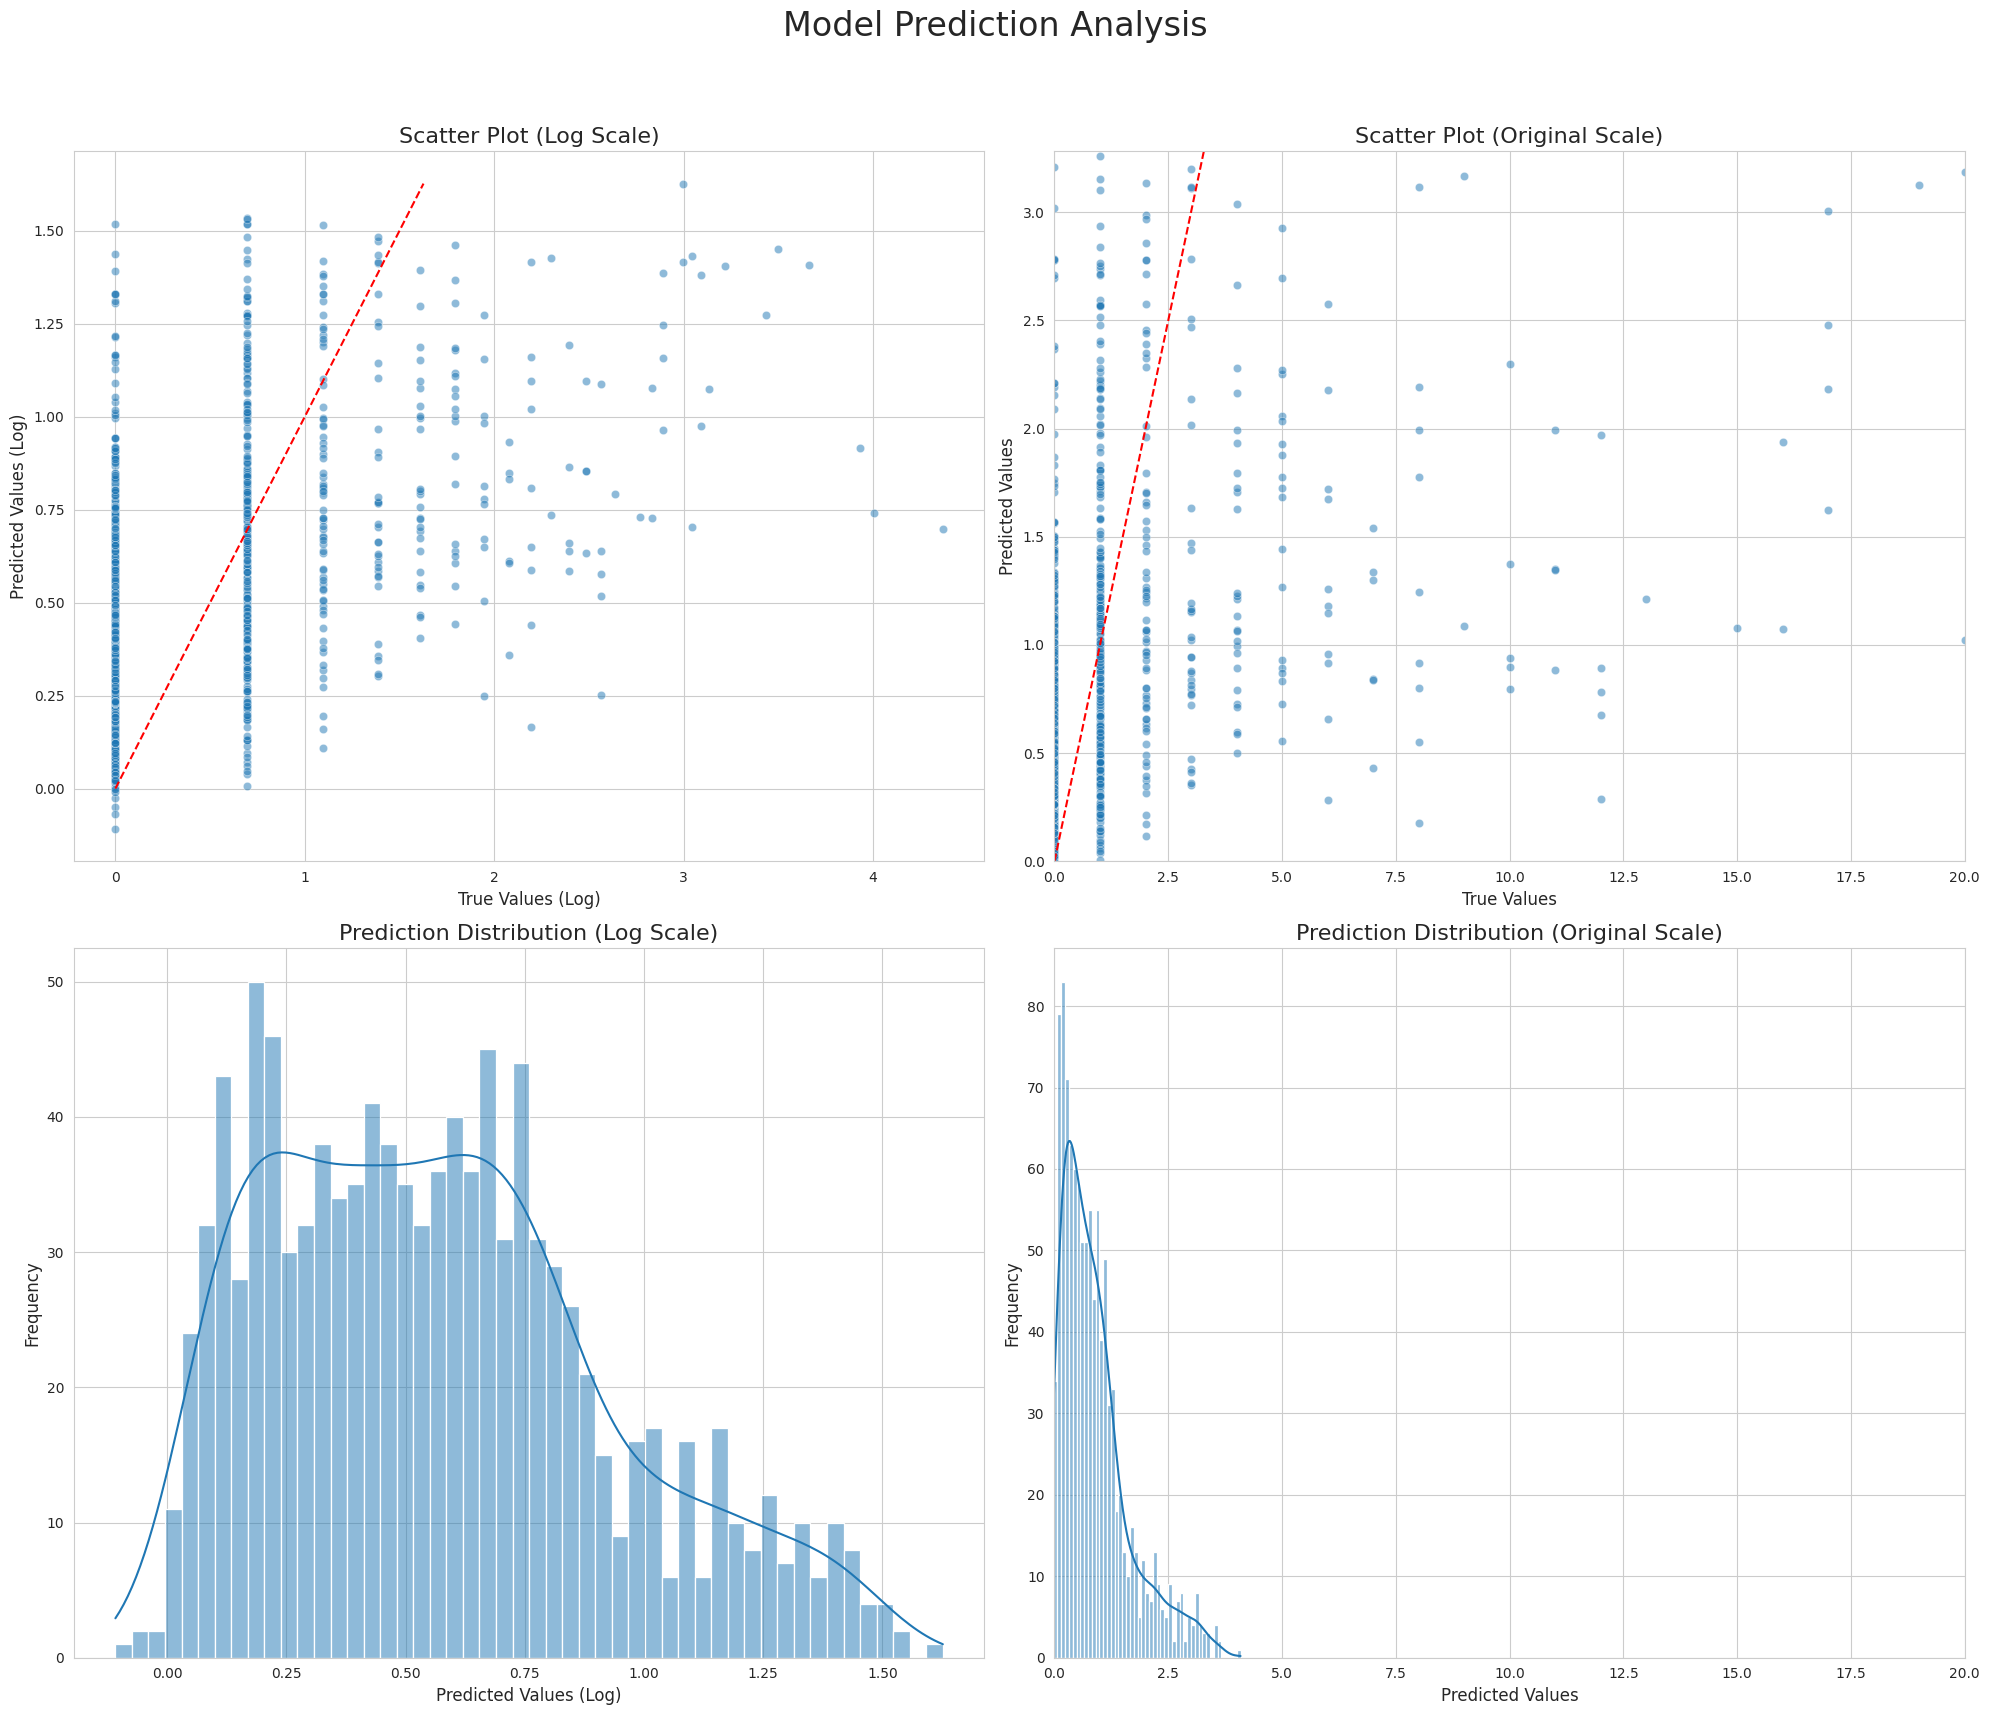


📊 Alpha별 성능 비교:
   alpha   mse_log   mae_log  rmse_log    r2_log   mse_orig  mae_orig  \
0   0.00  0.404998  0.471381  0.636394  0.221523  20.061262  1.469134   
1   0.25  0.419721  0.490323  0.647859  0.193222  20.499519  1.486768   
2   0.50  0.467980  0.522366  0.684090  0.100461  21.003403  1.542900   
3   0.75  0.549756  0.567304  0.741455 -0.056727  21.605679  1.636237   
4   1.00  0.665033  0.622316  0.815495 -0.278309  22.438459  1.763201   

   rmse_orig   r2_orig  
0   4.478980  0.050512  
1   4.527639  0.029770  
2   4.582947  0.005921  
3   4.648191 -0.022584  
4   4.736925 -0.061999  

⭐️ Best Alpha Based on Original Scale R²:
alpha         0.000000
mse_log       0.404998
mae_log       0.471381
rmse_log      0.636394
r2_log        0.221523
mse_orig     20.061262
mae_orig      1.469134
rmse_orig     4.478980
r2_orig       0.050512


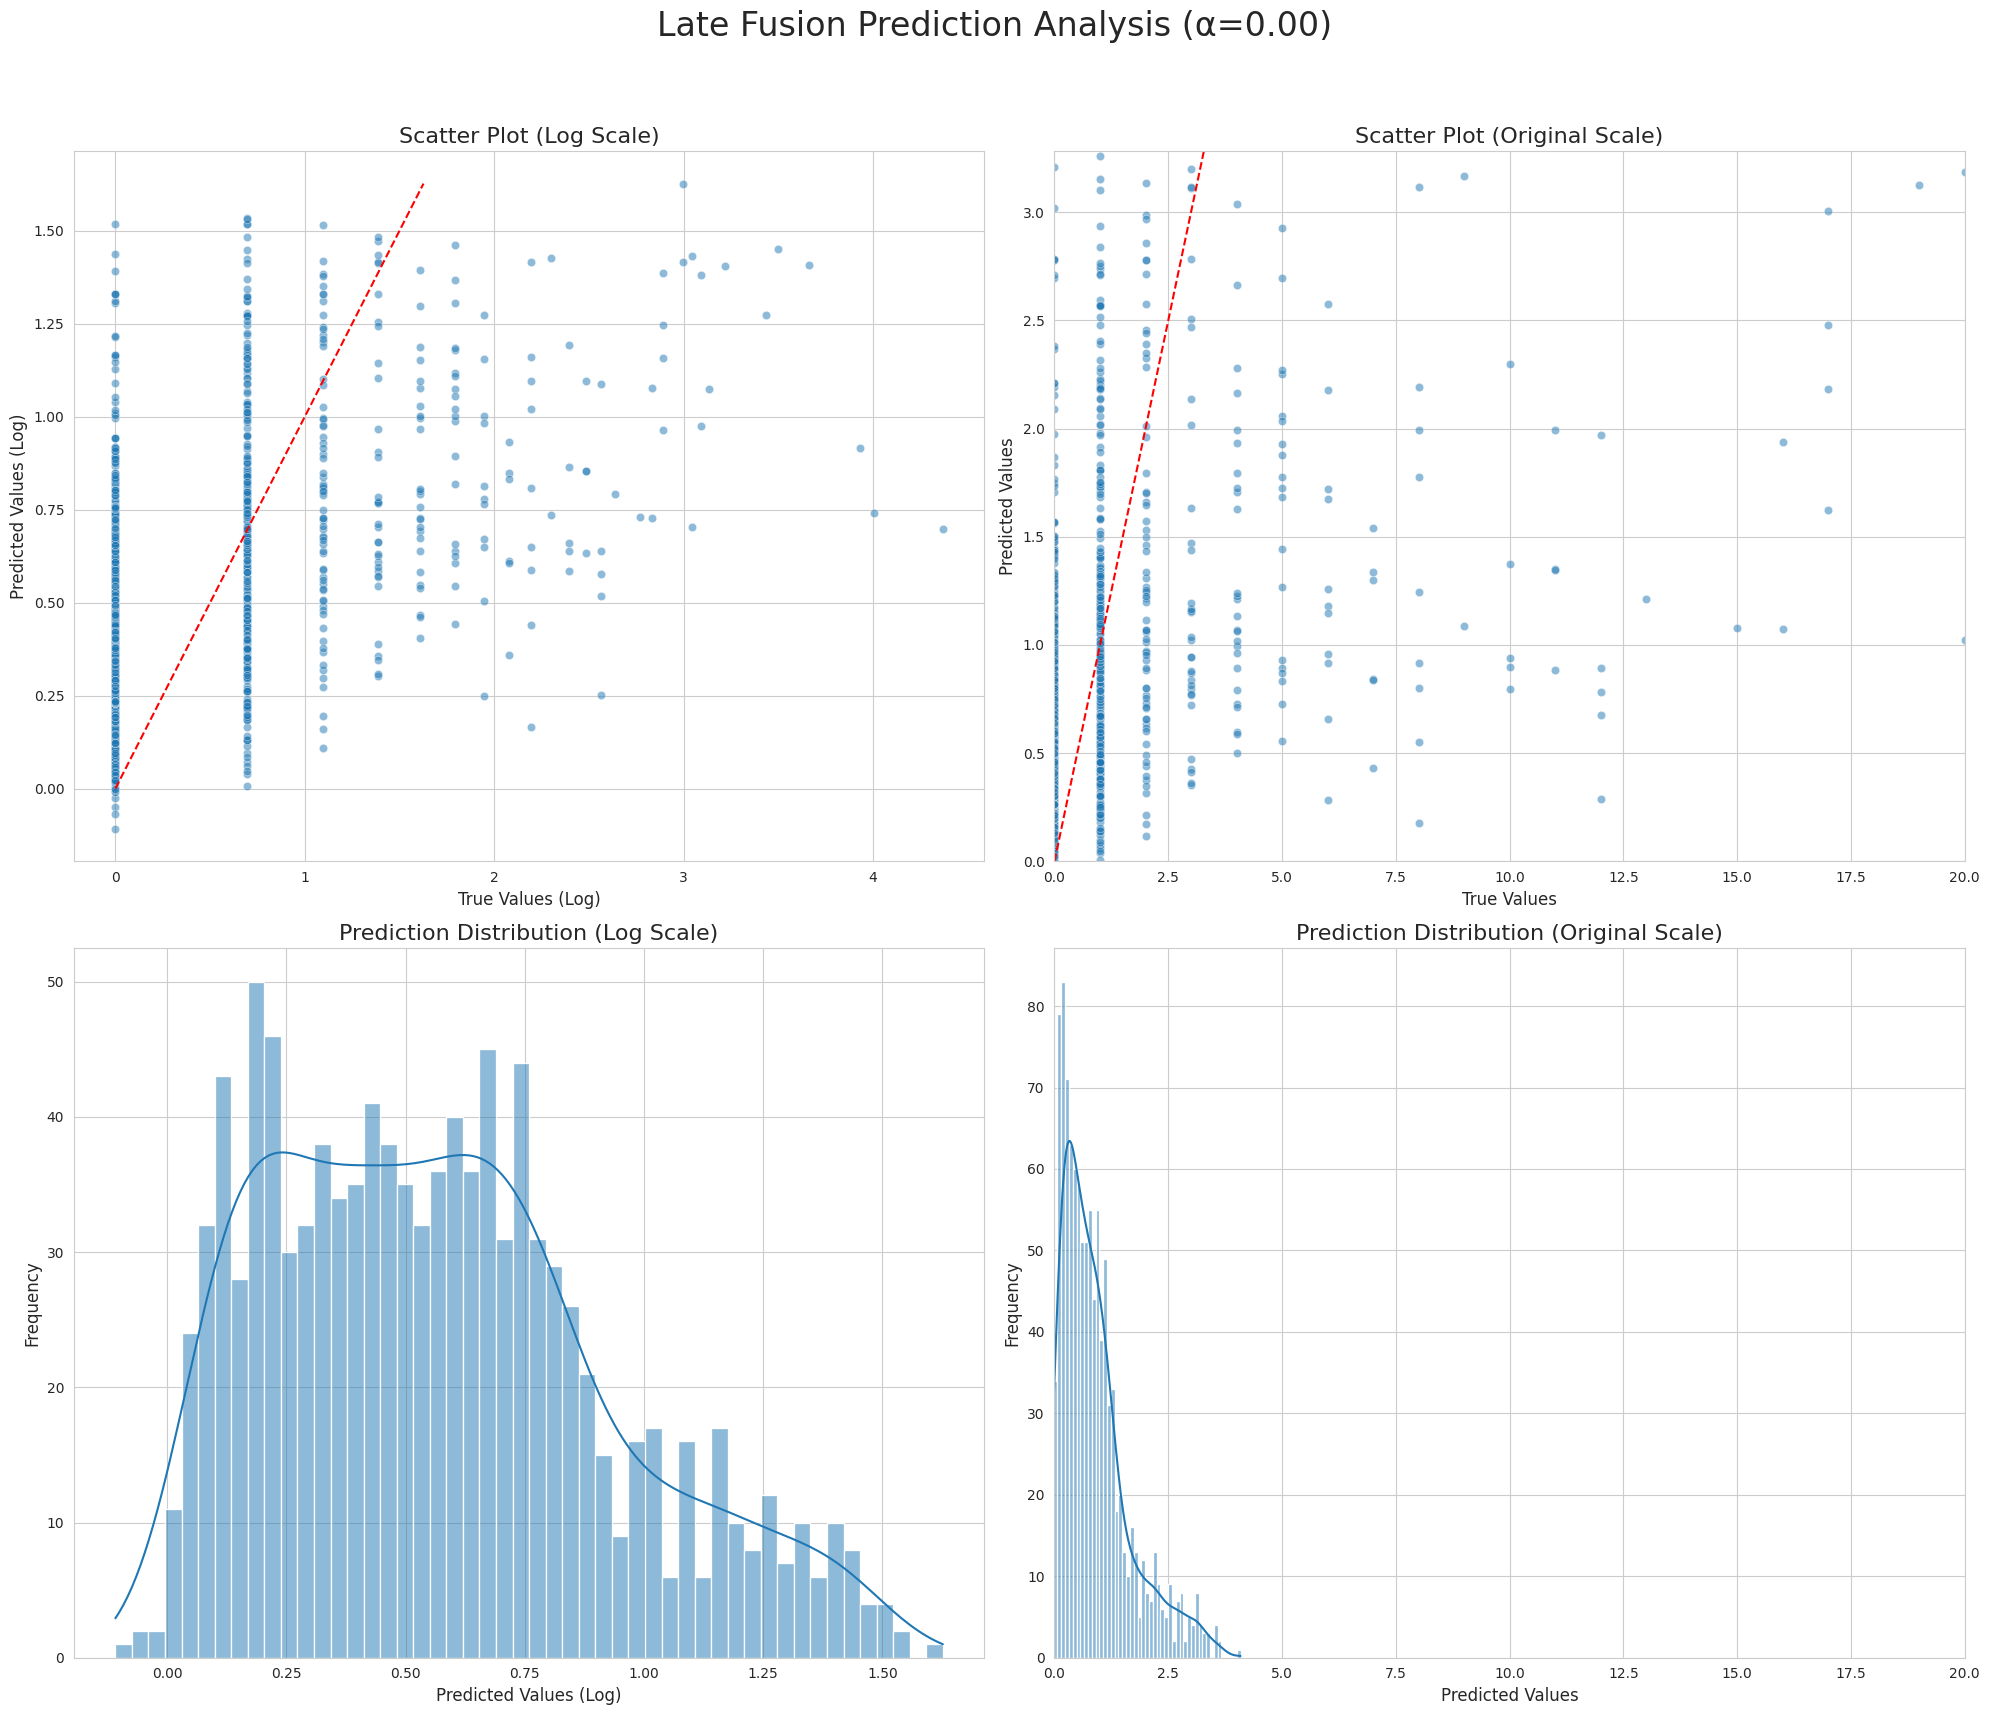

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/coursera.csv"
    FEATURE_COLS = [
                'Average_Rating', 'Num_of_Reviews', 'Num_of_Enrolled',
                'Num_of_top_instructor_courses', 'Num_of_top_instructor_learners',
                'Text_Length', 'Time_Lapsed', 'Deviation_Of_Star_Ratings',
                'Flesch_Reading_Ease', 'new_depth', 'Breadth', 'Valence', 'Arousal'
            ]

try:
    # 🔹 System 1 (Structured Features) 학습 및 저장
    model_s1, embedder, scaler, preds_s1, _, y_true, s1_metrics = main_training_pipeline(
        csv_path=CSV_FILE_PATH,
        text_column="Review_Text",
        target_column="Helpfulness",
        feature_columns=FEATURE_COLS,
        batch_size=64,
        epochs=5,
        learning_rate=5e-5,
        model_type="feature_mlp",

    )
    # 예측값 저장
    if preds_s1 is not None:
        np.save("cousera_preds_s1.npy", preds_s1)
        np.save("cousera_y_true.npy", y_true)
        torch.save(model_s1.state_dict(), "cousera_best_model_FEATURE_MLP.pt")
        print("✅ 예측값 및 모델 저장 완료")

    # 🔹 System 2 (Text Embedding) 학습 및 저장
    model_s2, embedder_s2, scaler_s2, _, preds_s2, y_true, s2_metrics= main_training_pipeline(
      csv_path=CSV_FILE_PATH,
      text_column="Review_Text",
      target_column="Helpfulness",
      feature_columns=FEATURE_COLS,
      batch_size=64,
      epochs=5,
      learning_rate=5e-5,
      model_type="text_mlp",

    )
    if preds_s2 is not None:
      np.save("cousera_preds_s2.npy", preds_s2)


    # 🔹 Late Fusion 평가
    ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
    results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
    print("\n📊 Alpha별 성능 비교:")
    print(results_df)

    best_result = ensembler.get_best_result()
    best_alpha = best_result['alpha']

    print("\n⭐️ Best Alpha Based on Original Scale R²:")
    print(best_result.to_string(index=True))

    # 🔸 Late Fusion 시각화 (log scale 기준 예측값 사용)
    visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha)

except FileNotFoundError:
    print("\n" + "=" * 60)
    print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
    print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
    print("=" * 60)

# 이진분류

In [8]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def clear_memory():
    """메모리 정리 유틸리티"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Using device: cuda


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

## coursera

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PADA/Data/coursera.csv")
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
# 🔹 System 1: Feature 기반 MLP
class FeatureOnlyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        return self.mlp(s1)  # s1: structured input

# 🔹 System 2: Text 기반 MLP
class TextOnlyMLP(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        # s2: (batch, seq_len, embedding_dim)
        if s2.dim() == 3:
            s2_mean = s2.mean(dim=1)  # 평균을 seq_len 방향으로
        else:
            s2_mean = s2
        return self.mlp(s2_mean)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class LateFusionEnsembler:
    def __init__(self, alpha_list, thresholds=np.arange(0.1, 0.9, 0.01)):
        self.alpha_list = alpha_list
        self.thresholds = thresholds
        self.results = []

    def evaluate(self, preds_s1, preds_s2, y_true):
        for alpha in self.alpha_list:
            fused_preds = alpha * preds_s1 + (1 - alpha) * preds_s2
            probs = torch.sigmoid(torch.tensor(fused_preds)).numpy()

            # 최적 threshold 찾기
            best_f1, best_thres = 0, 0.5
            for th in self.thresholds:
                preds = (probs >= th).astype(int)
                f1 = f1_score(y_true, preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thres = th

            # best threshold 기준으로 성능 기록
            best_preds = (probs >= best_thres).astype(int)
            acc = accuracy_score(y_true, best_preds)
            prec = precision_score(y_true, best_preds, zero_division=0)
            rec = recall_score(y_true, best_preds, zero_division=0)

            self.results.append({
                'alpha': alpha,
                'threshold': best_thres,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': best_f1
            })

        return pd.DataFrame(self.results)

    def get_best_result(self, metric='f1_score'):
        df = pd.DataFrame(self.results)
        return df.loc[df[metric].idxmax()]

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 텍스트 임베딩 클래스 (BERT 기반)
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i + batch_size]
                    indices_to_update = new_indices[i:i + batch_size]

                    encoded = self.tokenizer(
                        batch_texts,
                        padding='max_length',
                        truncation=True,
                        max_length=self.max_length,
                        return_tensors='pt'
                    )

                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)


# 🔸 이진 분류용 Dataset 클래스
class SimpleDataset(Dataset):
    def __init__(self, s1_features, texts, binary_targets):
        self.s1 = torch.tensor(s1_features, dtype=torch.float32)
        self.texts = texts  # list of strings
        self.targets = torch.tensor(binary_targets, dtype=torch.float32)  # 🔸 BCE용 float 필요

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return {
            's1': self.s1[idx],         # Structured features (S1)
            'text': self.texts[idx],    # Raw text (for BERT embedding)
            'target': self.targets[idx] # Binary label (0 or 1, float32)
        }

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_late_fusion(preds_s1, preds_s2, y_true, alpha, threshold):
    fused_preds = alpha * np.array(preds_s1) + (1 - alpha) * np.array(preds_s2)
    probs = torch.sigmoid(torch.tensor(fused_preds, dtype=torch.float32)).numpy()
    preds = (probs >= threshold).astype(int)  # ✅ best threshold 기반 예측

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix\n(alpha={alpha}, threshold={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def visualize_results(model, test_loader, device):
    """
    이진 분류 모델의 예측 결과를 시각화합니다.
    """
    model.eval()
    all_probs, all_preds, all_targets = [], [], []

    print("\n" + "=" * 60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "=" * 60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            s1 = batch['s1'].to(device)
            s2 = batch['s2'].to(device)
            s2_mask = batch['s2_mask'].to(device)
            targets = batch['target'].cpu().numpy()

            logits = model(s1, s2, s2_mask)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs >= 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets)

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets).astype(int)

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.histplot(all_probs, bins=50, kde=True)
    plt.title("Probability Distribution (Sigmoid Output)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_binary_classification(y_true, y_probs, prefix="model"):
    y_preds = (y_probs >= 0.5).astype(int)

    print(f"\n📋 {prefix.upper()} Classification Report:")
    print(classification_report(y_true, y_preds, digits=4))

    print(f"\n🧩 {prefix.upper()} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_preds)
    print(cm)

def main_training_pipeline_binary(
    csv_path, text_column, target_column, feature_columns,
    model_type='late_fusion',
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000,
):
    print("="*60 + f"\nBinary Classification: '{model_type.upper()}' 모델 학습\n" + "="*60)

    # 1. 데이터 로드 및 이진화
    df = pd.read_csv(csv_path)
    all_features = df[feature_columns].values
    all_texts = df[text_column].fillna('').tolist()
    all_targets = (df[target_column] > 0).astype(int).values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 균형 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    zero_idx = np.where(all_targets == 0)[0]
    one_idx = np.where(all_targets == 1)[0]
    n = min(len(zero_idx), len(one_idx))
    selected_idx = np.random.permutation(np.concatenate([
        np.random.choice(zero_idx, n, replace=False),
        np.random.choice(one_idx, n, replace=False)
    ]))
    X = all_features[selected_idx]
    T = [all_texts[i] for i in selected_idx]
    Y = all_targets[selected_idx]
    print(f"샘플링 완료: {len(Y)}개 샘플 (0: {n}, 1: {n})")

    # 3. 데이터 분할
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)
    X_val, X_test, T_val, T_test, Y_val, Y_test = train_test_split(X_test, T_test, Y_test, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 4. 데이터셋 및 임베더
    embedder = TextEmbedder(cache_size=embedding_cache_size)
    train_dataset = SimpleDataset(X_train, T_train, Y_train)
    val_dataset = SimpleDataset(X_val, T_val, Y_val)
    test_dataset = SimpleDataset(X_test, T_test, Y_test)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        targets = torch.tensor([item['target'] for item in batch], dtype=torch.float32)
        s2_emb, s2_mask = embedder.get_batch_embeddings(texts)
        return {'s1': s1.to(device), 's2': s2_emb.to(device), 's2_mask': s2_mask.to(device), 'target': targets.to(device)}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    def train_and_predict(model):
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()
        scaler_grad = torch.cuda.amp.GradScaler()
        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
                optimizer.zero_grad()
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask'])
                    loss = criterion(logits.squeeze(), batch['target'])
                scaler_grad.scale(loss).backward()
                scaler_grad.step(optimizer)
                scaler_grad.update()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    with torch.amp.autocast(device_type=device.type):
                        logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                        loss = criterion(logits, batch['target'])
                        val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()

        model.load_state_dict(best_model_state)
        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for batch in test_loader:
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                    probs.append(logits.sigmoid().cpu().numpy())
                    targets.append(batch['target'].cpu().numpy())
        return np.concatenate(probs), np.concatenate(targets).astype(int)

    if model_type == 'late_fusion':
        model_s1 = FeatureOnlyMLP(len(feature_columns)).to(device)
        model_s2 = TextOnlyMLP(embedding_dim=768).to(device)

        print("\n🔹 FEATURE MLP 학습")
        y_pred_s1, y_true = train_and_predict(model_s1)
        print("\n🔹 TEXT MLP 학습")
        y_pred_s2, _ = train_and_predict(model_s2)

        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(y_pred_s1, y_pred_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_thresh = best_result['threshold']

        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result)

        # ✅ 최적 alpha로 fusion 후, 성능 평가 및 시각화
        fused_probs = best_alpha * y_pred_s1 + (1 - best_alpha) * y_pred_s2
        preds = (fused_probs >= best_thresh).astype(int)

        print("\n📋 Best Alpha + Threshold Classification Report:")
        print(classification_report(y_true, preds, digits=4))

        print("\n🧩 Confusion Matrix:")
        print(confusion_matrix(y_true, preds))

        # ✅ ROC Curve & Confusion Matrix 시각화
        visualize_late_fusion(y_pred_s1, y_pred_s2, y_true, best_alpha)

        return model_s1, model_s2, ensembler, results_df

    else:
        model = FeatureOnlyMLP(len(feature_columns)).to(device) if model_type == 'feature_mlp' else TextOnlyMLP(embedding_dim=768).to(device)
        y_probs, y_true = train_and_predict(model)
        # 🎯 최적 threshold 탐색
        best_f1 = 0
        best_threshold = 0.5
        for t in np.arange(0.1, 0.9, 0.01):
            preds = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t

        print(f"\n✅ Best Threshold based on F1: {best_threshold:.2f} (F1: {best_f1:.4f})")

        # 📋 최적 threshold 기반 성능 출력
        best_preds = (y_probs >= best_threshold).astype(int)
        print("\n📋 Best Threshold Classification Report:")
        print(classification_report(y_true, best_preds, digits=4))

        print("🧩 Best Threshold Confusion Matrix:")
        print(confusion_matrix(y_true, best_preds))
        evaluate_binary_classification(y_true, y_probs, prefix=f"{model_type}_binary")
        return model, embedder, scaler, y_probs, y_true

Binary Classification: 'FEATURE_MLP' 모델 학습
로드 완료: 121,386개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 10766개 샘플 (0: 5383, 1: 5383)


Epoch 1 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.6150


Epoch 2 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5619


Epoch 3 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5389


Epoch 4 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5297


Epoch 5 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5246

✅ Best Threshold based on F1: 0.41 (F1: 0.7788)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.8153    0.6716    0.7365       539
           1     0.7204    0.8476    0.7788       538

    accuracy                         0.7595      1077
   macro avg     0.7678    0.7596    0.7577      1077
weighted avg     0.7679    0.7595    0.7577      1077

🧩 Best Threshold Confusion Matrix:
[[362 177]
 [ 82 456]]

📋 FEATURE_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.7552    0.7440    0.7495       539
           1     0.7473    0.7584    0.7528       538

    accuracy                         0.7512      1077
   macro avg     0.7512    0.7512    0.7512      1077
weighted avg     0.7512    0.7512    0.7511      1077


🧩 FEATURE_MLP_BINARY Confusion Matrix:
[[401 138]
 [130 408]]
Binary Classification: 'TEXT_MLP' 모델 학습
로드 완료: 121,386개 샘플

2. 데이터

Epoch 1 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.6194


Epoch 2 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5972


Epoch 3 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5928


Epoch 4 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5881


Epoch 5 [Train]:   0%|          | 0/135 [00:00<?, ?it/s]

Validation Loss: 0.5870

✅ Best Threshold based on F1: 0.38 (F1: 0.7407)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.7828    0.6279    0.6969       551
           1     0.6772    0.8175    0.7407       526

    accuracy                         0.7205      1077
   macro avg     0.7300    0.7227    0.7188      1077
weighted avg     0.7312    0.7205    0.7183      1077

🧩 Best Threshold Confusion Matrix:
[[346 205]
 [ 96 430]]

📋 TEXT_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.7172    0.7731    0.7441       551
           1     0.7412    0.6806    0.7096       526

    accuracy                         0.7279      1077
   macro avg     0.7292    0.7269    0.7269      1077
weighted avg     0.7289    0.7279    0.7273      1077


🧩 TEXT_MLP_BINARY Confusion Matrix:
[[426 125]
 [168 358]]

📊 Alpha별 성능 비교:
   alpha  threshold  accuracy  precision    recall  f1_

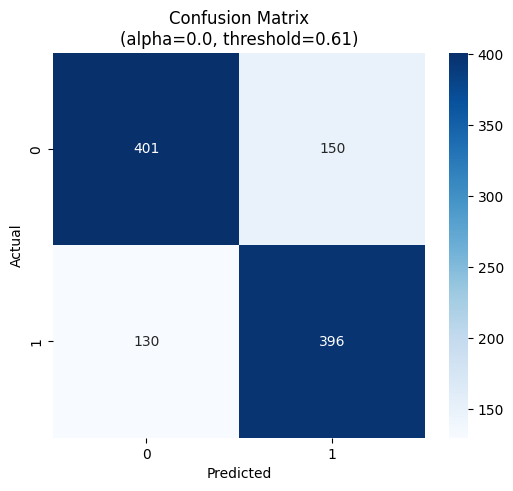

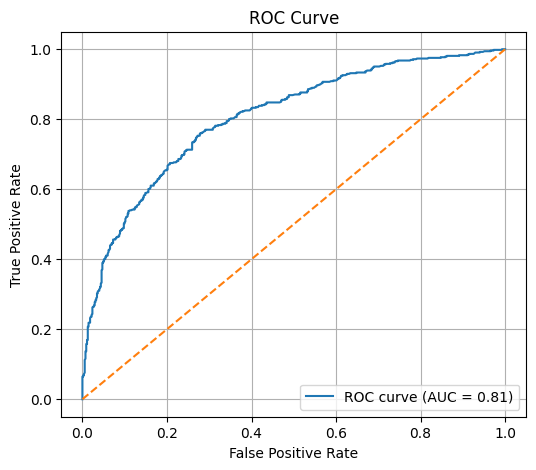

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/coursera.csv"
    FEATURE_COLS = [
        'Average_Rating', 'Num_of_Reviews', 'Num_of_Enrolled',
        'Num_of_top_instructor_courses', 'Num_of_top_instructor_learners',
        'Text_Length', 'Time_Lapsed', 'Deviation_Of_Star_Ratings',
        'Flesch_Reading_Ease', 'new_depth', 'Breadth', 'Valence', 'Arousal'
    ]

    try:
        # 🔹 System 1 (Feature 기반) 이진 분류 모델 학습
        model_s1, embedder, scaler, preds_s1, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="feature_mlp"
        )
        if preds_s1 is not None:
            np.save("coursera_preds_s1.npy", preds_s1)
            np.save("coursera_y_true.npy", y_true)
            torch.save(model_s1.state_dict(), "coursera_best_model_FEATURE_MLP.pt")

        # 🔹 System 2 (Text 기반) 이진 분류 모델 학습
        model_s2, embedder_s2, scaler_s2, preds_s2, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="text_mlp"
        )
        if preds_s2 is not None:
            np.save("coursera_preds_s2.npy", preds_s2)

        # 🔸 이진 분류 Late Fusion 평가
        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_threshold = best_result['threshold']  # ✅ 추가
        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result.to_string(index=True))

        # 📊 시각화
        visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha, best_threshold)
    except FileNotFoundError:
        print("\n" + "=" * 60)
        print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
        print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
        print("=" * 60)

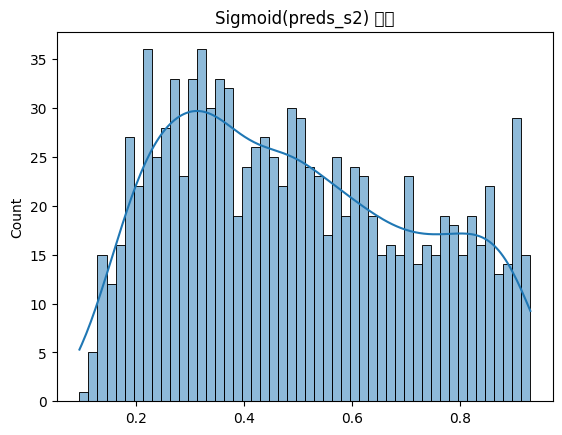

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(preds_s2, bins=50, kde=True)
plt.title("Sigmoid(preds_s2) 분포")
plt.show()

## audible

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PADA/Data/audible.csv")
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
# 🔹 System 1: Feature 기반 MLP
class FeatureOnlyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        return self.mlp(s1)  # s1: structured input

# 🔹 System 2: Text 기반 MLP
class TextOnlyMLP(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        # s2: (batch, seq_len, embedding_dim)
        if s2.dim() == 3:
            s2_mean = s2.mean(dim=1)  # 평균을 seq_len 방향으로
        else:
            s2_mean = s2
        return self.mlp(s2_mean)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class LateFusionEnsembler:
    def __init__(self, alpha_list, thresholds=np.arange(0.1, 0.9, 0.01)):
        self.alpha_list = alpha_list
        self.thresholds = thresholds
        self.results = []

    def evaluate(self, preds_s1, preds_s2, y_true):
        for alpha in self.alpha_list:
            fused_preds = alpha * preds_s1 + (1 - alpha) * preds_s2
            probs = torch.sigmoid(torch.tensor(fused_preds)).numpy()

            # 최적 threshold 찾기
            best_f1, best_thres = 0, 0.5
            for th in self.thresholds:
                preds = (probs >= th).astype(int)
                f1 = f1_score(y_true, preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thres = th

            # best threshold 기준으로 성능 기록
            best_preds = (probs >= best_thres).astype(int)
            acc = accuracy_score(y_true, best_preds)
            prec = precision_score(y_true, best_preds, zero_division=0)
            rec = recall_score(y_true, best_preds, zero_division=0)

            self.results.append({
                'alpha': alpha,
                'threshold': best_thres,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': best_f1
            })

        return pd.DataFrame(self.results)

    def get_best_result(self, metric='f1_score'):
        df = pd.DataFrame(self.results)
        return df.loc[df[metric].idxmax()]

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 텍스트 임베딩 클래스 (BERT 기반)
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i + batch_size]
                    indices_to_update = new_indices[i:i + batch_size]

                    encoded = self.tokenizer(
                        batch_texts,
                        padding='max_length',
                        truncation=True,
                        max_length=self.max_length,
                        return_tensors='pt'
                    )

                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)


# 🔸 이진 분류용 Dataset 클래스
class SimpleDataset(Dataset):
    def __init__(self, s1_features, texts, binary_targets):
        self.s1 = torch.tensor(s1_features, dtype=torch.float32)
        self.texts = texts  # list of strings
        self.targets = torch.tensor(binary_targets, dtype=torch.float32)  # 🔸 BCE용 float 필요

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return {
            's1': self.s1[idx],         # Structured features (S1)
            'text': self.texts[idx],    # Raw text (for BERT embedding)
            'target': self.targets[idx] # Binary label (0 or 1, float32)
        }

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_late_fusion(preds_s1, preds_s2, y_true, alpha, threshold):
    fused_preds = alpha * np.array(preds_s1) + (1 - alpha) * np.array(preds_s2)
    probs = torch.sigmoid(torch.tensor(fused_preds, dtype=torch.float32)).numpy()
    preds = (probs >= threshold).astype(int)  # ✅ best threshold 기반 예측

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix\n(alpha={alpha}, threshold={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def visualize_results(model, test_loader, device):
    """
    이진 분류 모델의 예측 결과를 시각화합니다.
    """
    model.eval()
    all_probs, all_preds, all_targets = [], [], []

    print("\n" + "=" * 60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "=" * 60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            s1 = batch['s1'].to(device)
            s2 = batch['s2'].to(device)
            s2_mask = batch['s2_mask'].to(device)
            targets = batch['target'].cpu().numpy()

            logits = model(s1, s2, s2_mask)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs >= 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets)

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets).astype(int)

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.histplot(all_probs, bins=50, kde=True)
    plt.title("Probability Distribution (Sigmoid Output)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_binary_classification(y_true, y_probs, prefix="model"):
    y_preds = (y_probs >= 0.5).astype(int)

    print(f"\n📋 {prefix.upper()} Classification Report:")
    print(classification_report(y_true, y_preds, digits=4))

    print(f"\n🧩 {prefix.upper()} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_preds)
    print(cm)

def main_training_pipeline_binary(
    csv_path, text_column, target_column, feature_columns,
    model_type='late_fusion',
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000,
):
    print("="*60 + f"\nBinary Classification: '{model_type.upper()}' 모델 학습\n" + "="*60)

    # 1. 데이터 로드 및 이진화
    df = pd.read_csv(csv_path)
    all_features = df[feature_columns].values
    all_texts = df[text_column].fillna('').tolist()
    all_targets = (df[target_column] > 0).astype(int).values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 균형 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    zero_idx = np.where(all_targets == 0)[0]
    one_idx = np.where(all_targets == 1)[0]
    n = min(len(zero_idx), len(one_idx))
    selected_idx = np.random.permutation(np.concatenate([
        np.random.choice(zero_idx, n, replace=False),
        np.random.choice(one_idx, n, replace=False)
    ]))
    X = all_features[selected_idx]
    T = [all_texts[i] for i in selected_idx]
    Y = all_targets[selected_idx]
    print(f"샘플링 완료: {len(Y)}개 샘플 (0: {n}, 1: {n})")

    # 3. 데이터 분할
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)
    X_val, X_test, T_val, T_test, Y_val, Y_test = train_test_split(X_test, T_test, Y_test, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 4. 데이터셋 및 임베더
    embedder = TextEmbedder(cache_size=embedding_cache_size)
    train_dataset = SimpleDataset(X_train, T_train, Y_train)
    val_dataset = SimpleDataset(X_val, T_val, Y_val)
    test_dataset = SimpleDataset(X_test, T_test, Y_test)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        targets = torch.tensor([item['target'] for item in batch], dtype=torch.float32)
        s2_emb, s2_mask = embedder.get_batch_embeddings(texts)
        return {'s1': s1.to(device), 's2': s2_emb.to(device), 's2_mask': s2_mask.to(device), 'target': targets.to(device)}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    def train_and_predict(model):
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()
        scaler_grad = torch.cuda.amp.GradScaler()
        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
                optimizer.zero_grad()
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask'])
                    loss = criterion(logits.squeeze(), batch['target'])
                scaler_grad.scale(loss).backward()
                scaler_grad.step(optimizer)
                scaler_grad.update()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    with torch.amp.autocast(device_type=device.type):
                        logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                        loss = criterion(logits, batch['target'])
                        val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()

        model.load_state_dict(best_model_state)
        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for batch in test_loader:
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                    probs.append(logits.sigmoid().cpu().numpy())
                    targets.append(batch['target'].cpu().numpy())
        return np.concatenate(probs), np.concatenate(targets).astype(int)

    if model_type == 'late_fusion':
        model_s1 = FeatureOnlyMLP(len(feature_columns)).to(device)
        model_s2 = TextOnlyMLP(embedding_dim=768).to(device)

        print("\n🔹 FEATURE MLP 학습")
        y_pred_s1, y_true = train_and_predict(model_s1)
        print("\n🔹 TEXT MLP 학습")
        y_pred_s2, _ = train_and_predict(model_s2)

        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(y_pred_s1, y_pred_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_thresh = best_result['threshold']

        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result)

        # ✅ 최적 alpha로 fusion 후, 성능 평가 및 시각화
        fused_probs = best_alpha * y_pred_s1 + (1 - best_alpha) * y_pred_s2
        preds = (fused_probs >= best_thresh).astype(int)

        print("\n📋 Best Alpha + Threshold Classification Report:")
        print(classification_report(y_true, preds, digits=4))

        print("\n🧩 Confusion Matrix:")
        print(confusion_matrix(y_true, preds))

        # ✅ ROC Curve & Confusion Matrix 시각화
        visualize_late_fusion(y_pred_s1, y_pred_s2, y_true, best_alpha)

        return model_s1, model_s2, ensembler, results_df

    else:
        model = FeatureOnlyMLP(len(feature_columns)).to(device) if model_type == 'feature_mlp' else TextOnlyMLP(embedding_dim=768).to(device)
        y_probs, y_true = train_and_predict(model)
        # 🎯 최적 threshold 탐색
        best_f1 = 0
        best_threshold = 0.5
        for t in np.arange(0.1, 0.9, 0.01):
            preds = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t

        print(f"\n✅ Best Threshold based on F1: {best_threshold:.2f} (F1: {best_f1:.4f})")

        # 📋 최적 threshold 기반 성능 출력
        best_preds = (y_probs >= best_threshold).astype(int)
        print("\n📋 Best Threshold Classification Report:")
        print(classification_report(y_true, best_preds, digits=4))

        print("🧩 Best Threshold Confusion Matrix:")
        print(confusion_matrix(y_true, best_preds))
        evaluate_binary_classification(y_true, y_probs, prefix=f"{model_type}_binary")
        return model, embedder, scaler, y_probs, y_true

Binary Classification: 'FEATURE_MLP' 모델 학습
로드 완료: 92,989개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 13632개 샘플 (0: 6816, 1: 6816)


Epoch 1 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6554


Epoch 2 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6302


Epoch 3 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6221


Epoch 4 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6191


Epoch 5 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6179

✅ Best Threshold based on F1: 0.33 (F1: 0.7075)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.7938    0.3018    0.4373       676
           1     0.5736    0.9230    0.7075       688

    accuracy                         0.6151      1364
   macro avg     0.6837    0.6124    0.5724      1364
weighted avg     0.6827    0.6151    0.5736      1364

🧩 Best Threshold Confusion Matrix:
[[204 472]
 [ 53 635]]

📋 FEATURE_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.6467    0.6879    0.6667       676
           1     0.6729    0.6308    0.6512       688

    accuracy                         0.6591      1364
   macro avg     0.6598    0.6593    0.6589      1364
weighted avg     0.6599    0.6591    0.6588      1364


🧩 FEATURE_MLP_BINARY Confusion Matrix:
[[465 211]
 [254 434]]
Binary Classification: 'TEXT_MLP' 모델 학습
로드 완료: 92,989개 샘플

2. 데이터 

Epoch 1 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6724


Epoch 2 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6641


Epoch 3 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6600


Epoch 4 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6560


Epoch 5 [Train]:   0%|          | 0/171 [00:00<?, ?it/s]

Validation Loss: 0.6533

✅ Best Threshold based on F1: 0.39 (F1: 0.6825)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.6883    0.3769    0.4871       674
           1     0.5779    0.8333    0.6825       690

    accuracy                         0.6078      1364
   macro avg     0.6331    0.6051    0.5848      1364
weighted avg     0.6325    0.6078    0.5859      1364

🧩 Best Threshold Confusion Matrix:
[[254 420]
 [115 575]]

📋 TEXT_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.5990    0.7047    0.6476       674
           1     0.6515    0.5391    0.5900       690

    accuracy                         0.6210      1364
   macro avg     0.6252    0.6219    0.6188      1364
weighted avg     0.6255    0.6210    0.6185      1364


🧩 TEXT_MLP_BINARY Confusion Matrix:
[[475 199]
 [318 372]]

📊 Alpha별 성능 비교:
   alpha  threshold  accuracy  precision    recall  f1_

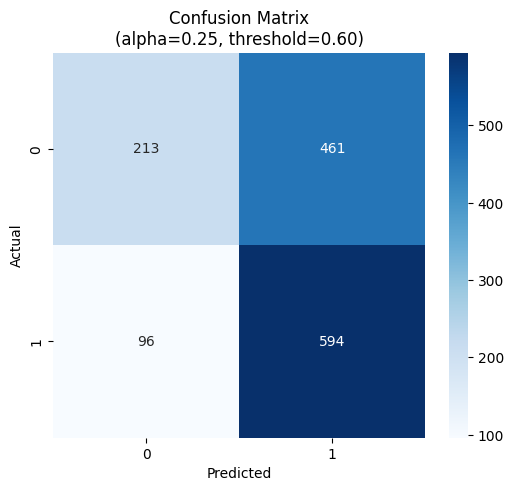

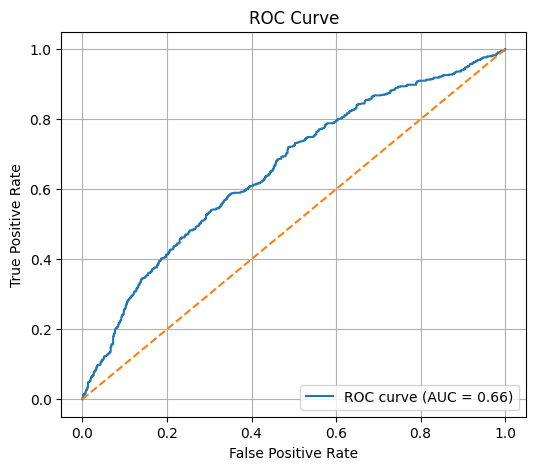

In [ ]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/audible.csv"
    FEATURE_COLS = ['Rating', 'Average_Rating',
       'Num_of_Ratings',
       'Title_Length', 'Text_Length', 'Time_Lapsed',
       'Deviation_Of_Star_Ratings', 'FOG_Index', 'Flesch_Reading_Ease',
       'Depth', 'Breadth', 'Valence', 'Arousal']

    try:
        # 🔹 System 1 (Feature 기반) 이진 분류 모델 학습
        model_s1, embedder, scaler, preds_s1, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="feature_mlp"
        )
        if preds_s1 is not None:
            np.save("audible_preds_s1.npy", preds_s1)
            np.save("audible_y_true.npy", y_true)
            torch.save(model_s1.state_dict(), "audible_best_model_FEATURE_MLP.pt")

        # 🔹 System 2 (Text 기반) 이진 분류 모델 학습
        model_s2, embedder_s2, scaler_s2, preds_s2, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="text_mlp"
        )
        if preds_s2 is not None:
            np.save("audible_preds_s2.npy", preds_s2)

        # 🔸 이진 분류 Late Fusion 평가
        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_threshold = best_result['threshold']  # ✅ 추가
        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result.to_string(index=True))

        # 📊 시각화
        visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha, best_threshold)
    except FileNotFoundError:
        print("\n" + "=" * 60)
        print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
        print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
        print("=" * 60)

## hotel

In [12]:
df = pd.read_csv("/content/drive/MyDrive/PADA/Data/hotel.csv")
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [13]:
# 🔹 System 1: Feature 기반 MLP
class FeatureOnlyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        return self.mlp(s1)  # s1: structured input

# 🔹 System 2: Text 기반 MLP
class TextOnlyMLP(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        # s2: (batch, seq_len, embedding_dim)
        if s2.dim() == 3:
            s2_mean = s2.mean(dim=1)  # 평균을 seq_len 방향으로
        else:
            s2_mean = s2
        return self.mlp(s2_mean)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class LateFusionEnsembler:
    def __init__(self, alpha_list, thresholds=np.arange(0.1, 0.9, 0.01)):
        self.alpha_list = alpha_list
        self.thresholds = thresholds
        self.results = []

    def evaluate(self, preds_s1, preds_s2, y_true):
        for alpha in self.alpha_list:
            fused_preds = alpha * preds_s1 + (1 - alpha) * preds_s2
            probs = torch.sigmoid(torch.tensor(fused_preds)).numpy()

            # 최적 threshold 찾기
            best_f1, best_thres = 0, 0.5
            for th in self.thresholds:
                preds = (probs >= th).astype(int)
                f1 = f1_score(y_true, preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thres = th

            # best threshold 기준으로 성능 기록
            best_preds = (probs >= best_thres).astype(int)
            acc = accuracy_score(y_true, best_preds)
            prec = precision_score(y_true, best_preds, zero_division=0)
            rec = recall_score(y_true, best_preds, zero_division=0)

            self.results.append({
                'alpha': alpha,
                'threshold': best_thres,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': best_f1
            })

        return pd.DataFrame(self.results)

    def get_best_result(self, metric='f1_score'):
        df = pd.DataFrame(self.results)
        return df.loc[df[metric].idxmax()]

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 텍스트 임베딩 클래스 (BERT 기반)
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i + batch_size]
                    indices_to_update = new_indices[i:i + batch_size]

                    encoded = self.tokenizer(
                        batch_texts,
                        padding='max_length',
                        truncation=True,
                        max_length=self.max_length,
                        return_tensors='pt'
                    )

                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)


# 🔸 이진 분류용 Dataset 클래스
class SimpleDataset(Dataset):
    def __init__(self, s1_features, texts, binary_targets):
        self.s1 = torch.tensor(s1_features, dtype=torch.float32)
        self.texts = texts  # list of strings
        self.targets = torch.tensor(binary_targets, dtype=torch.float32)  # 🔸 BCE용 float 필요

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return {
            's1': self.s1[idx],         # Structured features (S1)
            'text': self.texts[idx],    # Raw text (for BERT embedding)
            'target': self.targets[idx] # Binary label (0 or 1, float32)
        }

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_late_fusion(preds_s1, preds_s2, y_true, alpha, threshold):
    fused_preds = alpha * np.array(preds_s1) + (1 - alpha) * np.array(preds_s2)
    probs = torch.sigmoid(torch.tensor(fused_preds, dtype=torch.float32)).numpy()
    preds = (probs >= threshold).astype(int)  # ✅ best threshold 기반 예측

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix\n(alpha={alpha}, threshold={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def visualize_results(model, test_loader, device):
    """
    이진 분류 모델의 예측 결과를 시각화합니다.
    """
    model.eval()
    all_probs, all_preds, all_targets = [], [], []

    print("\n" + "=" * 60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "=" * 60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            s1 = batch['s1'].to(device)
            s2 = batch['s2'].to(device)
            s2_mask = batch['s2_mask'].to(device)
            targets = batch['target'].cpu().numpy()

            logits = model(s1, s2, s2_mask)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs >= 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets)

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets).astype(int)

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.histplot(all_probs, bins=50, kde=True)
    plt.title("Probability Distribution (Sigmoid Output)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_binary_classification(y_true, y_probs, prefix="model"):
    y_preds = (y_probs >= 0.5).astype(int)

    print(f"\n📋 {prefix.upper()} Classification Report:")
    print(classification_report(y_true, y_preds, digits=4))

    print(f"\n🧩 {prefix.upper()} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_preds)
    print(cm)

def main_training_pipeline_binary(
    csv_path, text_column, target_column, feature_columns,
    model_type='late_fusion',
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000,
):
    print("="*60 + f"\nBinary Classification: '{model_type.upper()}' 모델 학습\n" + "="*60)

    # 1. 데이터 로드 및 이진화
    df = pd.read_csv(csv_path)
    all_features = df[feature_columns].values
    all_texts = df[text_column].fillna('').tolist()
    all_targets = (df[target_column] > 0).astype(int).values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 균형 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    zero_idx = np.where(all_targets == 0)[0]
    one_idx = np.where(all_targets == 1)[0]
    n = min(len(zero_idx), len(one_idx))
    selected_idx = np.random.permutation(np.concatenate([
        np.random.choice(zero_idx, n, replace=False),
        np.random.choice(one_idx, n, replace=False)
    ]))
    X = all_features[selected_idx]
    T = [all_texts[i] for i in selected_idx]
    Y = all_targets[selected_idx]
    print(f"샘플링 완료: {len(Y)}개 샘플 (0: {n}, 1: {n})")

    # 3. 데이터 분할
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)
    X_val, X_test, T_val, T_test, Y_val, Y_test = train_test_split(X_test, T_test, Y_test, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 4. 데이터셋 및 임베더
    embedder = TextEmbedder(cache_size=embedding_cache_size)
    train_dataset = SimpleDataset(X_train, T_train, Y_train)
    val_dataset = SimpleDataset(X_val, T_val, Y_val)
    test_dataset = SimpleDataset(X_test, T_test, Y_test)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        targets = torch.tensor([item['target'] for item in batch], dtype=torch.float32)
        s2_emb, s2_mask = embedder.get_batch_embeddings(texts)
        return {'s1': s1.to(device), 's2': s2_emb.to(device), 's2_mask': s2_mask.to(device), 'target': targets.to(device)}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    def train_and_predict(model):
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()
        scaler_grad = torch.cuda.amp.GradScaler()
        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
                optimizer.zero_grad()
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask'])
                    loss = criterion(logits.squeeze(), batch['target'])
                scaler_grad.scale(loss).backward()
                scaler_grad.step(optimizer)
                scaler_grad.update()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    with torch.amp.autocast(device_type=device.type):
                        logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                        loss = criterion(logits, batch['target'])
                        val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()

        model.load_state_dict(best_model_state)
        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for batch in test_loader:
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                    probs.append(logits.sigmoid().cpu().numpy())
                    targets.append(batch['target'].cpu().numpy())
        return np.concatenate(probs), np.concatenate(targets).astype(int)

    if model_type == 'late_fusion':
        model_s1 = FeatureOnlyMLP(len(feature_columns)).to(device)
        model_s2 = TextOnlyMLP(embedding_dim=768).to(device)

        print("\n🔹 FEATURE MLP 학습")
        y_pred_s1, y_true = train_and_predict(model_s1)
        print("\n🔹 TEXT MLP 학습")
        y_pred_s2, _ = train_and_predict(model_s2)

        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(y_pred_s1, y_pred_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_thresh = best_result['threshold']

        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result)

        # ✅ 최적 alpha로 fusion 후, 성능 평가 및 시각화
        fused_probs = best_alpha * y_pred_s1 + (1 - best_alpha) * y_pred_s2
        preds = (fused_probs >= best_thresh).astype(int)

        print("\n📋 Best Alpha + Threshold Classification Report:")
        print(classification_report(y_true, preds, digits=4))

        print("\n🧩 Confusion Matrix:")
        print(confusion_matrix(y_true, preds))

        # ✅ ROC Curve & Confusion Matrix 시각화
        visualize_late_fusion(y_pred_s1, y_pred_s2, y_true, best_alpha)

        return model_s1, model_s2, ensembler, results_df

    else:
        model = FeatureOnlyMLP(len(feature_columns)).to(device) if model_type == 'feature_mlp' else TextOnlyMLP(embedding_dim=768).to(device)
        y_probs, y_true = train_and_predict(model)
        # 🎯 최적 threshold 탐색
        best_f1 = 0
        best_threshold = 0.5
        for t in np.arange(0.1, 0.9, 0.01):
            preds = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t

        print(f"\n✅ Best Threshold based on F1: {best_threshold:.2f} (F1: {best_f1:.4f})")

        # 📋 최적 threshold 기반 성능 출력
        best_preds = (y_probs >= best_threshold).astype(int)
        print("\n📋 Best Threshold Classification Report:")
        print(classification_report(y_true, best_preds, digits=4))

        print("🧩 Best Threshold Confusion Matrix:")
        print(confusion_matrix(y_true, best_preds))
        evaluate_binary_classification(y_true, y_probs, prefix=f"{model_type}_binary")
        return model, embedder, scaler, y_probs, y_true

Binary Classification: 'FEATURE_MLP' 모델 학습
로드 완료: 89,505개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 16466개 샘플 (0: 8233, 1: 8233)


Epoch 1 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6727


Epoch 2 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6639


Epoch 3 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6602


Epoch 4 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6582


Epoch 5 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6564

✅ Best Threshold based on F1: 0.31 (F1: 0.6487)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.7321    0.0476    0.0894       861
           1     0.4846    0.9809    0.6487       786

    accuracy                         0.4930      1647
   macro avg     0.6084    0.5143    0.3691      1647
weighted avg     0.6140    0.4930    0.3563      1647

🧩 Best Threshold Confusion Matrix:
[[ 41 820]
 [ 15 771]]

📋 FEATURE_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.6377    0.6051    0.6210       861
           1     0.5904    0.6234    0.6064       786

    accuracy                         0.6138      1647
   macro avg     0.6140    0.6143    0.6137      1647
weighted avg     0.6151    0.6138    0.6140      1647


🧩 FEATURE_MLP_BINARY Confusion Matrix:
[[521 340]
 [296 490]]
Binary Classification: 'TEXT_MLP' 모델 학습
로드 완료: 89,505개 샘플

2. 데이터 

Epoch 1 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6729


Epoch 2 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6699


Epoch 3 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6693


Epoch 4 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6669


Epoch 5 [Train]:   0%|          | 0/206 [00:00<?, ?it/s]

Validation Loss: 0.6662

✅ Best Threshold based on F1: 0.39 (F1: 0.6881)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.7247    0.2213    0.3390       809
           1     0.5500    0.9189    0.6881       838

    accuracy                         0.5762      1647
   macro avg     0.6373    0.5701    0.5136      1647
weighted avg     0.6358    0.5762    0.5166      1647

🧩 Best Threshold Confusion Matrix:
[[179 630]
 [ 68 770]]

📋 TEXT_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.5911    0.6057    0.5983       809
           1     0.6100    0.5955    0.6027       838

    accuracy                         0.6005      1647
   macro avg     0.6005    0.6006    0.6005      1647
weighted avg     0.6007    0.6005    0.6005      1647


🧩 TEXT_MLP_BINARY Confusion Matrix:
[[490 319]
 [339 499]]

📊 Alpha별 성능 비교:
   alpha  threshold  accuracy  precision    recall  f1_

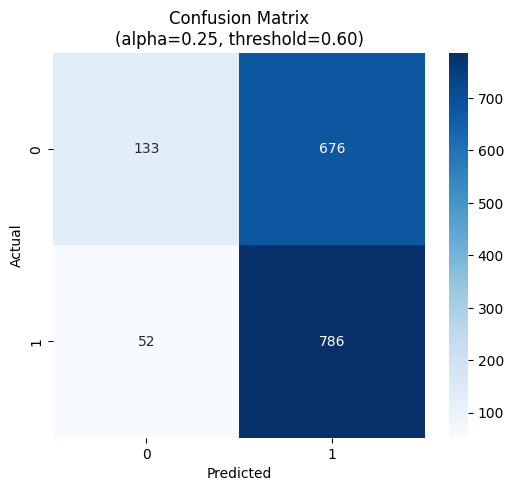

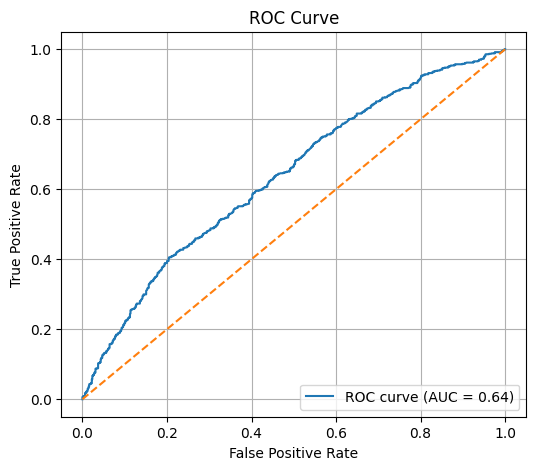

In [14]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/hotel.csv"
    FEATURE_COLS = ['Rating', 'Average_Rating',
       'Num_of_Ratings', 'Is_Photo',
       'Hotel_Grade', 'Employee_Friendliness_Score', 'Facility_Score',
       'Cleanliness_Score', 'Comfort_Score', 'Value_For_Money_Score',
       'Location_Score', 'Title_Length', 'Text_Length',
       'Time_Lapsed', 'Deviation_Of_Star_Ratings', 'FOG_Index',
       'Flesch_Reading_Ease', 'Depth', 'Breadth', 'Valence', 'Arousal'
       ]

    try:
        # 🔹 System 1 (Feature 기반) 이진 분류 모델 학습
        model_s1, embedder, scaler, preds_s1, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="feature_mlp"
        )
        if preds_s1 is not None:
            np.save("hotel_preds_s1.npy", preds_s1)
            np.save("hotel_y_true.npy", y_true)
            torch.save(model_s1.state_dict(), "hotel_best_model_FEATURE_MLP.pt")

        # 🔹 System 2 (Text 기반) 이진 분류 모델 학습
        model_s2, embedder_s2, scaler_s2, preds_s2, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="text_mlp"
        )
        if preds_s2 is not None:
            np.save("hotel_preds_s2.npy", preds_s2)

        # 🔸 이진 분류 Late Fusion 평가
        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_threshold = best_result['threshold']  # ✅ 추가
        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result.to_string(index=True))

        # 📊 시각화
        visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha, best_threshold)
    except FileNotFoundError:
        print("\n" + "=" * 60)
        print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
        print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
        print("=" * 60)

## amazon

In [15]:
df = pd.read_csv("/content/drive/MyDrive/PADA/Data/amazon.csv")
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [16]:
# 🔹 System 1: Feature 기반 MLP
class FeatureOnlyMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        return self.mlp(s1)  # s1: structured input

# 🔹 System 2: Text 기반 MLP
class TextOnlyMLP(nn.Module):
    def __init__(self, embedding_dim=768):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, s1, s2, s2_mask):
        # s2: (batch, seq_len, embedding_dim)
        if s2.dim() == 3:
            s2_mean = s2.mean(dim=1)  # 평균을 seq_len 방향으로
        else:
            s2_mean = s2
        return self.mlp(s2_mean)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class LateFusionEnsembler:
    def __init__(self, alpha_list, thresholds=np.arange(0.1, 0.9, 0.01)):
        self.alpha_list = alpha_list
        self.thresholds = thresholds
        self.results = []

    def evaluate(self, preds_s1, preds_s2, y_true):
        for alpha in self.alpha_list:
            fused_preds = alpha * preds_s1 + (1 - alpha) * preds_s2
            probs = torch.sigmoid(torch.tensor(fused_preds)).numpy()

            # 최적 threshold 찾기
            best_f1, best_thres = 0, 0.5
            for th in self.thresholds:
                preds = (probs >= th).astype(int)
                f1 = f1_score(y_true, preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thres = th

            # best threshold 기준으로 성능 기록
            best_preds = (probs >= best_thres).astype(int)
            acc = accuracy_score(y_true, best_preds)
            prec = precision_score(y_true, best_preds, zero_division=0)
            rec = recall_score(y_true, best_preds, zero_division=0)

            self.results.append({
                'alpha': alpha,
                'threshold': best_thres,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': best_f1
            })

        return pd.DataFrame(self.results)

    def get_best_result(self, metric='f1_score'):
        df = pd.DataFrame(self.results)
        return df.loc[df[metric].idxmax()]

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 텍스트 임베딩 클래스 (BERT 기반)
class TextEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=128, cache_size=5000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        self.max_length = max_length
        self.cache = {}
        self.cache_order = []
        self.cache_size = cache_size

    def get_batch_embeddings(self, texts, batch_size=16):
        results = [None] * len(texts)
        new_indices, new_texts = [], []

        for i, text in enumerate(texts):
            text_hash = hash(text)
            if text_hash in self.cache:
                results[i] = self.cache[text_hash]
            else:
                new_indices.append(i)
                new_texts.append(text)

        if new_texts:
            with torch.no_grad():
                for i in range(0, len(new_texts), batch_size):
                    batch_texts = new_texts[i:i + batch_size]
                    indices_to_update = new_indices[i:i + batch_size]

                    encoded = self.tokenizer(
                        batch_texts,
                        padding='max_length',
                        truncation=True,
                        max_length=self.max_length,
                        return_tensors='pt'
                    )

                    outputs = self.model(
                        input_ids=encoded['input_ids'].to(device),
                        attention_mask=encoded['attention_mask'].to(device)
                    )

                    batch_embeddings = outputs.last_hidden_state.cpu()
                    batch_masks = encoded['attention_mask'].cpu()

                    for j in range(len(batch_texts)):
                        emb, mask = batch_embeddings[j], batch_masks[j]
                        results[indices_to_update[j]] = (emb, mask)

                        text_hash = hash(batch_texts[j])
                        if len(self.cache) >= self.cache_size:
                            del self.cache[self.cache_order.pop(0)]
                        self.cache[text_hash] = (emb, mask)
                        self.cache_order.append(text_hash)

        embeddings, masks = zip(*results)
        return torch.stack(embeddings), torch.stack(masks)


# 🔸 이진 분류용 Dataset 클래스
class SimpleDataset(Dataset):
    def __init__(self, s1_features, texts, binary_targets):
        self.s1 = torch.tensor(s1_features, dtype=torch.float32)
        self.texts = texts  # list of strings
        self.targets = torch.tensor(binary_targets, dtype=torch.float32)  # 🔸 BCE용 float 필요

    def __len__(self):
        return len(self.s1)

    def __getitem__(self, idx):
        return {
            's1': self.s1[idx],         # Structured features (S1)
            'text': self.texts[idx],    # Raw text (for BERT embedding)
            'target': self.targets[idx] # Binary label (0 or 1, float32)
        }

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_late_fusion(preds_s1, preds_s2, y_true, alpha, threshold):
    fused_preds = alpha * np.array(preds_s1) + (1 - alpha) * np.array(preds_s2)
    probs = torch.sigmoid(torch.tensor(fused_preds, dtype=torch.float32)).numpy()
    preds = (probs >= threshold).astype(int)  # ✅ best threshold 기반 예측

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix\n(alpha={alpha}, threshold={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def visualize_results(model, test_loader, device):
    """
    이진 분류 모델의 예측 결과를 시각화합니다.
    """
    model.eval()
    all_probs, all_preds, all_targets = [], [], []

    print("\n" + "=" * 60 + "\n7. 결과 시각화 데이터 생성 중...\n" + "=" * 60)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating data for visualization"):
            s1 = batch['s1'].to(device)
            s2 = batch['s2'].to(device)
            s2_mask = batch['s2_mask'].to(device)
            targets = batch['target'].cpu().numpy()

            logits = model(s1, s2, s2_mask)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs >= 0.5).astype(int)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets)

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets).astype(int)

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.histplot(all_probs, bins=50, kde=True)
    plt.title("Probability Distribution (Sigmoid Output)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_binary_classification(y_true, y_probs, prefix="model"):
    y_preds = (y_probs >= 0.5).astype(int)

    print(f"\n📋 {prefix.upper()} Classification Report:")
    print(classification_report(y_true, y_preds, digits=4))

    print(f"\n🧩 {prefix.upper()} Confusion Matrix:")
    cm = confusion_matrix(y_true, y_preds)
    print(cm)

def main_training_pipeline_binary(
    csv_path, text_column, target_column, feature_columns,
    model_type='late_fusion',
    batch_size=32, epochs=20, learning_rate=2e-4,
    csv_chunksize=50000, embedding_cache_size=5000,
):
    print("="*60 + f"\nBinary Classification: '{model_type.upper()}' 모델 학습\n" + "="*60)

    # 1. 데이터 로드 및 이진화
    df = pd.read_csv(csv_path)
    all_features = df[feature_columns].values
    all_texts = df[text_column].fillna('').tolist()
    all_targets = (df[target_column] > 0).astype(int).values
    print(f"로드 완료: {len(all_targets):,}개 샘플")

    # 2. 균형 샘플링
    print("\n2. 데이터 1:1 샘플링 진행 중...")
    zero_idx = np.where(all_targets == 0)[0]
    one_idx = np.where(all_targets == 1)[0]
    n = min(len(zero_idx), len(one_idx))
    selected_idx = np.random.permutation(np.concatenate([
        np.random.choice(zero_idx, n, replace=False),
        np.random.choice(one_idx, n, replace=False)
    ]))
    X = all_features[selected_idx]
    T = [all_texts[i] for i in selected_idx]
    Y = all_targets[selected_idx]
    print(f"샘플링 완료: {len(Y)}개 샘플 (0: {n}, 1: {n})")

    # 3. 데이터 분할
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)
    X_val, X_test, T_val, T_test, Y_val, Y_test = train_test_split(X_test, T_test, Y_test, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 4. 데이터셋 및 임베더
    embedder = TextEmbedder(cache_size=embedding_cache_size)
    train_dataset = SimpleDataset(X_train, T_train, Y_train)
    val_dataset = SimpleDataset(X_val, T_val, Y_val)
    test_dataset = SimpleDataset(X_test, T_test, Y_test)

    def collate_fn(batch):
        s1 = torch.stack([item['s1'] for item in batch])
        texts = [item['text'] for item in batch]
        targets = torch.tensor([item['target'] for item in batch], dtype=torch.float32)
        s2_emb, s2_mask = embedder.get_batch_embeddings(texts)
        return {'s1': s1.to(device), 's2': s2_emb.to(device), 's2_mask': s2_mask.to(device), 'target': targets.to(device)}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    def train_and_predict(model):
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()
        scaler_grad = torch.cuda.amp.GradScaler()
        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
                optimizer.zero_grad()
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask'])
                    loss = criterion(logits.squeeze(), batch['target'])
                scaler_grad.scale(loss).backward()
                scaler_grad.step(optimizer)
                scaler_grad.update()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    with torch.amp.autocast(device_type=device.type):
                        logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                        loss = criterion(logits, batch['target'])
                        val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()

        model.load_state_dict(best_model_state)
        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for batch in test_loader:
                with torch.amp.autocast(device_type=device.type):
                    logits = model(batch['s1'], batch['s2'], batch['s2_mask']).squeeze()
                    probs.append(logits.sigmoid().cpu().numpy())
                    targets.append(batch['target'].cpu().numpy())
        return np.concatenate(probs), np.concatenate(targets).astype(int)

    if model_type == 'late_fusion':
        model_s1 = FeatureOnlyMLP(len(feature_columns)).to(device)
        model_s2 = TextOnlyMLP(embedding_dim=768).to(device)

        print("\n🔹 FEATURE MLP 학습")
        y_pred_s1, y_true = train_and_predict(model_s1)
        print("\n🔹 TEXT MLP 학습")
        y_pred_s2, _ = train_and_predict(model_s2)

        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(y_pred_s1, y_pred_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_thresh = best_result['threshold']

        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result)

        # ✅ 최적 alpha로 fusion 후, 성능 평가 및 시각화
        fused_probs = best_alpha * y_pred_s1 + (1 - best_alpha) * y_pred_s2
        preds = (fused_probs >= best_thresh).astype(int)

        print("\n📋 Best Alpha + Threshold Classification Report:")
        print(classification_report(y_true, preds, digits=4))

        print("\n🧩 Confusion Matrix:")
        print(confusion_matrix(y_true, preds))

        # ✅ ROC Curve & Confusion Matrix 시각화
        visualize_late_fusion(y_pred_s1, y_pred_s2, y_true, best_alpha)

        return model_s1, model_s2, ensembler, results_df

    else:
        model = FeatureOnlyMLP(len(feature_columns)).to(device) if model_type == 'feature_mlp' else TextOnlyMLP(embedding_dim=768).to(device)
        y_probs, y_true = train_and_predict(model)
        # 🎯 최적 threshold 탐색
        best_f1 = 0
        best_threshold = 0.5
        for t in np.arange(0.1, 0.9, 0.01):
            preds = (y_probs >= t).astype(int)
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t

        print(f"\n✅ Best Threshold based on F1: {best_threshold:.2f} (F1: {best_f1:.4f})")

        # 📋 최적 threshold 기반 성능 출력
        best_preds = (y_probs >= best_threshold).astype(int)
        print("\n📋 Best Threshold Classification Report:")
        print(classification_report(y_true, best_preds, digits=4))

        print("🧩 Best Threshold Confusion Matrix:")
        print(confusion_matrix(y_true, best_preds))
        evaluate_binary_classification(y_true, y_probs, prefix=f"{model_type}_binary")
        return model, embedder, scaler, y_probs, y_true

Binary Classification: 'FEATURE_MLP' 모델 학습
로드 완료: 89,927개 샘플

2. 데이터 1:1 샘플링 진행 중...
샘플링 완료: 17690개 샘플 (0: 8845, 1: 8845)


Epoch 1 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5968


Epoch 2 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5677


Epoch 3 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5604


Epoch 4 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5572


Epoch 5 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5550

✅ Best Threshold based on F1: 0.30 (F1: 0.7388)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.8209    0.5127    0.6312       903
           1     0.6349    0.8834    0.7388       866

    accuracy                         0.6942      1769
   macro avg     0.7279    0.6981    0.6850      1769
weighted avg     0.7298    0.6942    0.6839      1769

🧩 Best Threshold Confusion Matrix:
[[463 440]
 [101 765]]

📋 FEATURE_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.7248    0.7553    0.7397       903
           1     0.7331    0.7009    0.7166       866

    accuracy                         0.7287      1769
   macro avg     0.7289    0.7281    0.7282      1769
weighted avg     0.7288    0.7287    0.7284      1769


🧩 FEATURE_MLP_BINARY Confusion Matrix:
[[682 221]
 [259 607]]
Binary Classification: 'TEXT_MLP' 모델 학습
로드 완료: 89,927개 샘플

2. 데이터 

Epoch 1 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5783


Epoch 2 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5679


Epoch 3 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5664


Epoch 4 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5650


Epoch 5 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Validation Loss: 0.5635

✅ Best Threshold based on F1: 0.38 (F1: 0.7252)

📋 Best Threshold Classification Report:
              precision    recall  f1-score   support

           0     0.7628    0.5655    0.6495       893
           1     0.6495    0.8208    0.7252       876

    accuracy                         0.6919      1769
   macro avg     0.7062    0.6931    0.6873      1769
weighted avg     0.7067    0.6919    0.6870      1769

🧩 Best Threshold Confusion Matrix:
[[505 388]
 [157 719]]

📋 TEXT_MLP_BINARY Classification Report:
              precision    recall  f1-score   support

           0     0.7013    0.7100    0.7056       893
           1     0.7006    0.6918    0.6962       876

    accuracy                         0.7010      1769
   macro avg     0.7010    0.7009    0.7009      1769
weighted avg     0.7010    0.7010    0.7009      1769


🧩 TEXT_MLP_BINARY Confusion Matrix:
[[634 259]
 [270 606]]

📊 Alpha별 성능 비교:
   alpha  threshold  accuracy  precision    recall  f1_

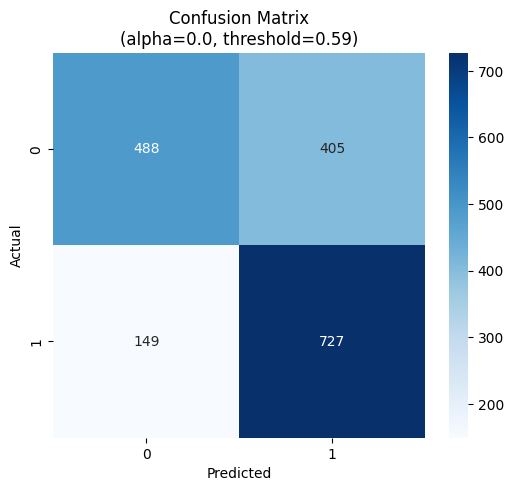

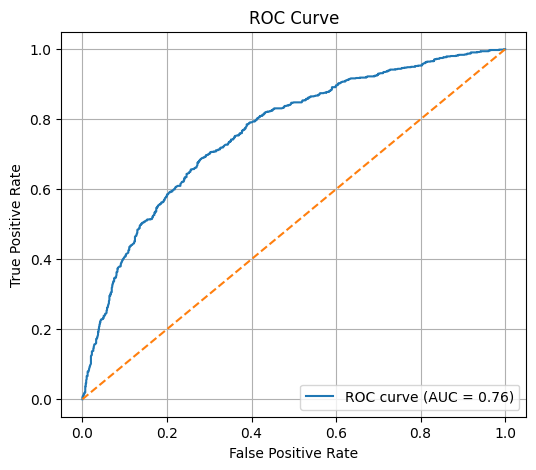

In [17]:
if __name__ == "__main__":
    CSV_FILE_PATH = "/content/drive/MyDrive/PADA/Data/amazon.csv"
    FEATURE_COLS = ['Num_of_Ratings', 'Rating',
        'Is_Photo', 'Price', 'Time_Lapsed',
       'Average_Rating', 'Title_Length', 'Text_Length',
       'Deviation_Of_Star_Ratings', 'Flesch_Reading_Ease',
       'Depth', 'Breadth', 'Valence', 'Arousal']

    try:
        # 🔹 System 1 (Feature 기반) 이진 분류 모델 학습
        model_s1, embedder, scaler, preds_s1, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="feature_mlp"
        )
        if preds_s1 is not None:
            np.save("amazon_preds_s1.npy", preds_s1)
            np.save("amazon_y_true.npy", y_true)
            torch.save(model_s1.state_dict(), "amazon_best_model_FEATURE_MLP.pt")

        # 🔹 System 2 (Text 기반) 이진 분류 모델 학습
        model_s2, embedder_s2, scaler_s2, preds_s2, y_true = main_training_pipeline_binary(
            csv_path=CSV_FILE_PATH,
            text_column="Review_Text",
            target_column="Helpfulness",
            feature_columns=FEATURE_COLS,
            batch_size=64,
            epochs=5,
            learning_rate=5e-5,
            model_type="text_mlp"
        )
        if preds_s2 is not None:
            np.save("amazon_preds_s2.npy", preds_s2)

        # 🔸 이진 분류 Late Fusion 평가
        ensembler = LateFusionEnsembler(alpha_list=[0.0, 0.25, 0.5, 0.75, 1.0])
        results_df = ensembler.evaluate(preds_s1, preds_s2, y_true)
        print("\n📊 Alpha별 성능 비교:")
        print(results_df)

        best_result = ensembler.get_best_result()
        best_alpha = best_result['alpha']
        best_threshold = best_result['threshold']  # ✅ 추가
        print("\n⭐️ Best Alpha Based on F1 Score:")
        print(best_result.to_string(index=True))

        # 📊 시각화
        visualize_late_fusion(preds_s1, preds_s2, y_true, best_alpha, best_threshold)
    except FileNotFoundError:
        print("\n" + "=" * 60)
        print(f"오류: '{CSV_FILE_PATH}' 파일을 찾을 수 없습니다.")
        print("실행 블록의 CSV_FILE_PATH 변수를 실제 파일 경로로 수정해주세요.")
        print("=" * 60)